In [1]:
import json
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster as cluster
import time
import scipy
import seaborn as sns
import random
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's':80, 'linewidths':0}

# set up type of service

In [2]:
# user input
user_input = 'Restaurants'


# read in business file, compose business categories, business rating on category and business postal code dictionary

In [3]:
# initialize business data
bcmap = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        
        key = l['business_id']
        state = l['city']
        #Business Category Dictionary
        category = l['categories']
        if state not in bcmap:
            bcmap[state] = {}
        bcmap[state][key] = category

# generate top categories
category = {}
for state in bcmap:
    category[state] = {}
    for i in bcmap[state]:
        if user_input in bcmap[state][i]:
            for j in bcmap[state][i]:
                if j not in category[state]:
                    category[state][j] = 1
                else:
                    category[state][j] += 1

tc = {}
for state in category:
    top_cate = sorted(category[state].items(), key=lambda x:(-x[1]))[1:21]
    tc[state] = []
    for i in top_cate:
        tc[state].append(i[0])
    
# initialize business data   
location = {}
bcrmap = {}
business_name = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        key = l['business_id']
        category = l['categories']
        
        # Business City Dictionary
        city = l['city']
        location[key] = city
        
        # Business -> Category -> Star Dictionary
        stars = l['stars']
        valid = False
        number_of_tc = 0
        if city not in bcrmap:
            bcrmap[city] = {}
        if key not in bcrmap[city]:
            bcrmap[city][key] = {}
        for i in category:
            if i in tc[city]:
                number_of_tc += 1
                valid = True
                bcrmap[city][key].setdefault(i,[]).append(stars)
        if not valid or number_of_tc <3:
            del bcrmap[city][key]
            
            
        # Business name -> Address Dictionary
        name = l['name'] +','  + l['address'] +','  + l['city'] +',' + l['state']
        business_name[key] = name
        

# read in review file and generate user to category to rating map

In [4]:
# initialize user review data
# User -> Categories -> Stars
ucrmap = {}
test_urcmap = {}
user_rating = {}
with open('review.json', 'r') as rv:
    for line in rv:
        n1 = json.loads(line)
        
        okey = n1['user_id']
        year = n1['date']
        bid = n1['business_id']
        value = n1['stars']
        
        city = location[bid]
        
        ikeys = bcmap[city][bid]
        
        if city not in user_rating:
            user_rating[city] = {}
        user_rating[city].setdefault(okey, []).append(value)
        if city not in ucrmap:
            ucrmap[city]  = {}
        if city not in test_urcmap:
            test_urcmap[city]  = {}
        if int(n1['date'].split('-')[0]) < 2016:
            if okey not in ucrmap[city]:
                ucrmap[city][okey] = {}
            for ikey in ikeys:
                if ikey in tc[city]:
                    ucrmap[city][okey].setdefault(ikey, []).append(value)
        else:
            if okey not in test_urcmap:
                test_urcmap[city][okey] = {}
            test_urcmap[city][okey][bid] = value

In [5]:
listCity = {}
for i in ucrmap:
    if i in bcrmap:
        listCity[i] = {}
        listCity[i]['user'] = len(ucrmap[i])
        listCity[i]['business'] = len(bcrmap[i])

In [6]:
len(listCity)

1010

In [7]:
sorted_by_business = sorted(listCity.items(), key=lambda x: -x[1]['business'])
sorted_by_business[:15]

[('Las Vegas', {'business': 1427, 'user': 290813}),
 ('Toronto', {'business': 1325, 'user': 53905}),
 ('Phoenix', {'business': 1033, 'user': 114505}),
 ('Charlotte', {'business': 784, 'user': 39523}),
 ('Edinburgh', {'business': 676, 'user': 6869}),
 ('Pittsburgh', {'business': 671, 'user': 31715}),
 ('Montréal', {'business': 614, 'user': 21535}),
 ('Scottsdale', {'business': 542, 'user': 71454}),
 ('Cleveland', {'business': 409, 'user': 20653}),
 ('Madison', {'business': 368, 'user': 17121}),
 ('Stuttgart', {'business': 326, 'user': 7877}),
 ('Mesa', {'business': 285, 'user': 32842}),
 ('Tempe', {'business': 272, 'user': 44293}),
 ('Henderson', {'business': 227, 'user': 37913}),
 ('Mississauga', {'business': 210, 'user': 8450})]

In [8]:
sorted_by_user = sorted(listCity.items(), key=lambda x: -x[1]['user'])
sorted_by_user[:15]

[('Las Vegas', {'business': 1427, 'user': 290813}),
 ('Phoenix', {'business': 1033, 'user': 114505}),
 ('Scottsdale', {'business': 542, 'user': 71454}),
 ('Toronto', {'business': 1325, 'user': 53905}),
 ('Tempe', {'business': 272, 'user': 44293}),
 ('Charlotte', {'business': 784, 'user': 39523}),
 ('Henderson', {'business': 227, 'user': 37913}),
 ('Mesa', {'business': 285, 'user': 32842}),
 ('Pittsburgh', {'business': 671, 'user': 31715}),
 ('Chandler', {'business': 208, 'user': 30060}),
 ('Gilbert', {'business': 180, 'user': 23918}),
 ('Montréal', {'business': 614, 'user': 21535}),
 ('Glendale', {'business': 166, 'user': 21017}),
 ('Cleveland', {'business': 409, 'user': 20653}),
 ('Madison', {'business': 368, 'user': 17121})]

In [9]:
list_city = [ x[0] for x in sorted_by_business]

In [10]:
list_city[:15]

['Las Vegas',
 'Toronto',
 'Phoenix',
 'Charlotte',
 'Edinburgh',
 'Pittsburgh',
 'Montréal',
 'Scottsdale',
 'Cleveland',
 'Madison',
 'Stuttgart',
 'Mesa',
 'Tempe',
 'Henderson',
 'Mississauga']

In [11]:
def recommend_based_on_state(state):
    print('============================================')
    print('Recommendation info summary for : ', state)

    City_of_Data = state
   
    # pre-process data: build up user and business data set based on state
    filter_user = {}
    valid_user = {}
    valid_test_user = {}
    for i in user_rating[City_of_Data]:
        if len(user_rating[City_of_Data][i]) >= 20:
            filter_user[i] = len(user_rating[City_of_Data][i])
    raw = sorted(filter_user.items(), key=lambda x:-x[1])
    valid_list = []
    for k, v in raw:
        if k in ucrmap[City_of_Data] and k in test_urcmap[City_of_Data]:
            valid_list.append(k)
            valid_user[k] = ucrmap[City_of_Data][k]
            valid_test_user[k] = test_urcmap[City_of_Data][k]
            
    print('number of valid user: ', len(valid_user))
    print('number of valid test user: ', len(valid_user))
    
    #generate business category dict with pure vector
    def generate_nbcrmap(data):
        for business in data:
            for k, v in data[business].items():
                data[business][k] = statistics.mean(v)

        for business in data:
            for i in tc[state]:
                if i not in data[business]:
                    data[business][i] = 1

        nbcrmap = {}
        for k, v in data.items():
            nbcrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nbcrmap[k] = value
        return nbcrmap

    nbcrmp = generate_nbcrmap(bcrmap[City_of_Data])
    
    # Compose user category vector
    def generate_nucrmap(data):
        for user in data:
            for cate, value in data[user].items():
                data[user][cate] = statistics.mean(value)
        for user in data:
            for i in tc[state]:
                if i not in data[user]:
                    data[user][i] = 3.15

        nucrmap = {}
        for k, v in data.items():
            nucrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nucrmap[k] = value
        return nucrmap

    nucrmap = generate_nucrmap(valid_user)
    
    data = nucrmap
    listV = list(data.values())
    listK = list(data.keys())
    
    # Agglomerative clustering using scipy
    Z = scipy.cluster.hierarchy.linkage(listV[:300], method='average')
    plt.clf()
    fig = plt.figure(figsize=(100, 60), dpi=40, facecolor='w', edgecolor='k')
    dd = scipy.cluster.hierarchy.dendrogram(Z)
    plt.savefig('{}.pdf'.format('average'))
    plt.show()
    

    
    #agglomerative clustering using sklearn 
    data1 = []
    for k,v in nucrmap.items():
        data1.append(v)
    np.save('123', np.array(data1))
    data1 = np.load('123.npy')

    # get number of clusters from above plot and generate clusters dictionary
    model = cluster.AgglomerativeClustering(linkage='average', n_clusters=20)
    result = model.fit_predict(listV)
    clusters = {}
    for i in range(len(result)):
        k = result[i]
        v = data1[i]
        clusters.setdefault(k, []).append(v)

    # Average Vector for each cluster generated above

    average_vector = {}
    for i in list(clusters.keys()):
        average_vector[i] = np.mean(clusters[i], axis=0)

    def generate_recommendatioin(uid):
        index = listK.index(uid)
        uvector = average_vector[result[index]]
        r = {}
        for i in nbcrmp:
            r[i] = np.inner(uvector, nbcrmp[i])
        top_business = sorted(r.items(), key=lambda x:(-x[1]))[1:100]
        return [k for k,v in top_business]
    def cacluate_hr(uid, bids):
        score = 0
        count = 0
        for bid in bids:
            if bid in valid_test_user[uid]:
                count += 1
                if valid_test_user[uid][bid] > 3.7:
                    score += 1
                if valid_test_user[uid][bid] < 2.6:
                    score -= 1
        return np.array([score, count])
    
    def calculate_ndcg(uid, bids):
        gain = 0
        ind_list = []
        for i in range(len(bids)):
            bid = bids[i]
            if bid in valid_test_user[uid]:
                ind_list.append(i+1)
                gain += valid_test_user[uid][bid]/(i+1)
        idcg = 0
        for i in ind_list:
            idcg += 5/i
        if idcg == 0:
            return 0
        return np.array([gain,idcg])

    def evaluate(list_test):
        hr = np.array([0.,0.])
        ndcg = np.array([0.,0.])
        for uid in list_test:
            recs = generate_recommendatioin(uid)
            tmp = cacluate_hr(uid, recs)
            ndcg += calculate_ndcg(uid, recs)
            hr += tmp
        print('Hit Ratio: ', hr[0]/hr[1])
        print('NDCG: ', ndcg[0]/ndcg[1])
        print('============================================')
        print('\n\n\n\n')
        return (hr[0]/hr[1], ndcg[0]/ndcg[1])
    
    # user index corresponding to user vector dictionary
    index = random.randint(0,len(listK)-1)
    # Get the users cluster vector 
    user_vector = average_vector[result[index]]
    # Perfor inner dot product between user_vector and each business vector

    result_bcrmap = {}
    for i in nbcrmp:
        result_bcrmap[i] = np.inner(user_vector, nbcrmp[i])
    # Sort the business based on the minimum value of above operation. Keep top 20 businesses
    top_business = sorted(result_bcrmap.items(), key=lambda x:(-x[1]))[1:20]
    # print out the recommended businesses

    for k,v in top_business:
        print(business_name[k])
        
        
    return evaluate(valid_list)

Recommendation info summary for :  Las Vegas
number of valid user:  5896
number of valid test user:  5896


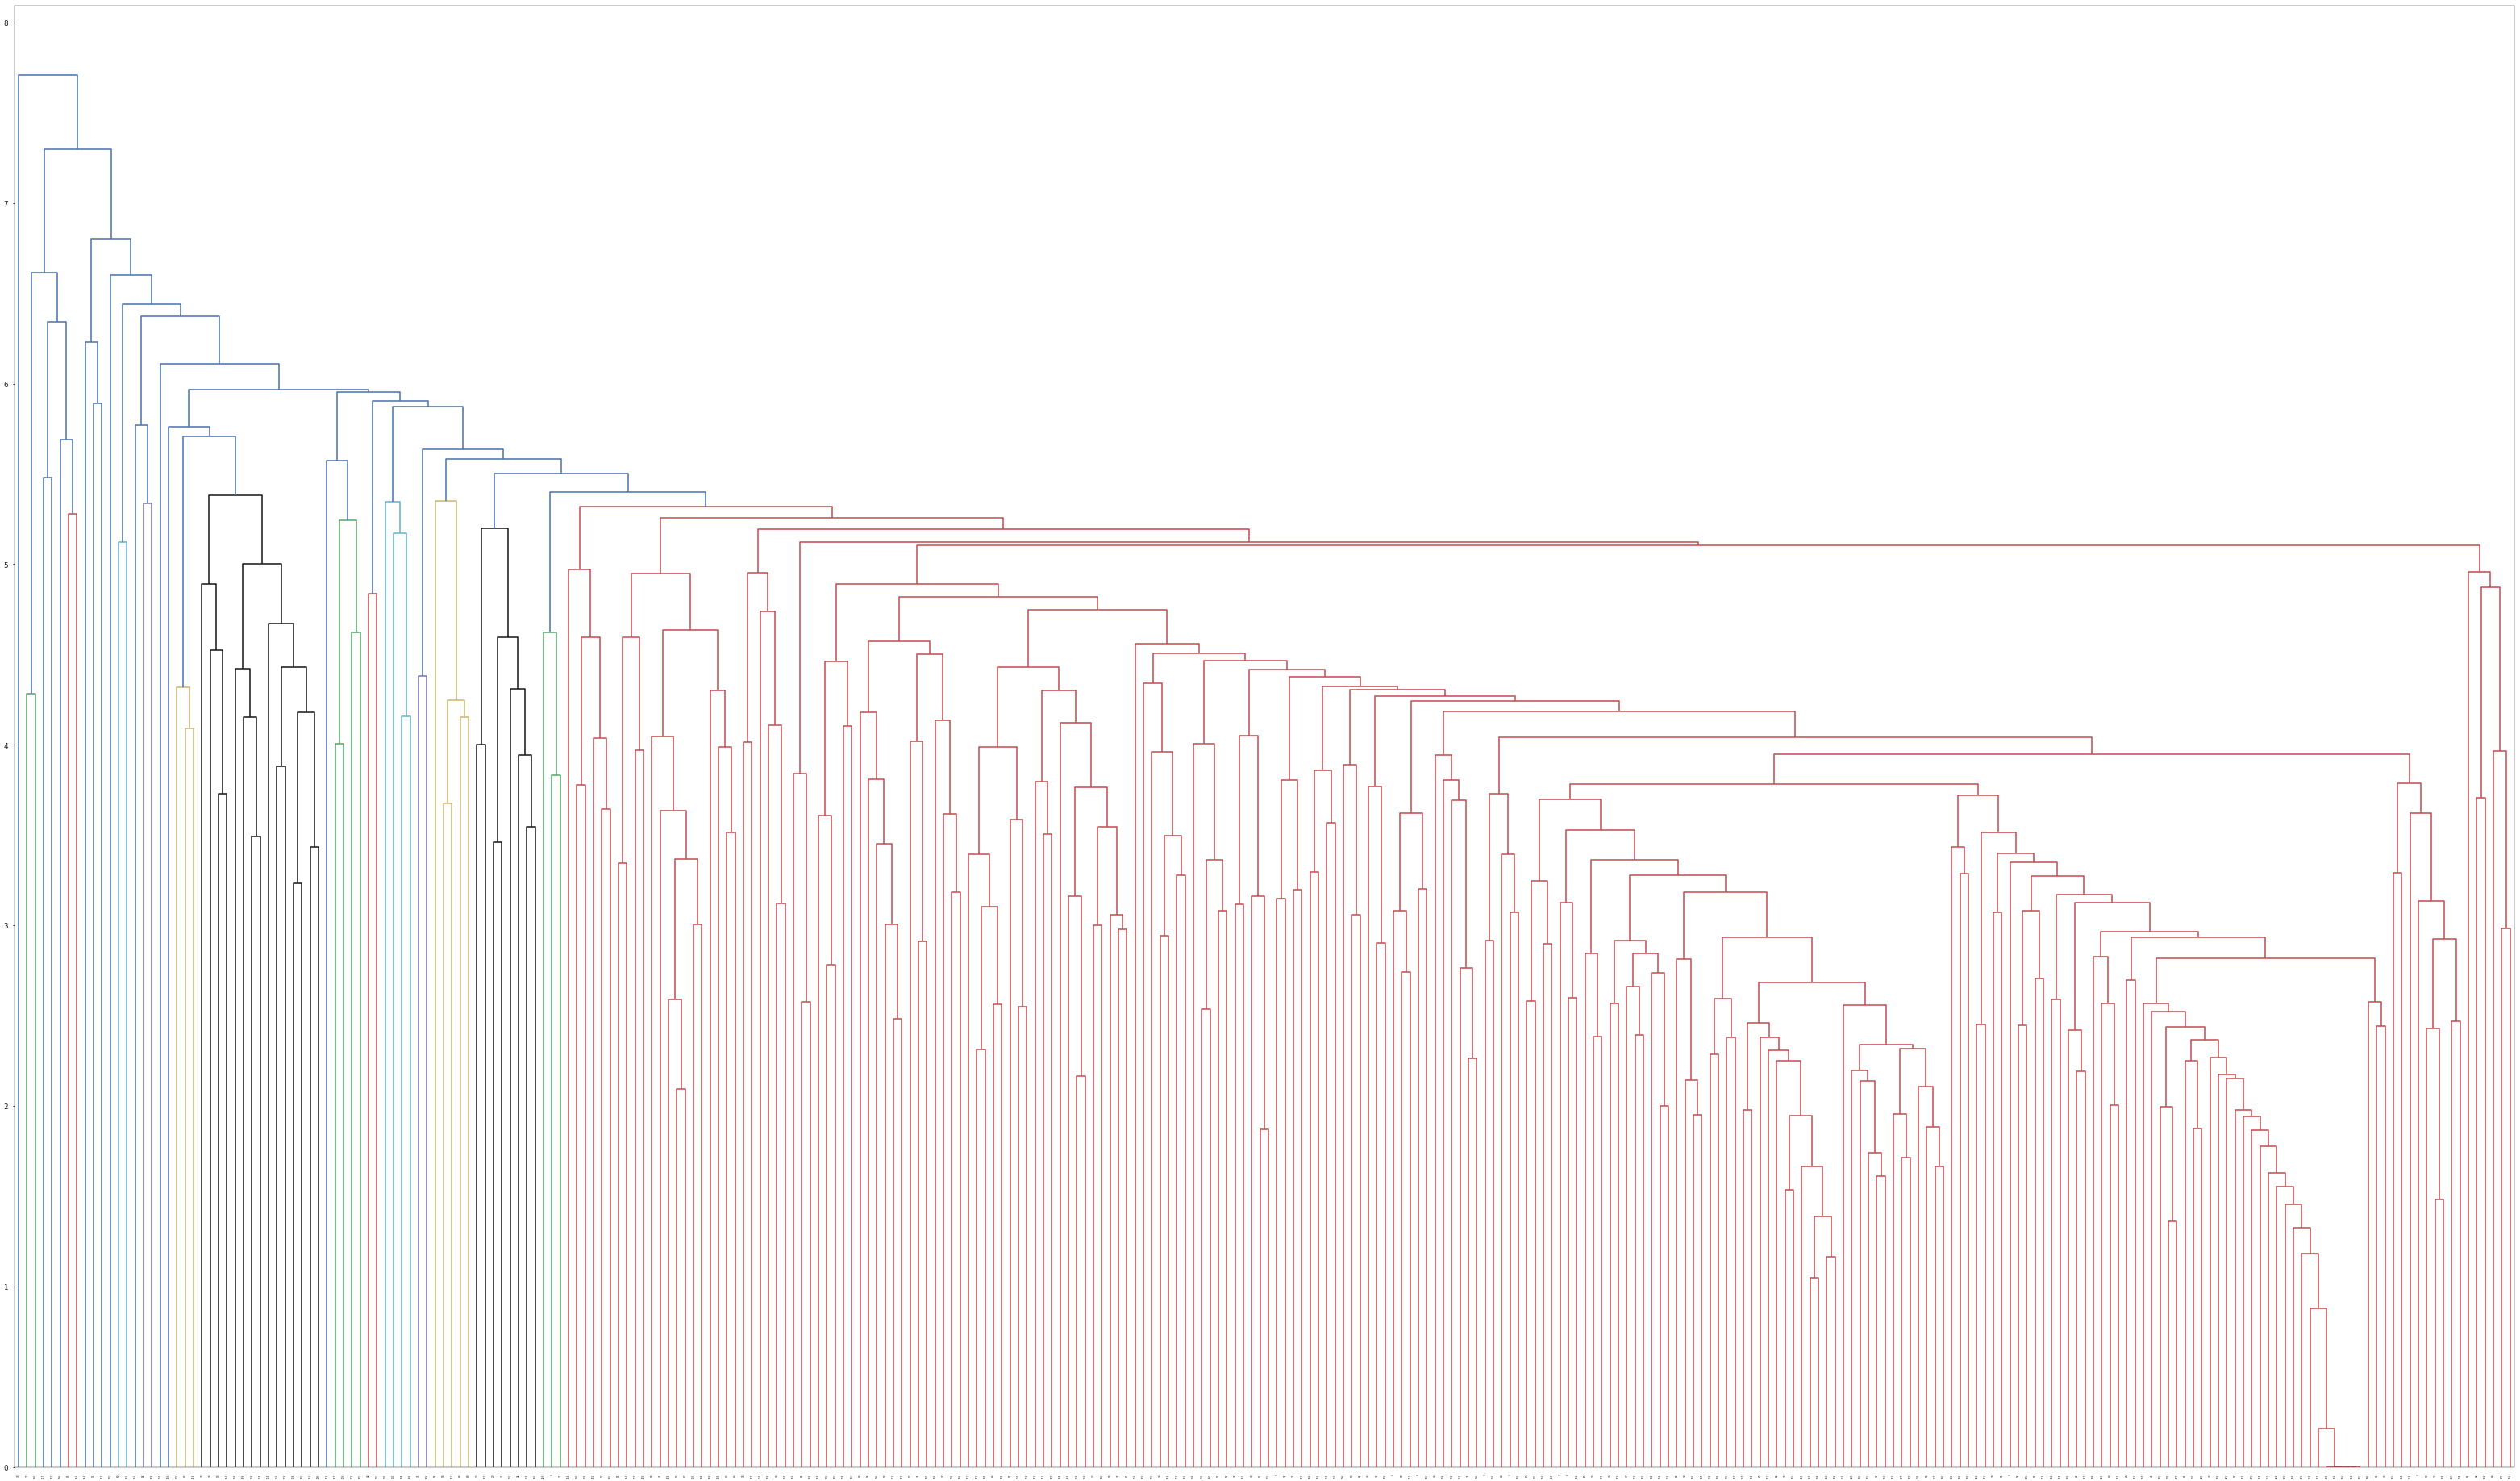

Yard House,11011 W Charleston Blvd,Las Vegas,NV
Greens and Proteins,8975 S Eastern Ave,Las Vegas,NV
Yard House,6593 Las Vegas Blvd S,Las Vegas,NV
Yard House,3545 Las Vegas Blvd,Las Vegas,NV
Espression Cafe,321 S Casino Center Blvd, Ste 120,Las Vegas,NV
Jjanga Steak & Sushi,6125 S Fort Apache Rd, Ste 200,Las Vegas,NV
Gilligan's HideAway,2601 Atlantic St,Las Vegas,NV
Zest - Bistro & Bar,10670 Southern Highlands Pkwy, Ste 102,Las Vegas,NV
Pier 215,7060 S Durango Dr, Ste 101,Las Vegas,NV
Soho Sushi Burrito,6040 W Badura Ave, Ste 150,Las Vegas,NV
Nacho Daddy Henderson,9925 S Eastern Ave,Las Vegas,NV
The Blind Pig,4515 Dean Martin Dr, Ste 1,Las Vegas,NV
Grotto Ristorante,129 E Fremont St,Las Vegas,NV
Off The Strip at the LINQ,3545 Las Vegas Blvd S,Las Vegas,NV
Elements Fine Casual Dining & Cocktails,4950 S Rainbow Blvd, Ste 100,Las Vegas,NV
Cactus Jacks Saloon,10648 S Maryland Pkwy,Las Vegas,NV
Mr Poké,2170 S Rainbow Blvd,Las Vegas,NV
Kaffe Live,5135 S Fort Apache Rd, Ste 145,Las Vegas,NV
Th

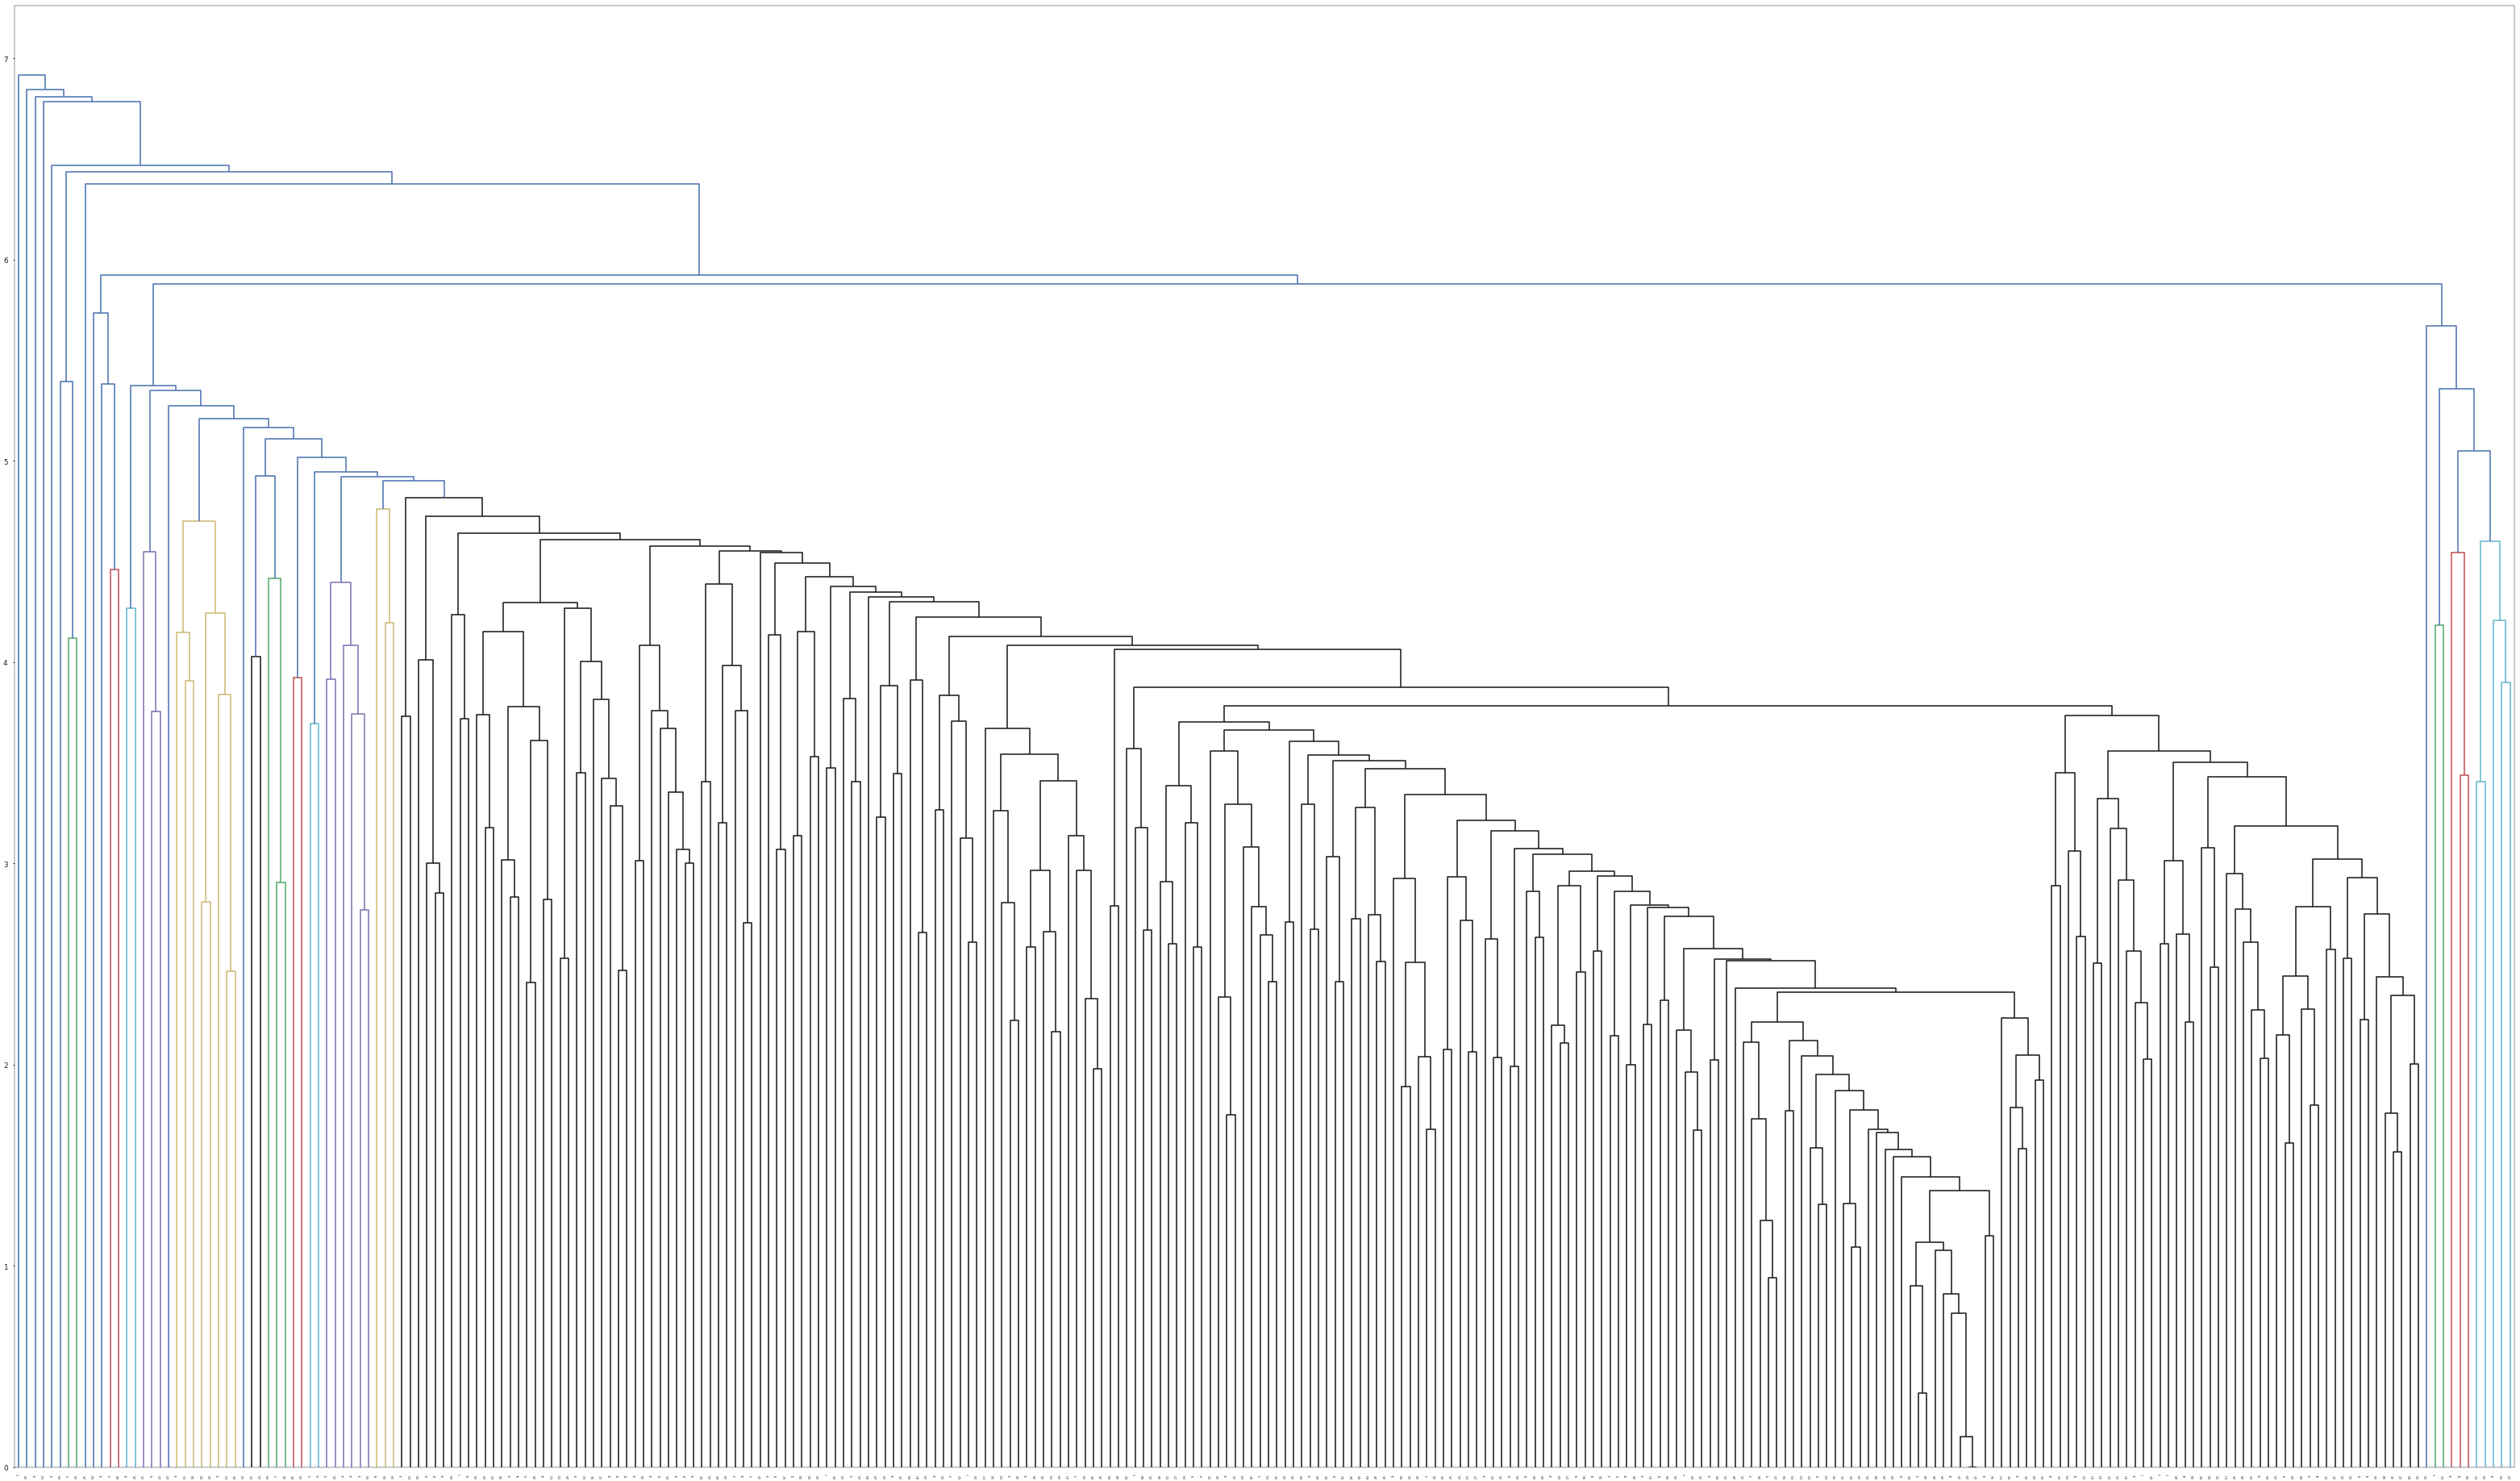

MoTo Coffee and Snack Bar,1321 Dundas Street W,Toronto,ON
Film Cafe by Eative,230 Augusta Avenue,Toronto,ON
Northwood,815 W Bloor Street,Toronto,ON
Roll Play,10A Edward Street, Second Floor,Toronto,ON
Haute Coffee,153 Dupont Street,Toronto,ON
Scout & Cash Caffe,146 Christie Street,Toronto,ON
Voodoo Child,388 College Street,Toronto,ON
Page One,106 Mutual Street,Toronto,ON
The Porch Light,982 Kingston Road,Toronto,ON
Ciao Europa Cafe,80 Western Battery Road,Toronto,ON
Green Republic Food,439 University Avenue, Unit 105,Toronto,ON
Raca Cafe and Bar,1704 Queen Street W,Toronto,ON
Paint Cabin,723 Gerrard Street E,Toronto,ON
Tesla Cafe,690 Euclid Avenue,Toronto,ON
Fifth Pubhouse,221 Richmond Street W,Toronto,ON
The Cure,1484 Dundas Street W,Toronto,ON
Oliver & Bonacini Café Grill,33 Yonge Street,Toronto,ON
Sugar For My Honey,3399 Lake Shore Boulevard,Toronto,ON
Bannock,401 Bay Street,Toronto,ON
Hit Ratio:  0.614035087719
NDCG:  0.690949140456





Recommendation info summary for :  Phoenix
n

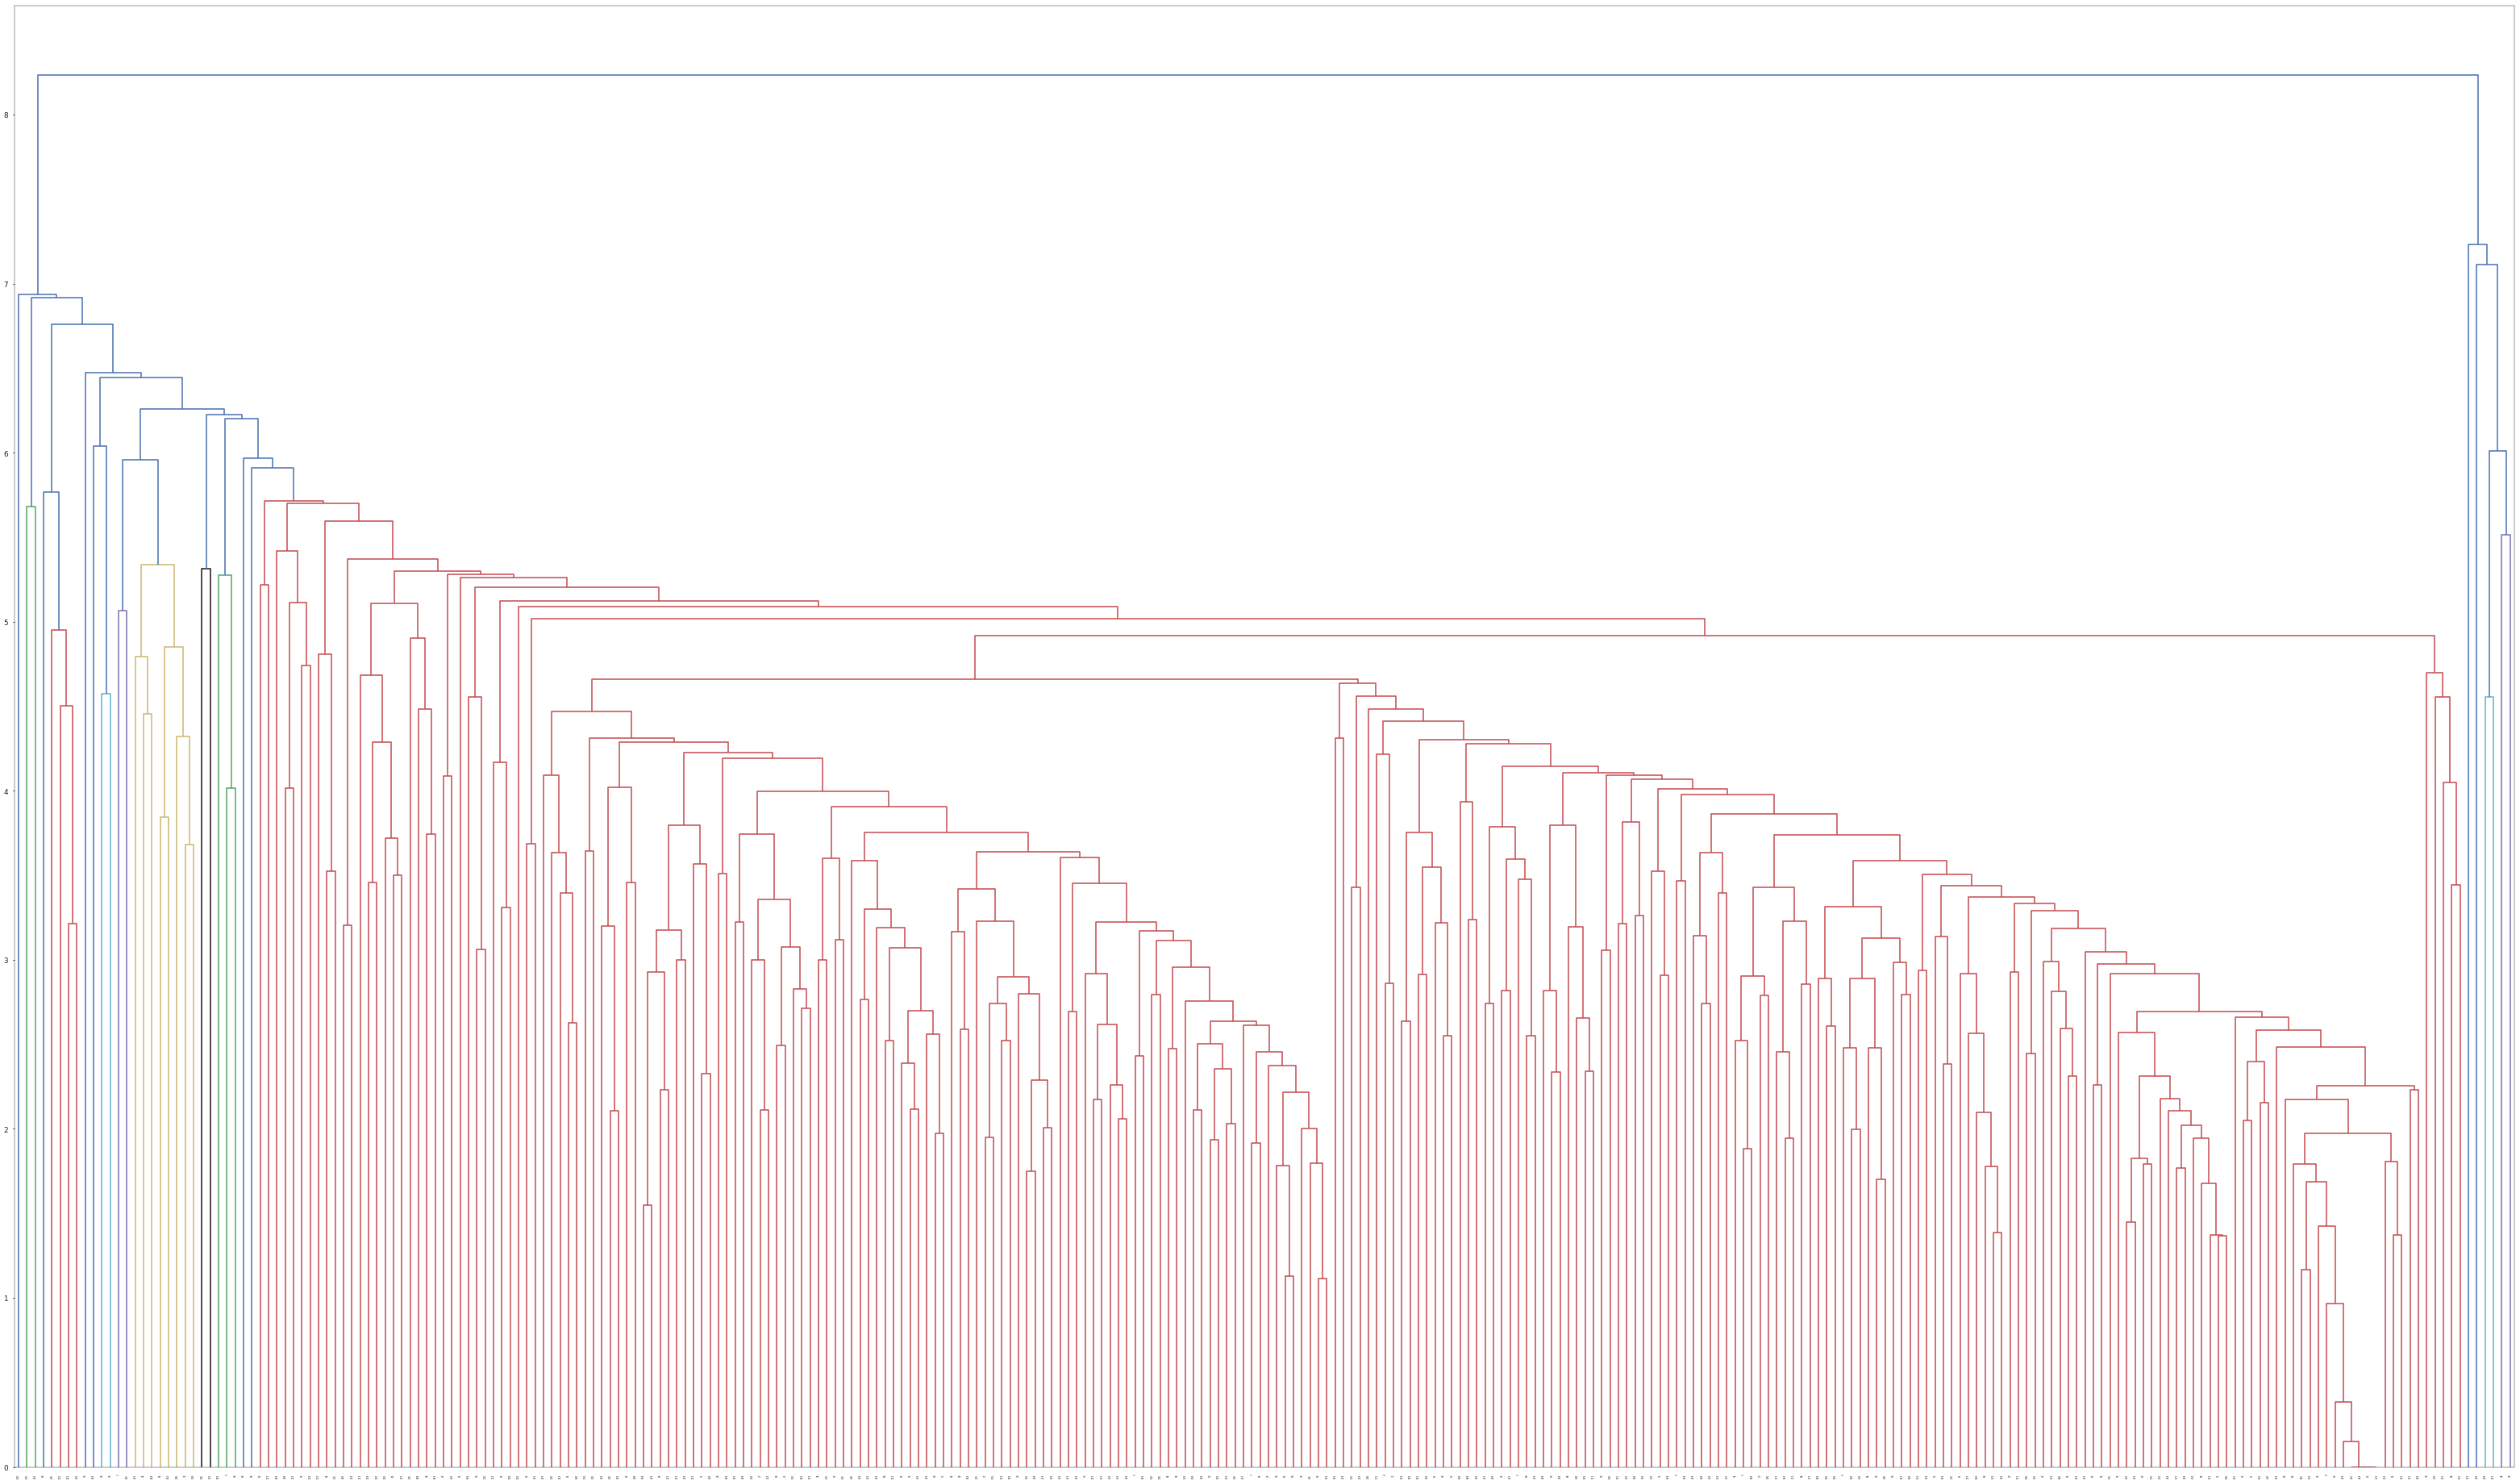

Hob Nobs,149 W McDowell Rd,Phoenix,AZ
Presidio Cocina Mexicana,519 W Thomas Rd,Phoenix,AZ
Phoenix City Grille,5816 N 16th St,Phoenix,AZ
Perfect Pear Bistro,1241 E Chandler Blvd,Phoenix,AZ
Spoke & Wheel,8525 N Central Ave,Phoenix,AZ
Carly's Bistro,128 E Roosevelt St,Phoenix,AZ
Urban Beans Cafe & Bar,3508 N 7th St, Ste 100,Phoenix,AZ
Karlas Sports Lounge & Restaurant,2448 Grand Ave,Phoenix,AZ
PHX Eats Cafe,4129 E Van Buren St,Phoenix,AZ
The Arrogant Butcher,2 E Jefferson St, Ste 150,Phoenix,AZ
Gallo Blanco,401 W Clarendon Ave,Phoenix,AZ
Lux Central,4400 N Central Ave,Phoenix,AZ
Helio Basin Brewing,3935 E Thomas Rd,Phoenix,AZ
The Coronado,2201 N 7th St,Phoenix,AZ
Ollie Vaughn's,1526 E McDowell Rd,Phoenix,AZ
Beneficial Beans,1221 N Central Ave,Phoenix,AZ
The Dressing Room,220 E Roosevelt St,Phoenix,AZ
Shorty's Sandwich Shop,3767 E Broadway Rd, Ste 8,Phoenix,AZ
Nana Tee's Hometown Dogs,4212 W Cactus Rd, Ste 1107,Phoenix,AZ
Hit Ratio:  0.598039215686
NDCG:  0.756493002348





Recommendation

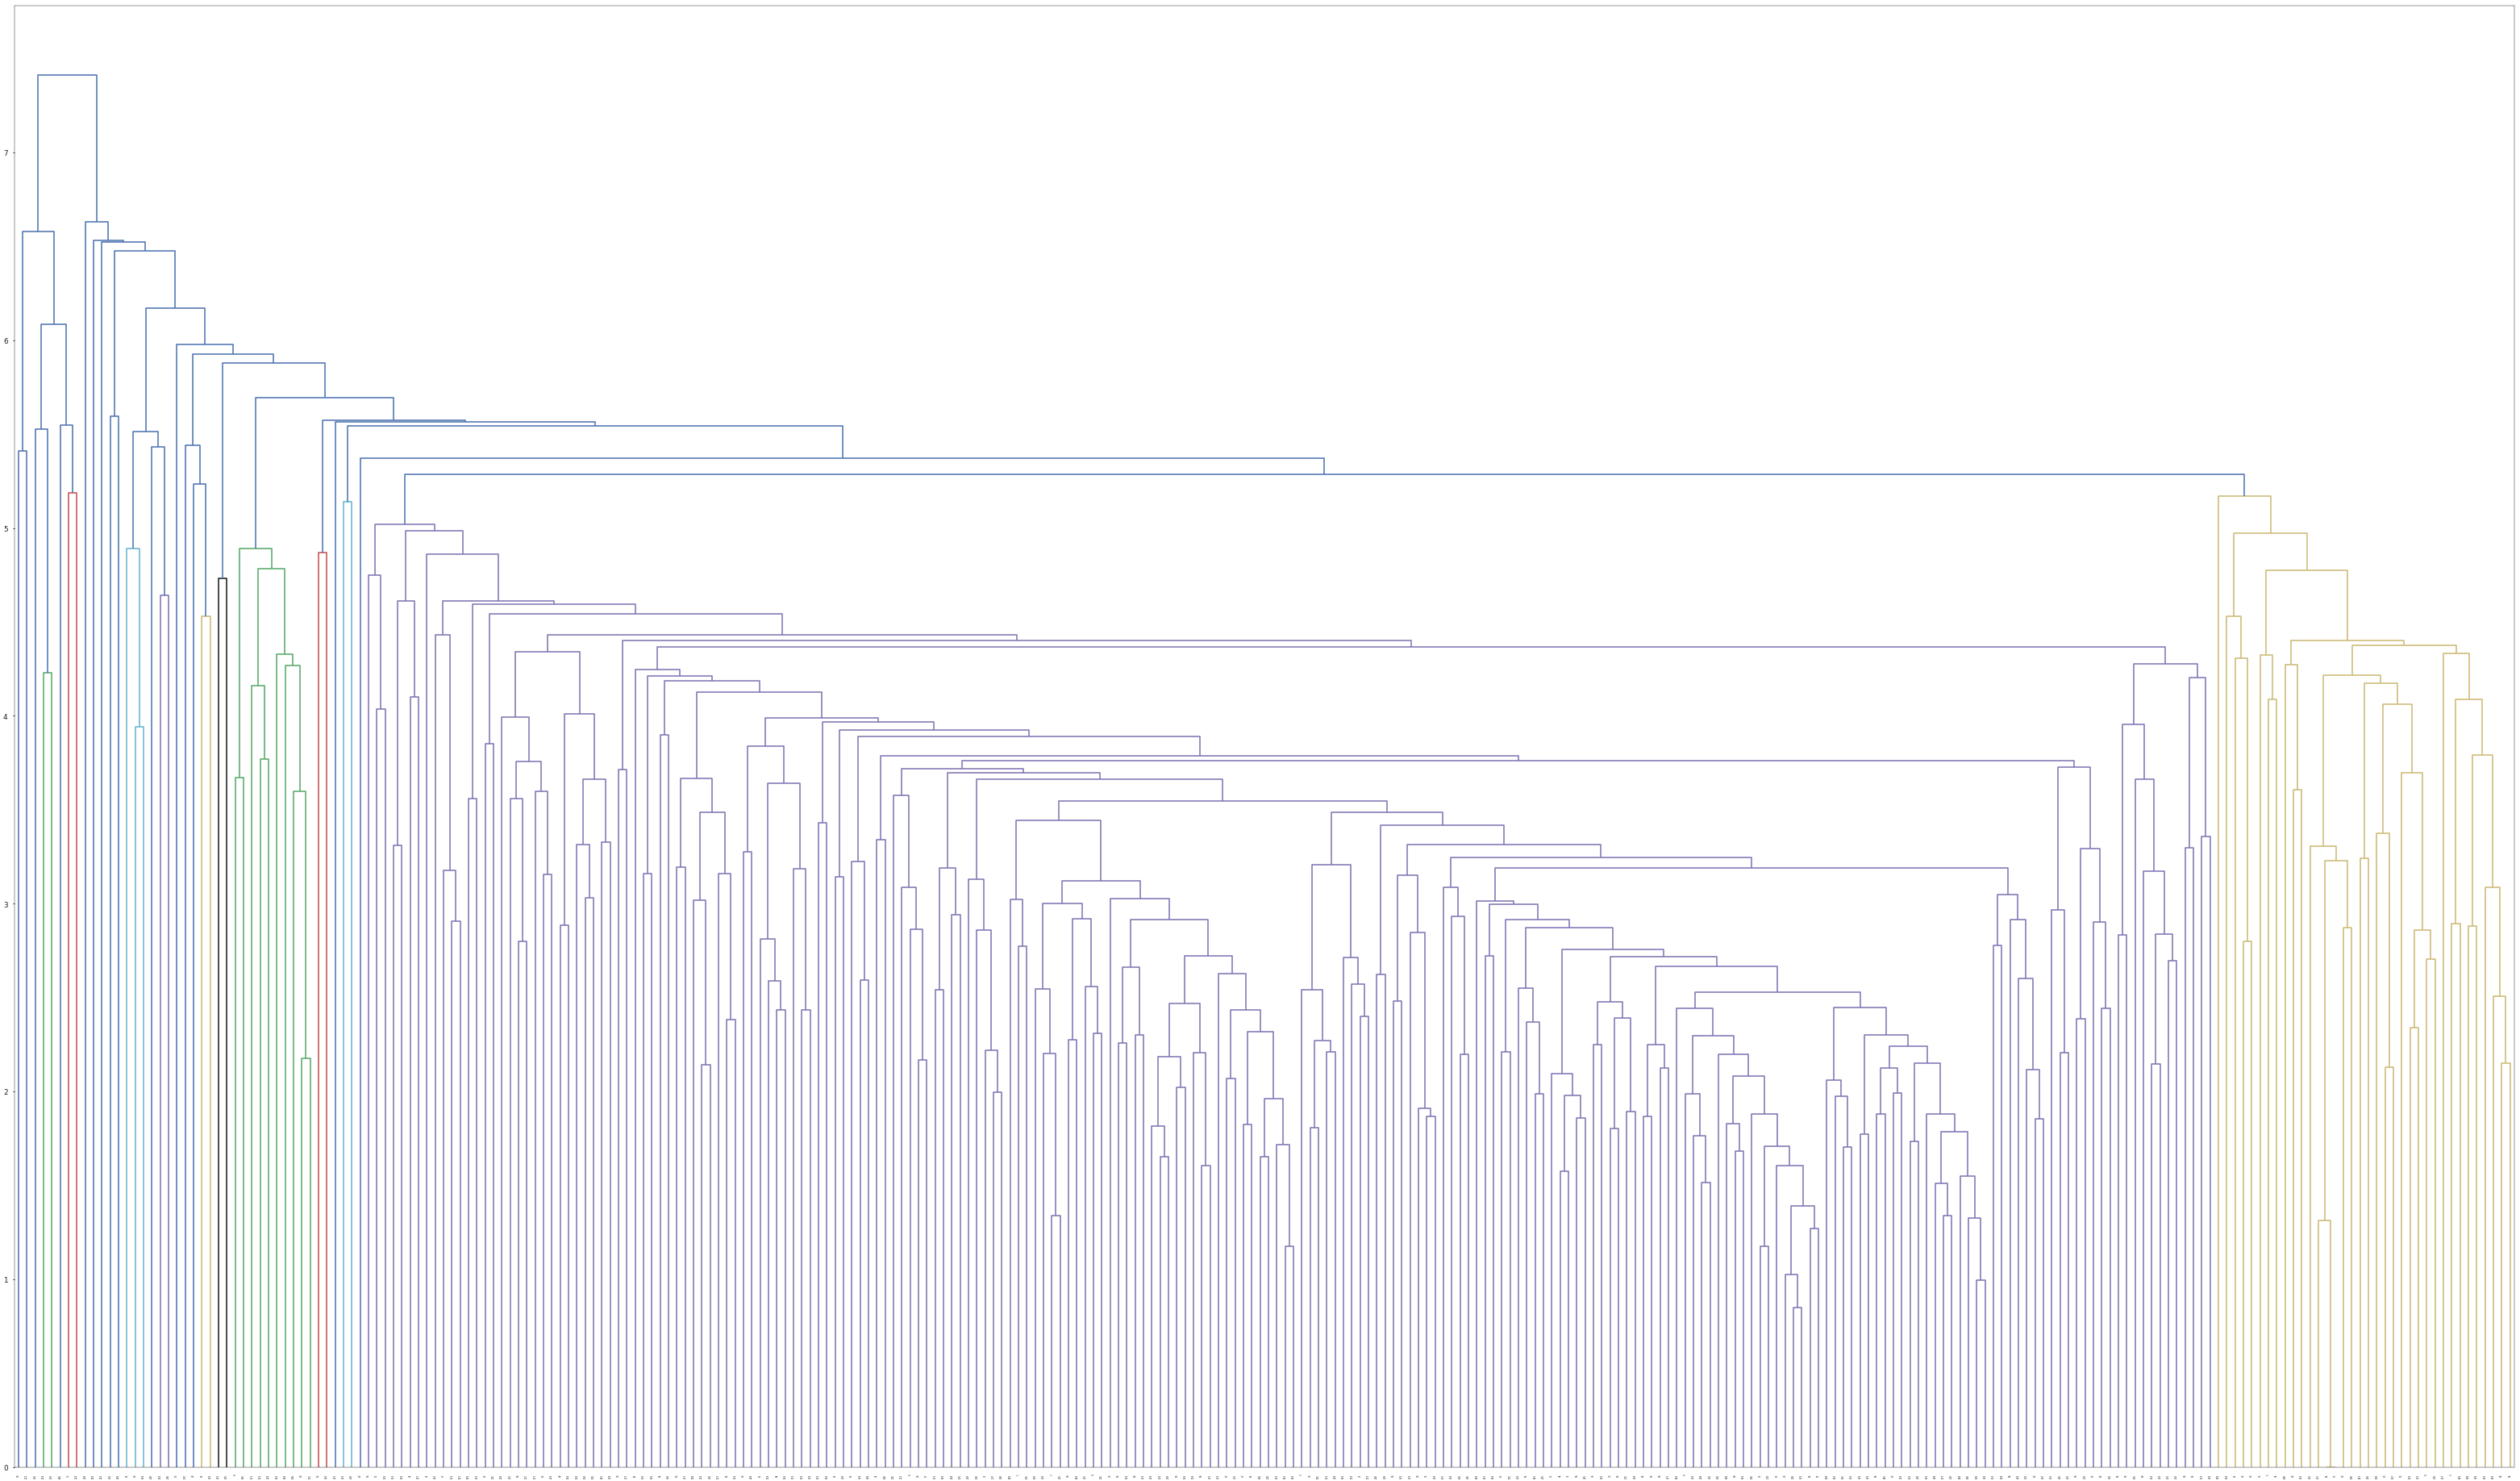

Bedder Bedder & Moore Montford-Abbey,1730 Abbey Pl, Ste 4,Charlotte,NC
300 East,300 East Blvd,Charlotte,NC
Gallery Restaurant,10000 Ballantyne Commons Pkwy,Charlotte,NC
Chicken Salad Chick,7617-C Pineville-Matthews Rd,Charlotte,NC
Whooli's Grill,7146 E Independence Blvd,Charlotte,NC
The Common Market Oakwold,4420 Monroe Rd,Charlotte,NC
Local Loaf,224 E 7th St,Charlotte,NC
Hickory Tavern,1100 Metropolitan Ave, Ste 170,Charlotte,NC
Harry's Grille & Tavern,2127 Ayrsley Town Blvd, Ste 103,Charlotte,NC
Bad Daddy's Burger Bar,1626 East Blvd,Charlotte,NC
The Randazzos' Grid Iron,13105 S Tryon St,Charlotte,NC
Nothing But Noodles,1605 Elizabeth Ave,Charlotte,NC
Rhino Market & Deli,1500 W Morehead St, Ste E,Charlotte,NC
The Turnhouse Grille,1600 E Woodlawn Rd, Ste 100,Charlotte,NC
Murphy's Kitchen & Tap,445 W Trade St,Charlotte,NC
Helles & Dunkel,222 E Bland St,Charlotte,NC
Caffe Siena,230 N College St,Charlotte,NC
Coastal Kitchen & Bar,Inside Hilton Charlotte Center City, 222 E 3rd St,Charlotte

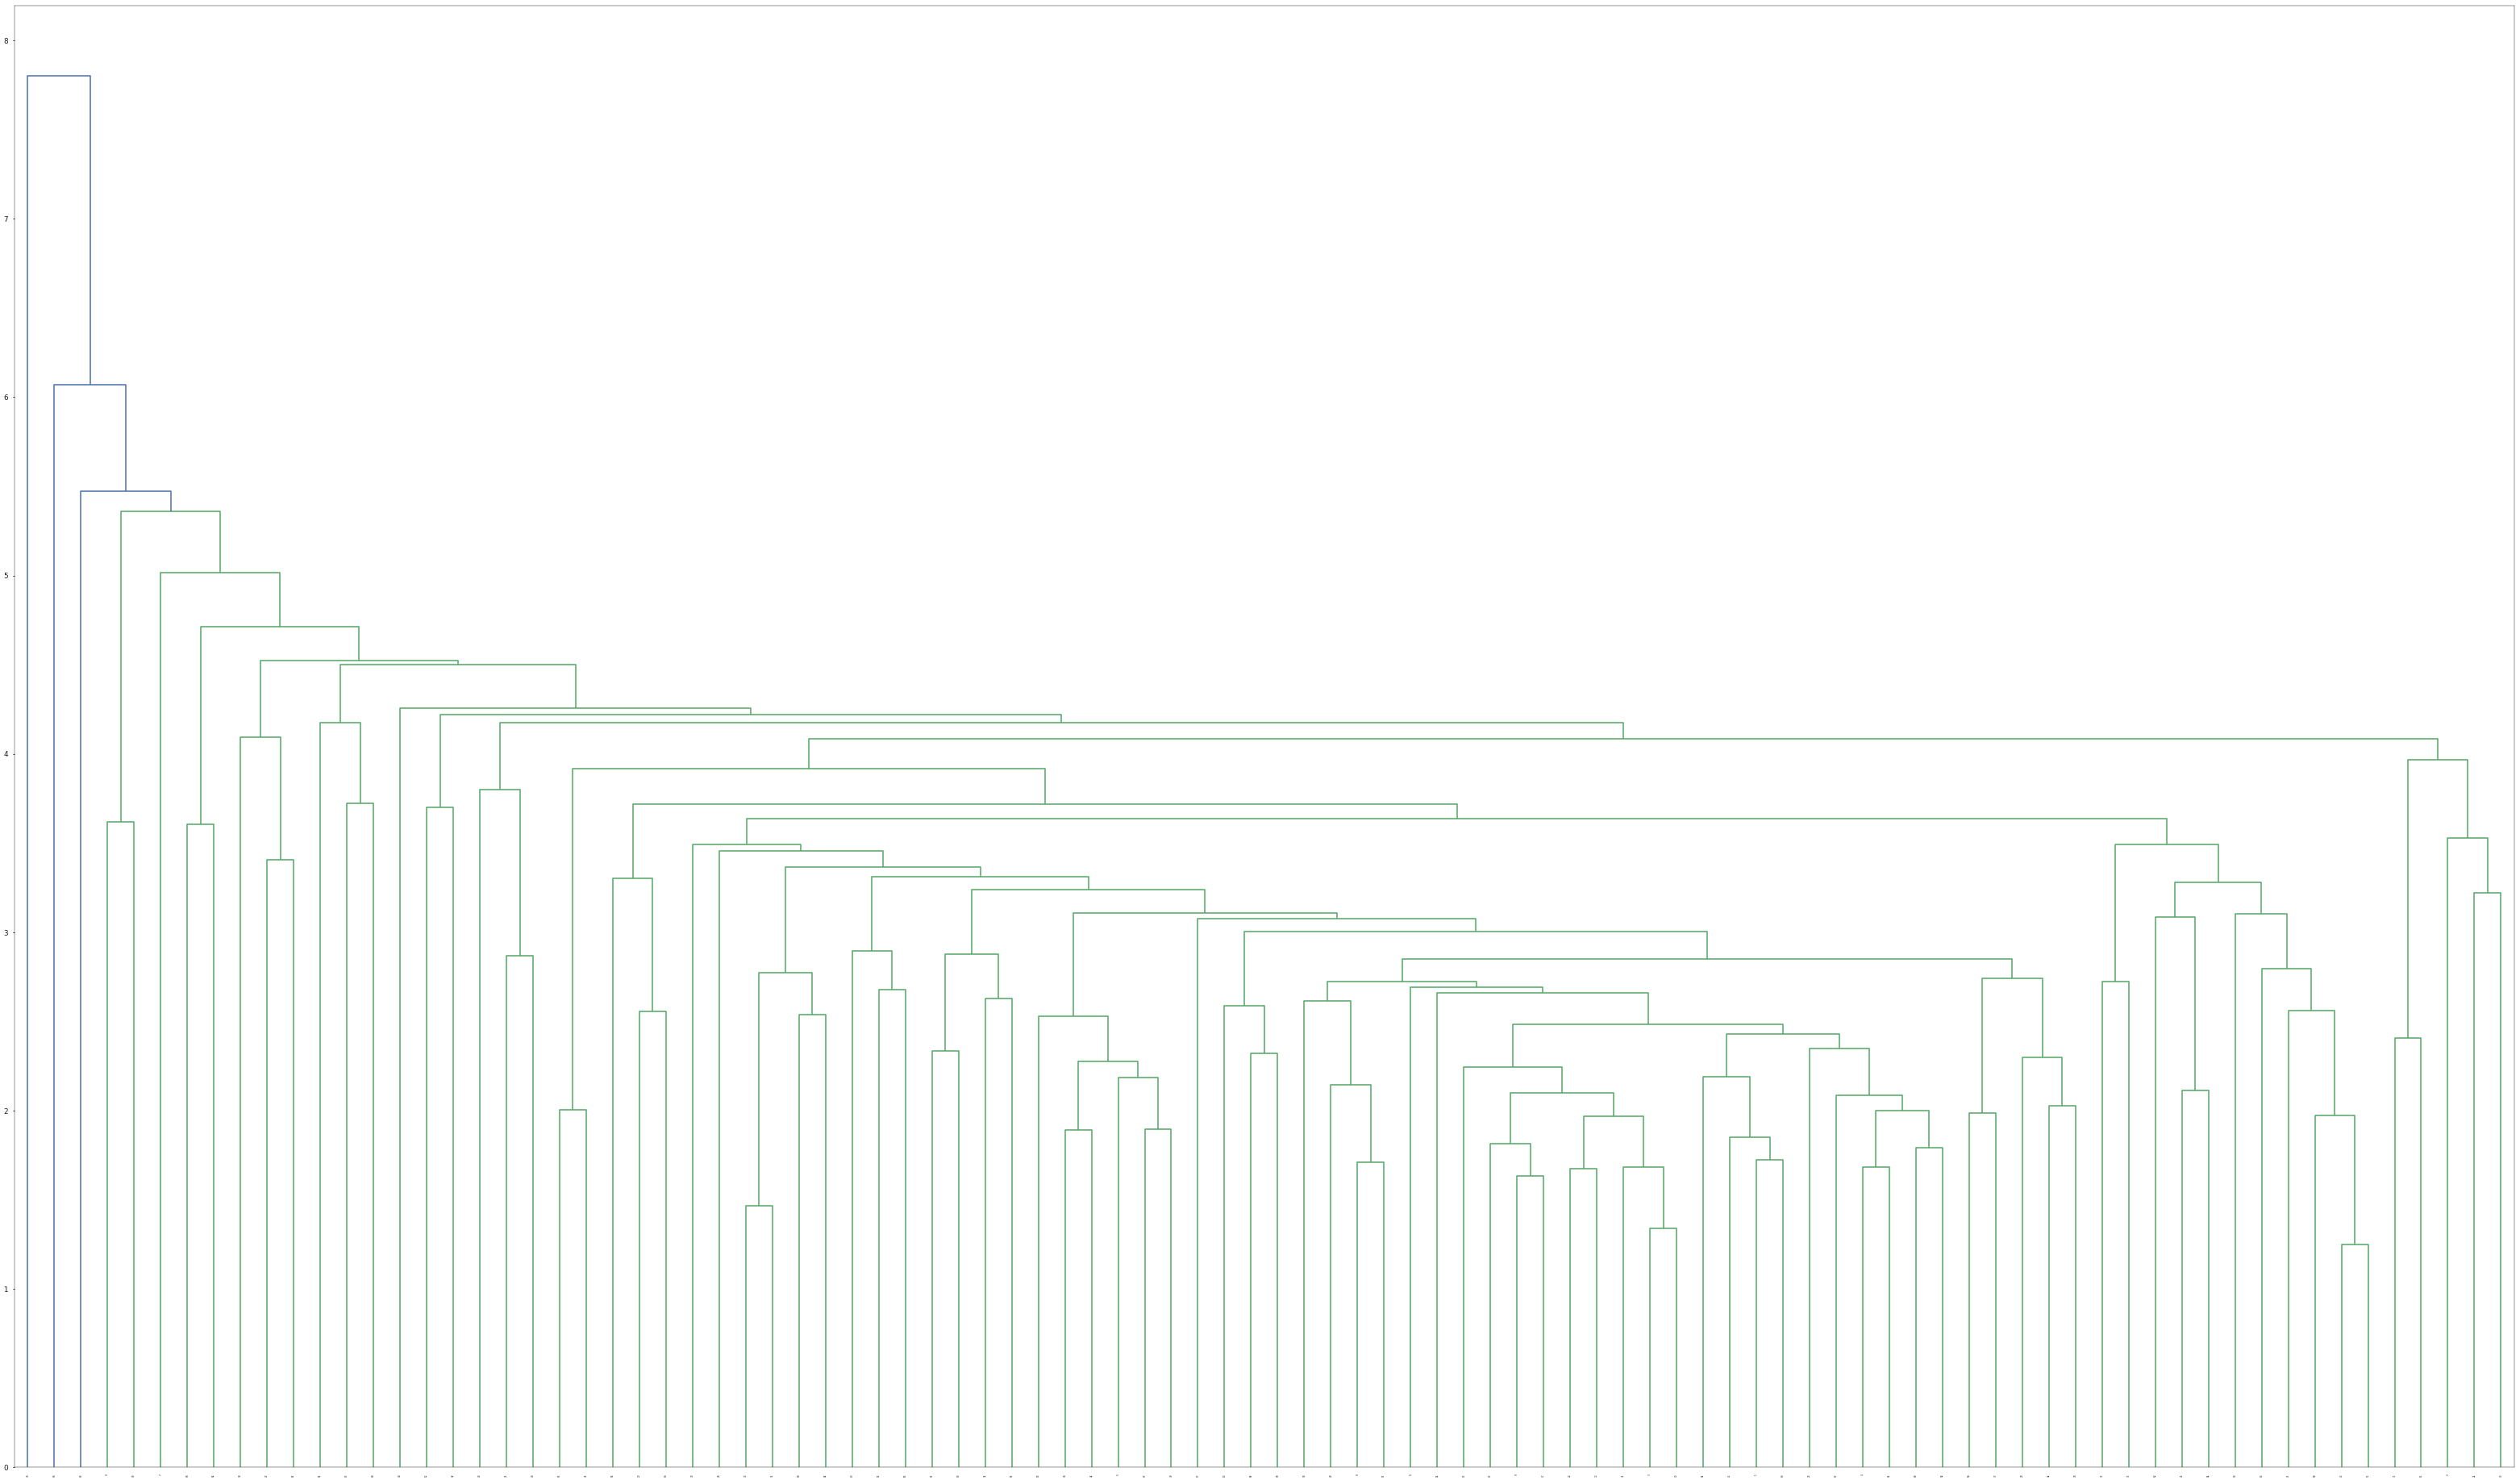

Colonnades,The Signet Library, Parliament Square, The Royal Mile,Edinburgh,EDH
The Scotch Malt Whisky Society,87 Giles Street, Leith,Edinburgh,EDH
The King's Wark,36 The Shore,Edinburgh,EDH
Royal McGregor,154 High Street,Edinburgh,EDH
Black Dutch Cafe Bar,91 Montgomery Street,Edinburgh,EDH
Sala Cafe Bar,58a Broughton Street,Edinburgh,EDH
Filament Coffee,5 India Buildings, Victoria Street,Edinburgh,EDH
Cafe Cassis,43-45 Salisbury Road,Edinburgh,EDH
The Safari Lounge,21 Cadzow Place, London Road,Edinburgh,EDH
Gannet and Guga,Unit 2-3 The Arches, East Market Street,Edinburgh,EDH
The Grain Store,30 Victoria Street,Edinburgh,EDH
Badger & Co.,32 Castle Street,Edinburgh,EDH
Nobles Cafe Bar & Venue,44a Constitution Street, Leith,Edinburgh,EDH
Ryrie's Bar,1 Haymarket Terrace,Edinburgh,EDH
The White House,70 Niddrie Mains Road,Edinburgh,EDH
Fredericks Coffee House,30 Frederick Street,Edinburgh,EDH
Uncle T's,8 Forrest Road,Edinburgh,EDH
Checkpoint,3 Bristo Place,Edinburgh,EDH
Colonial House,305 L

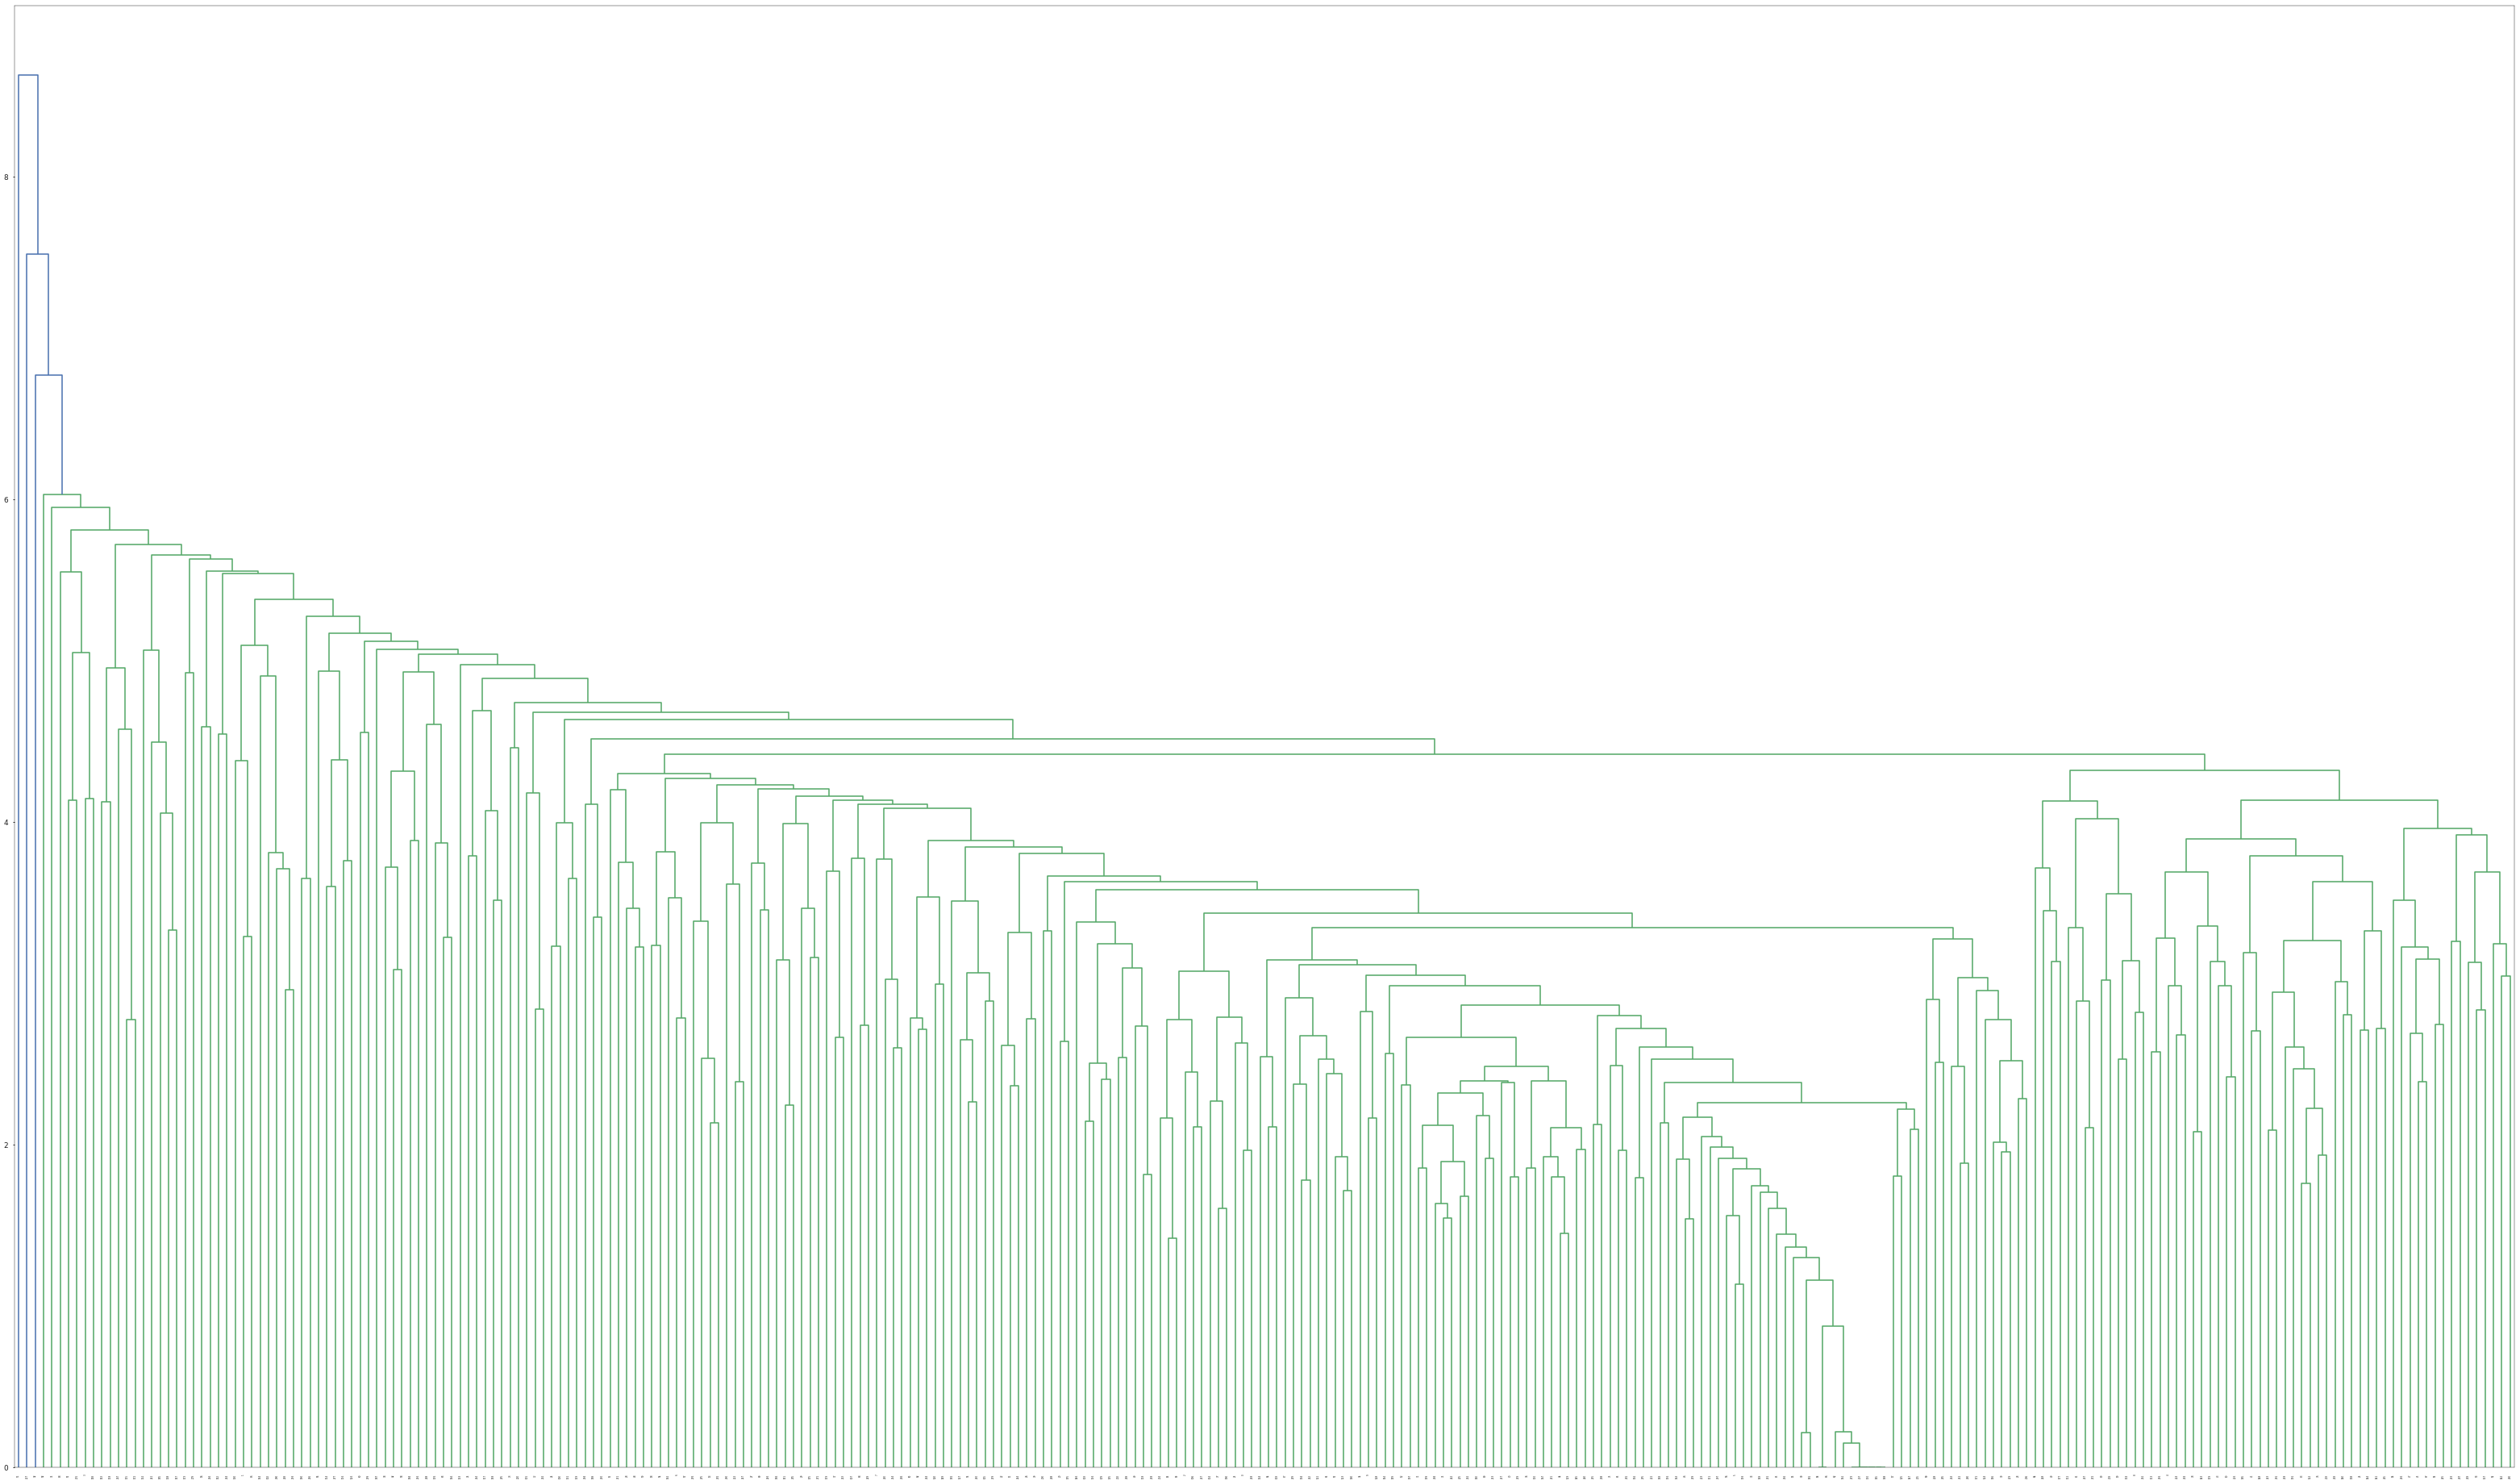

ACE Hotel Pittsburgh,120 S Whitfield St,Pittsburgh,PA
Smallman Galley,54 21st St,Pittsburgh,PA
Mixtape,4907 Penn Ave,Pittsburgh,PA
Atria's Restaurant,103 Federal St,Pittsburgh,PA
Bishop's Corner Café,4701 Campbells Run Rd,Pittsburgh,PA
Market Street Grocery,435 Market St,Pittsburgh,PA
Stagioni,2104 E Carson St,Pittsburgh,PA
Atria's,10 Old Clairton Rd,Pittsburgh,PA
The Vandal,4306 Butler St,Pittsburgh,PA
Legends Eatery,500 E N Ave,Pittsburgh,PA
G & G Noodle Bar,535 Liberty Ave,Pittsburgh,PA
Altius,1230 Grandview Ave,Pittsburgh,PA
Colony Café,1125 Penn Ave,Pittsburgh,PA
Proper Brick Oven & Tap Room,139 7th St,Pittsburgh,PA
Lexus Club at PNC Park,115 Federal St,Pittsburgh,PA
Bakersfield Penn Ave,940 Penn Ave,Pittsburgh,PA
Verde Good Beans,412 First Ave,Pittsburgh,PA
Dive Bar and Grille,2132 East Carson St,Pittsburgh,PA
Carson Street Deli & Craft Beer Bar,1507 E Carson St,Pittsburgh,PA
Hit Ratio:  0.392857142857
NDCG:  0.76506563074





Recommendation info summary for :  Montréal
number o

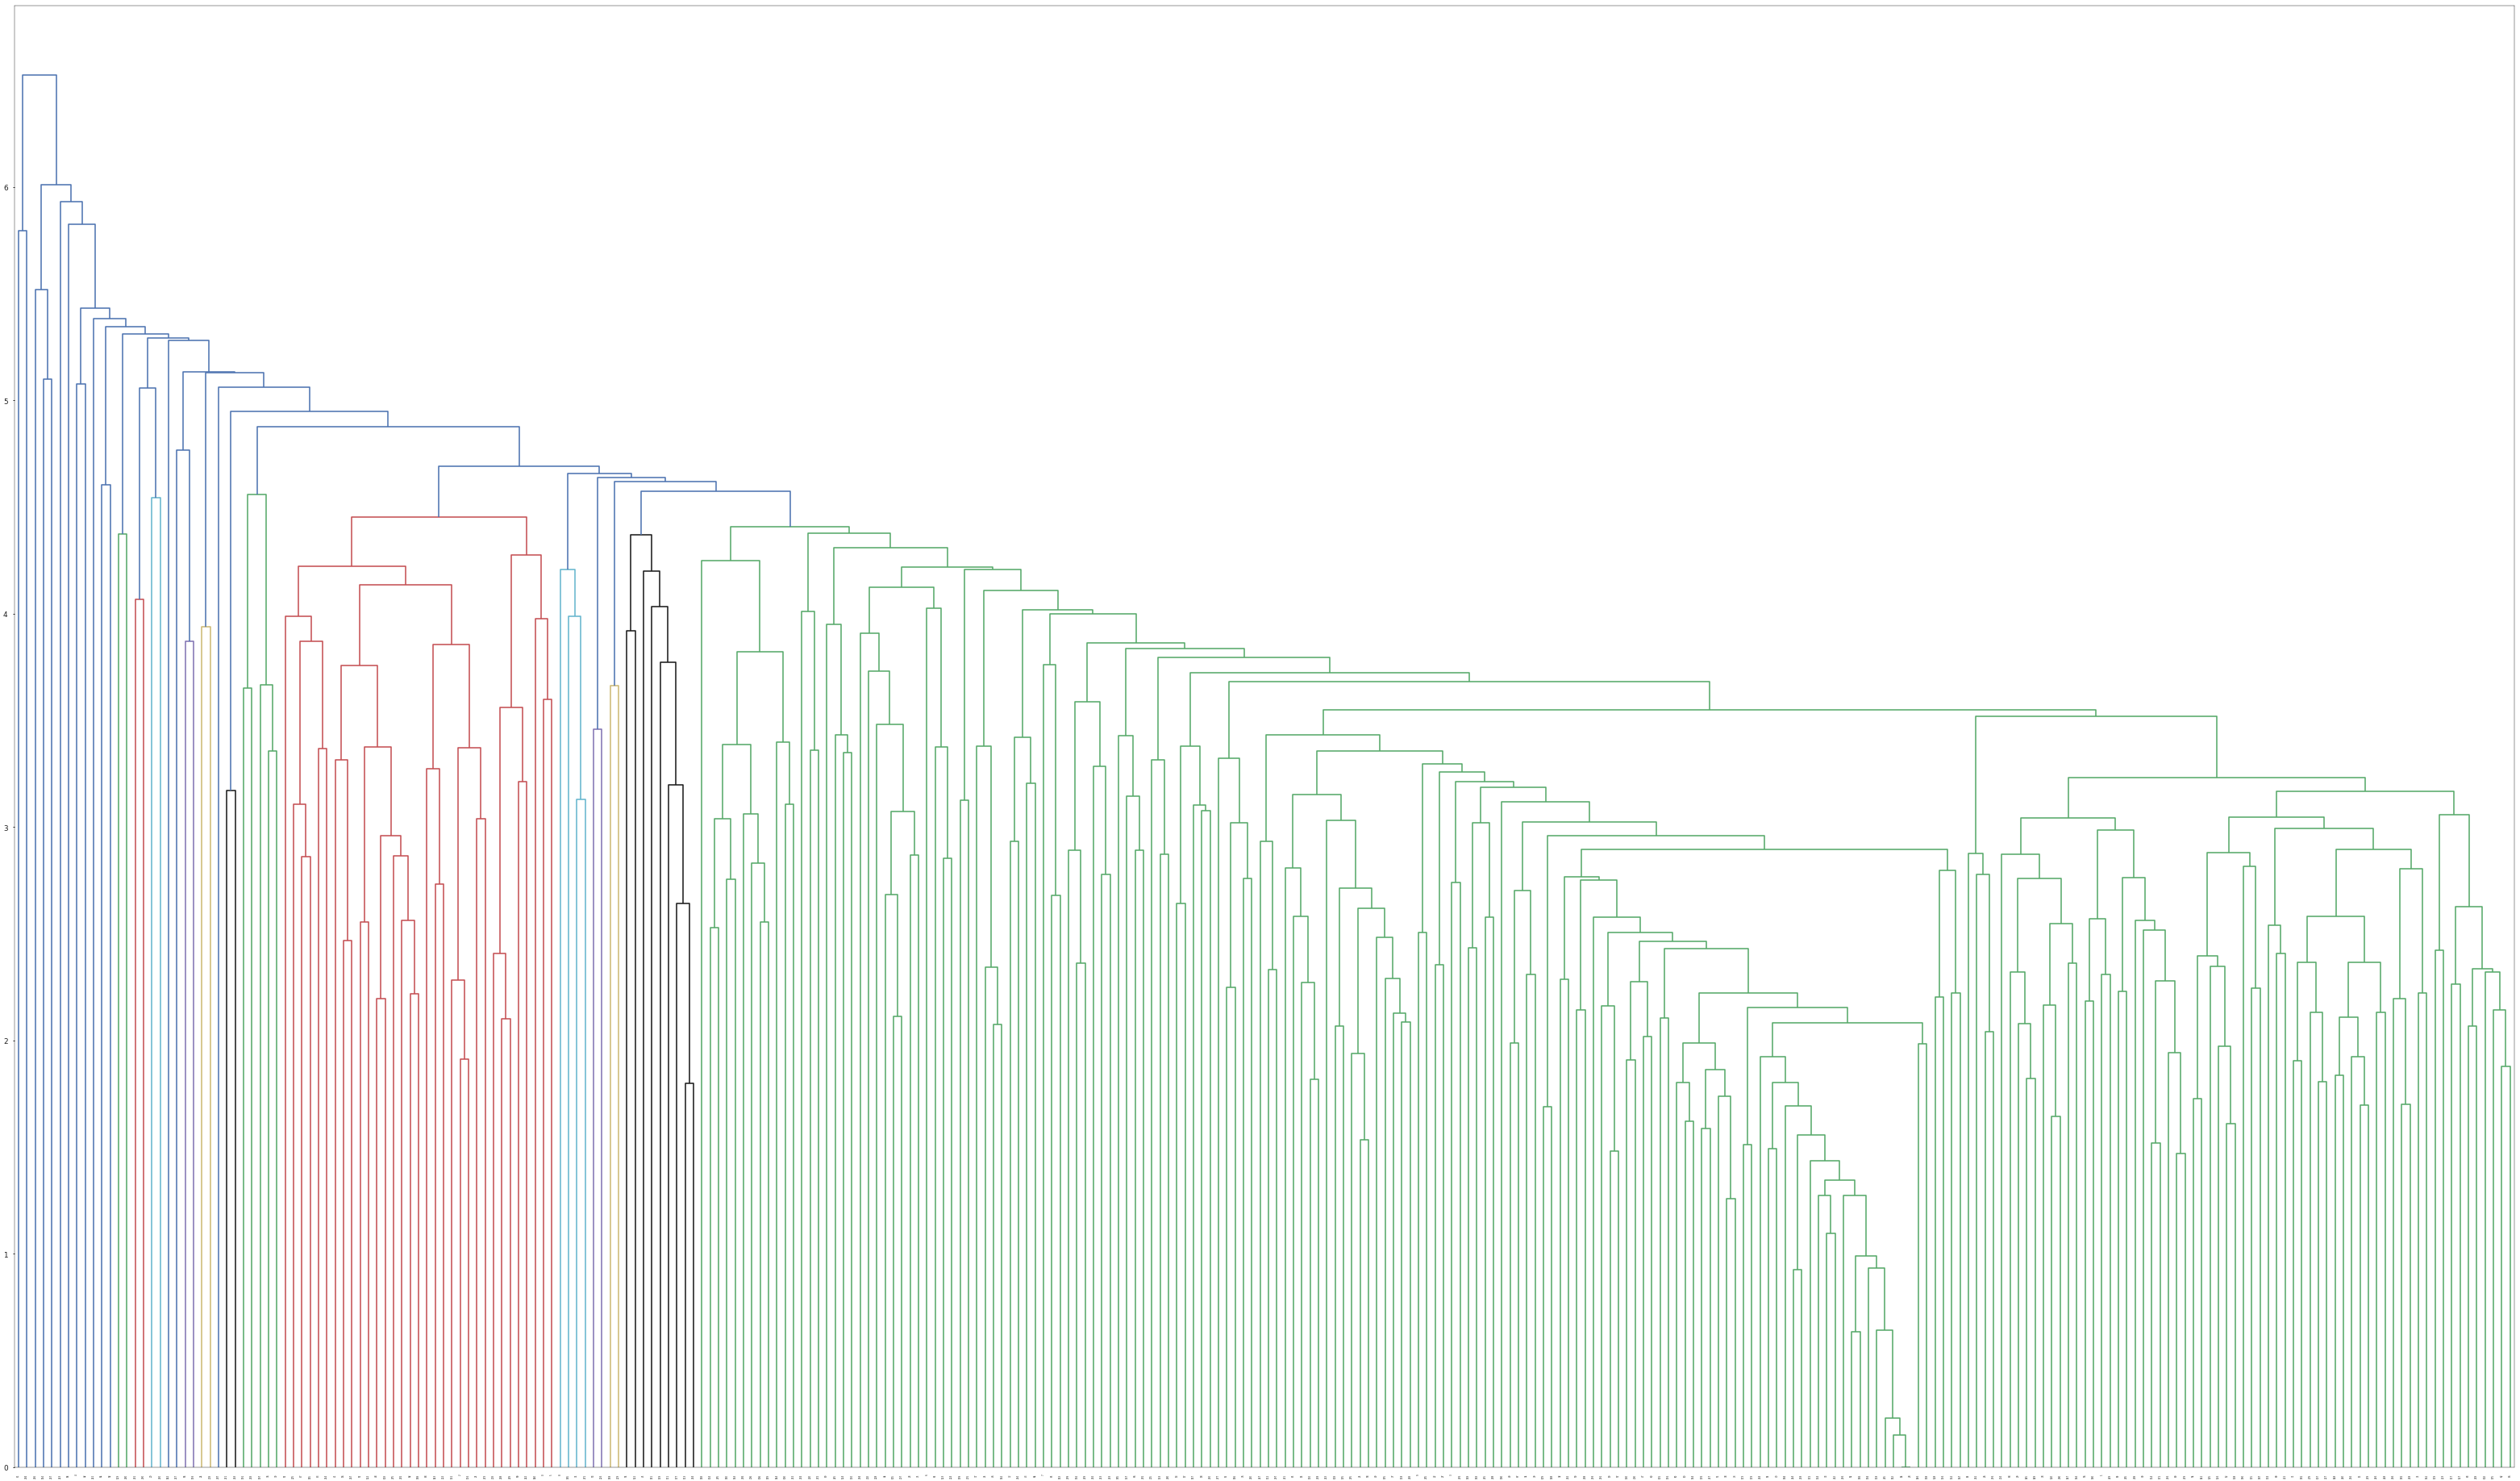

Farine,102 Saint-Viateur Ouest,Montréal,QC
Yummy2Go,Métro Atwater, 3015 Boulevard de Maisonneuve Ouest,Montréal,QC
Le Petit Brûloir,8485 Boulevard Saint-Laurent,Montréal,QC
Bouffe Dave Plant Food,1206 Boulevard de Maisonneuve E,Montréal,QC
Café de' Mercanti,350 Rue Notre-Dame Est,Montréal,QC
Novanta Café,90 Avenue Laurier O,Montréal,QC
Duc de Lorraine,5002 Chemin de la Côte-des-Neiges,Montréal,QC
Tommy,200 Rue Notre-Dame O,Montréal,QC
L'Gros Luxe Plateau,3807 Rue Saint-André,Montréal,QC
Le Ballpark,6660 Rue Clark,Montréal,QC
Café Parvis,433 Rue Mayor,Montréal,QC
Dans la Gueule du Loup,2055 Avenue Laurier E,Montréal,QC
La Rouladerie,1205 Avenue Bernard,Montréal,QC
Le Pier 66,361 Rue Bernard O,Montréal,QC
Le Majestique,4105 Boulevard Saint-Laurent,Montréal,QC
Auberge du Dragon Rouge,8870 Rue Lajeunesse,Montréal,QC
Kaiji Sushi,2115 Jean-Talon Est,Montréal,QC
Kafein Café-Bar,1429A Rue Bishop,Montréal,QC
Green,443 Avenue Viger O,Montréal,QC
Hit Ratio:  0.5
NDCG:  0.775505864984





Recomme

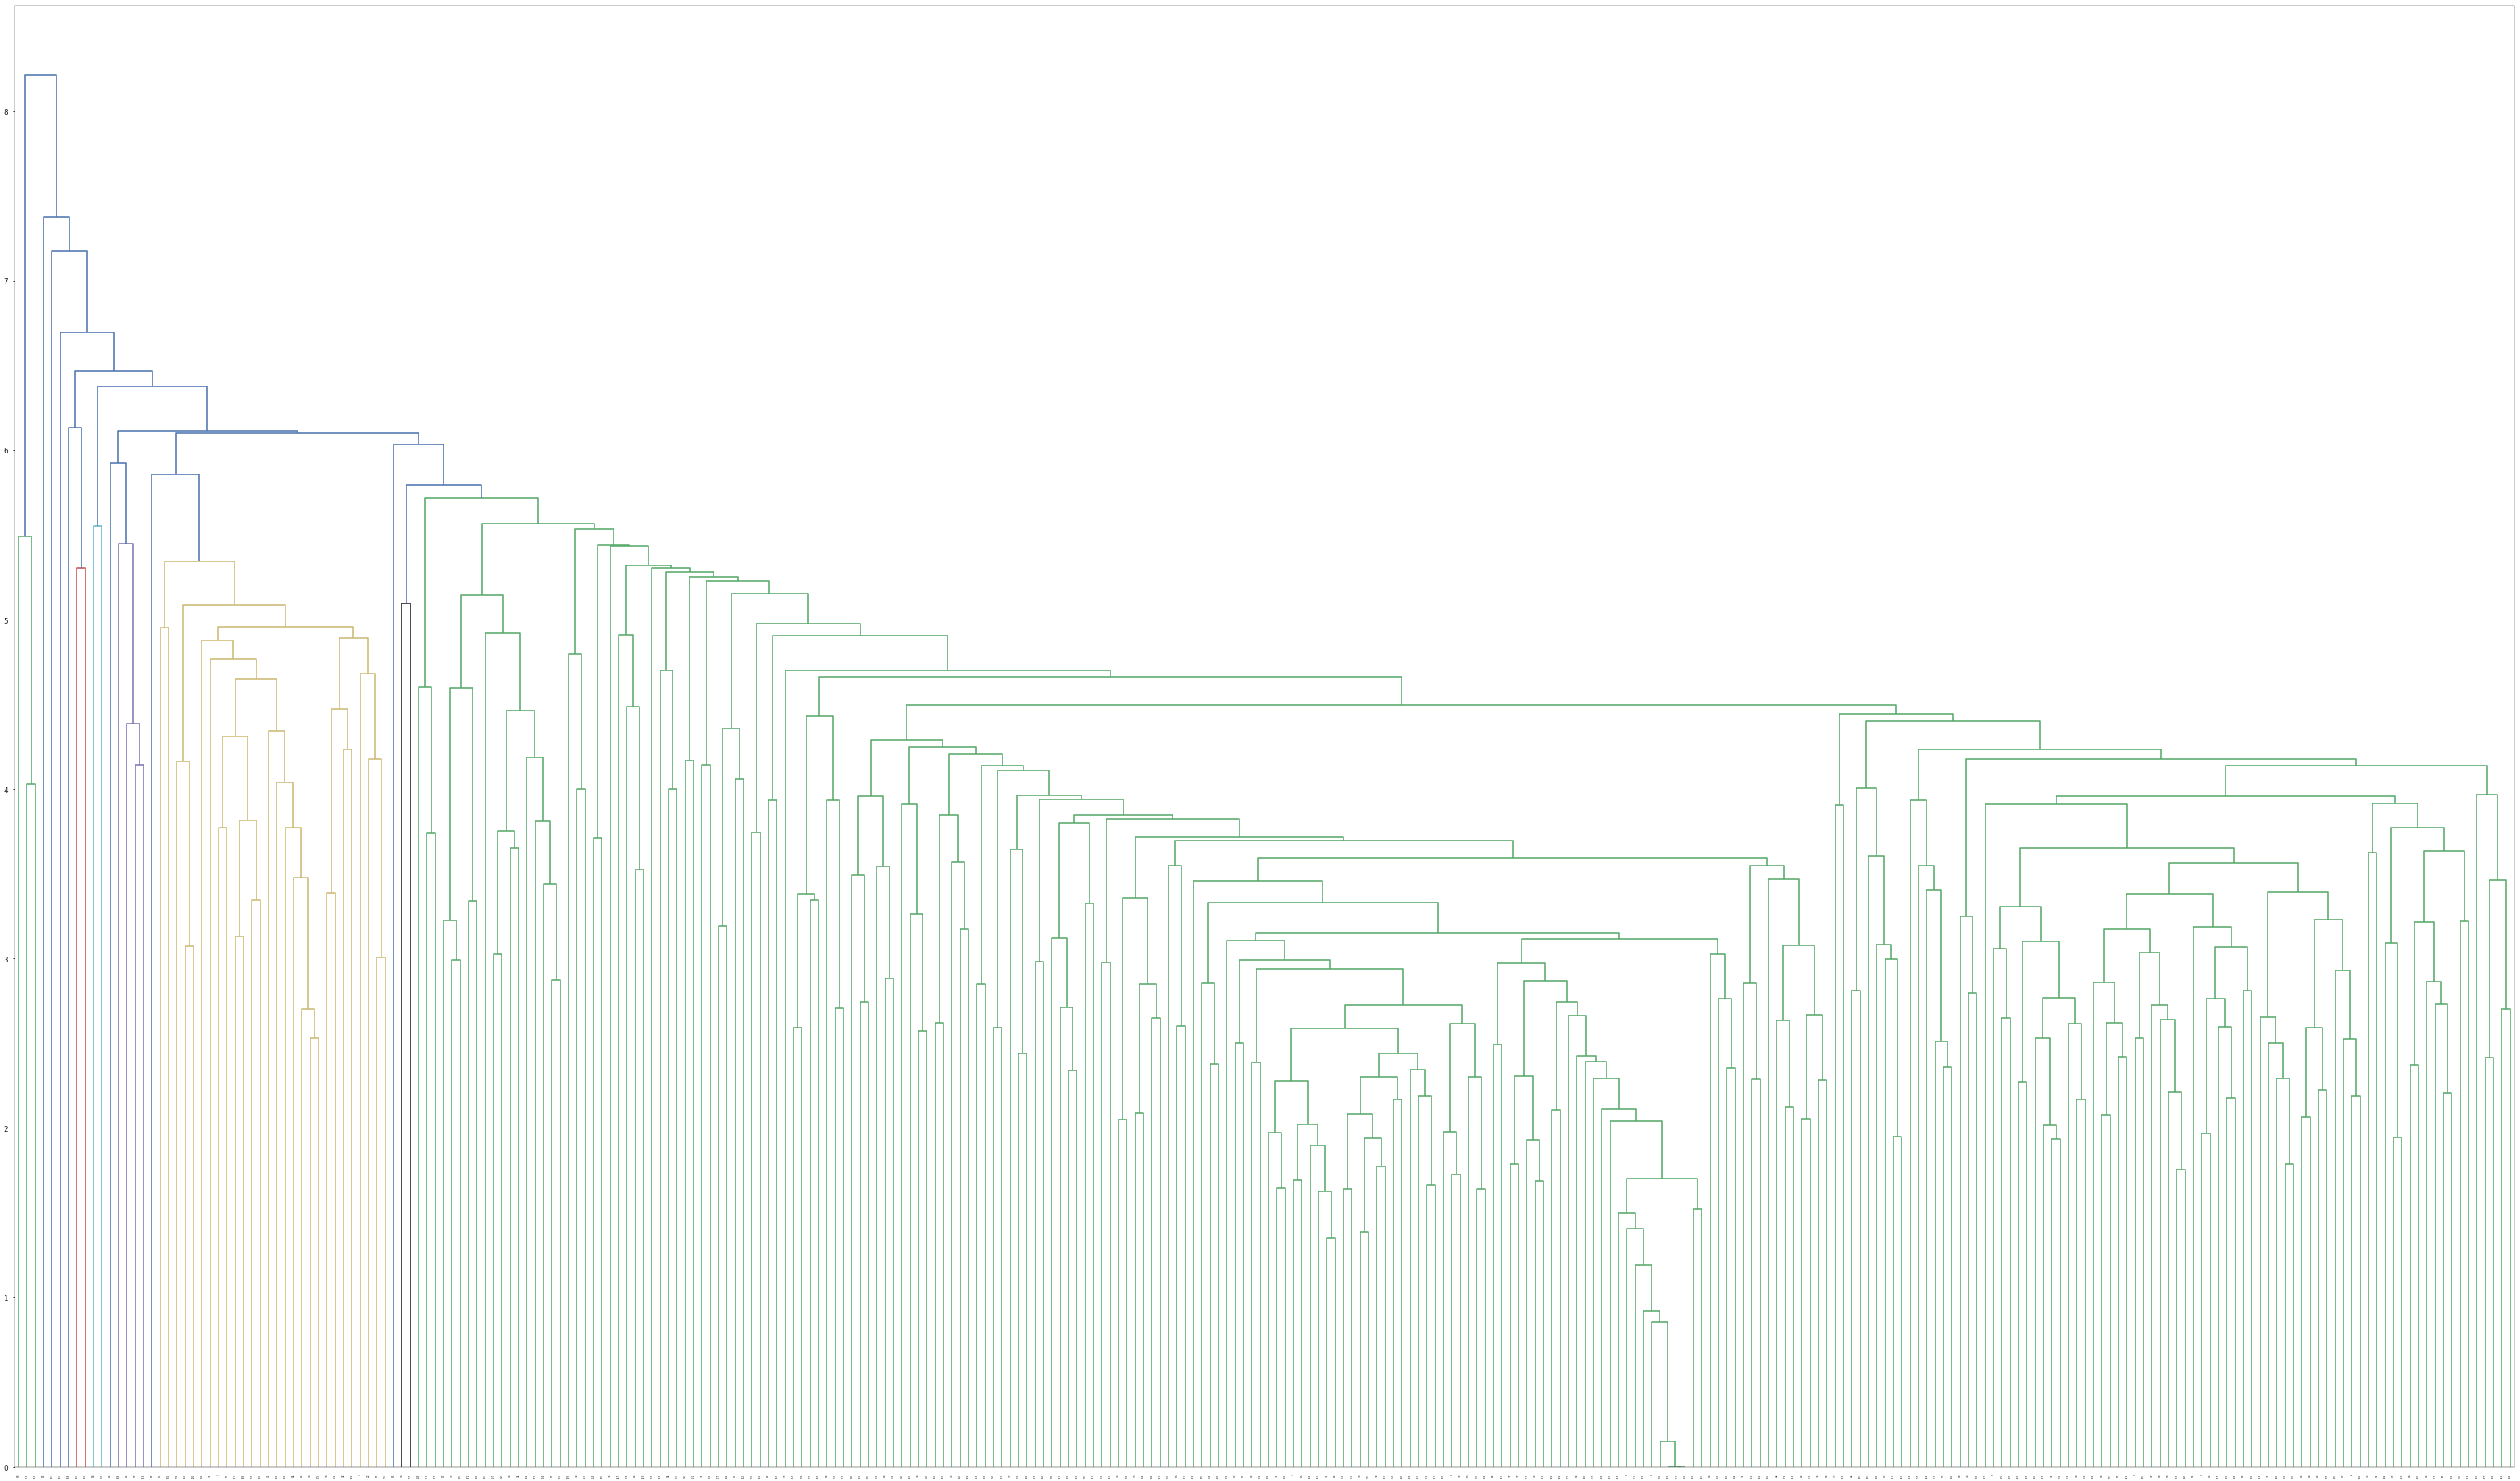

B&R Wine - Food,7366 E Shea Blvd, Ste 112,Scottsdale,AZ
Milk + Honey JCC,12701 N Scottsdale Rd,Scottsdale,AZ
CM2 Pizzeria & Bakeshop,11485 N 136th St,Scottsdale,AZ
The Original Marketplace,7272 E Indian School Rd, Ste 105,Scottsdale,AZ
The Upton,7216 E Shoeman Ln,Scottsdale,AZ
The Living Room,20751 N Pima Rd, Ste 120,Scottsdale,AZ
Mr. Bigg's,7341 E 6th Ave,Scottsdale,AZ
Starfire Grille,11500 N Hayden Rd,Scottsdale,AZ
Snooze An AM Eatery,15054 N Scottsdale Rd, Ste 110 D18,Scottsdale,AZ
D'Lite Healthy On The Go,7337 E Shea Blvd, Ste 100,Scottsdale,AZ
Cafe Monarch,6934 E 1st Ave, Ste 102,Scottsdale,AZ
Tommy V's Urban Kitchen & Bar,7303 E Indian School Rd,Scottsdale,AZ
Sugar Jam Bake Shop & Bistro,7950 E Redfield Rd,Scottsdale,AZ
Rock & Vine Bar and Grill,8900 E Pinnacle Peak Rd, Ste B1,Scottsdale,AZ
Yard House,7014 East Camelback Rd,Scottsdale,AZ
Brio Tuscan Grille,15301 N Scottsdale Rd,Scottsdale,AZ
Hash Kitchen,8777 N Scottsdale Rd,Scottsdale,AZ
Preston's Steakhouse,8700 E Pinnacle Peak

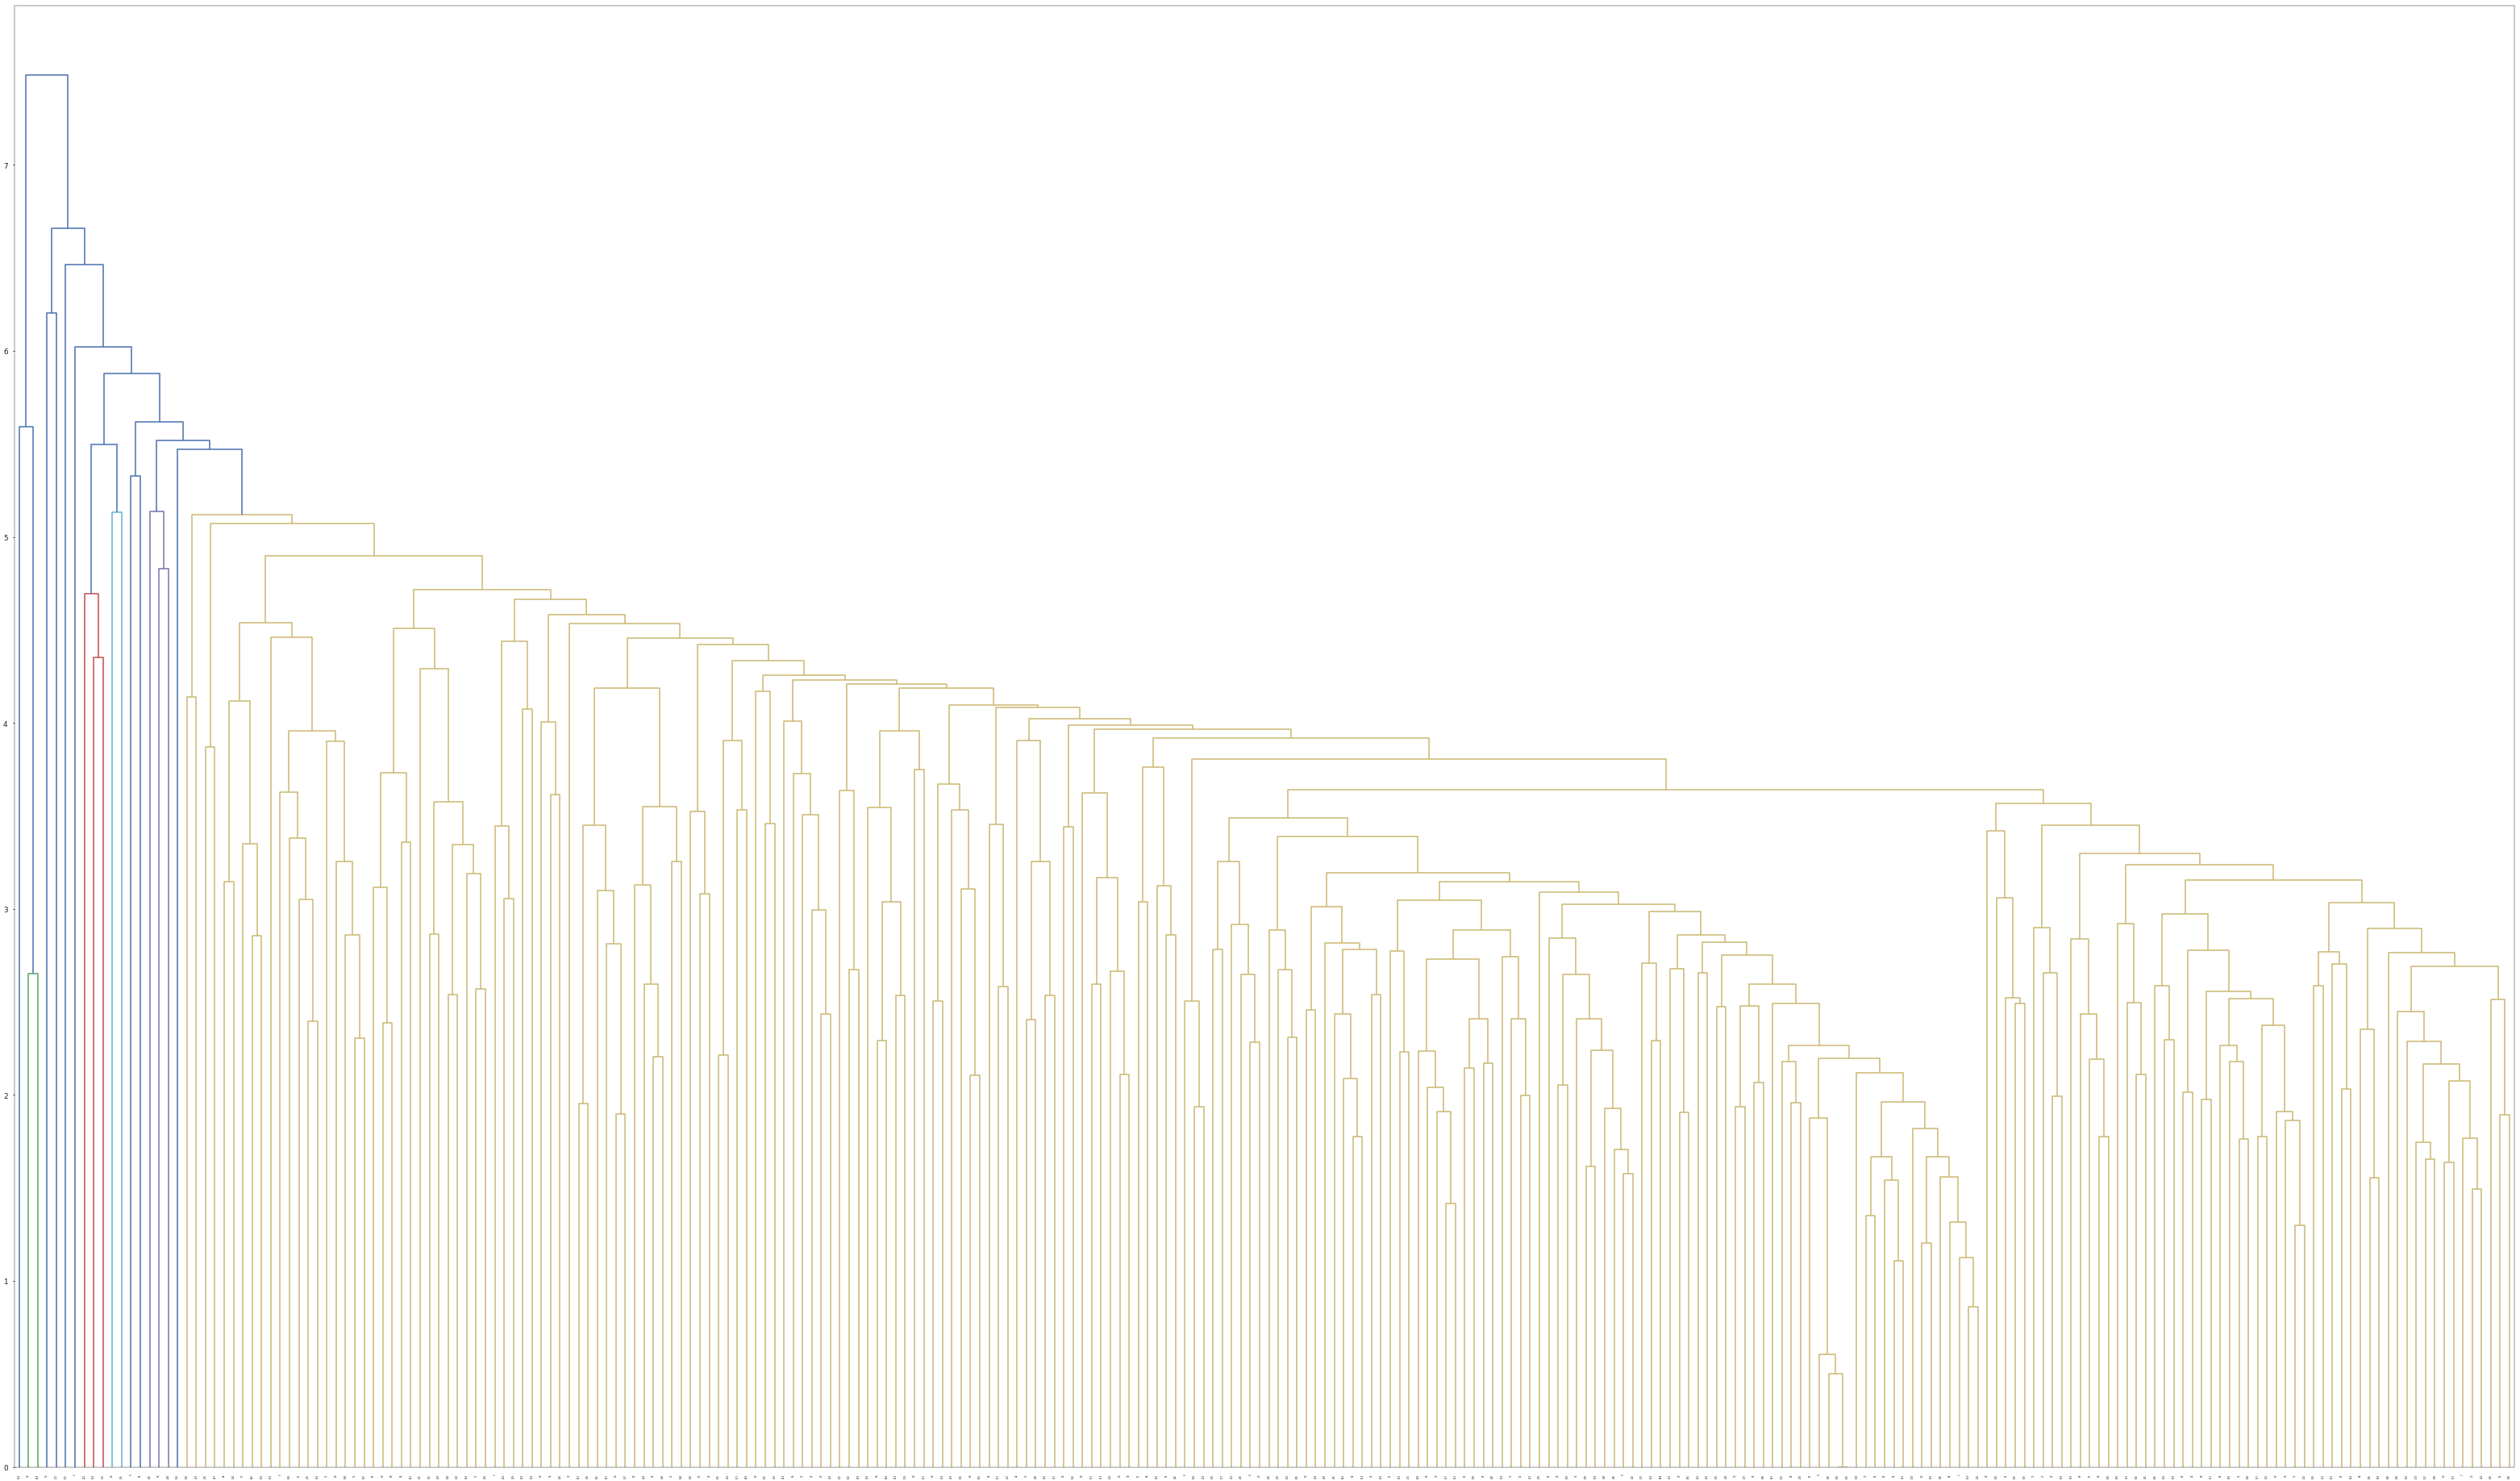

Speedys Grub Shack,14001 Lakewood Heights Blvd,Cleveland,OH
Merchant Street,2391 W 11th St,Cleveland,OH
Flipside,1050 W 10th St,Cleveland,OH
Felice,12502 Larchmere Blvd,Cleveland,OH
Crop Bistro,2537 Lorain Ave,Cleveland,OH
A Bar and Kitchen,850 Euclid Ave, Ste 110,Cleveland,OH
21 Lounge & Kitchen,2123 E 2nd St,Cleveland,OH
Pizza 216,401 Euclid Ave,Cleveland,OH
Stevenson's Bar & Grill,800 E 200th St,Cleveland,OH
Pounders Bar & Grill,6370 York Rd, Ste 5,Cleveland,OH
Hodge's,668 Euclid Ave,Cleveland,OH
Potbelly Sandwich Shop,11425 Euclid,Cleveland,OH
Michelson & Morley,11038 Bellflower Rd,Cleveland,OH
Ontario Street Cafe,2053 Ontario St,Cleveland,OH
Tabletop Board Game Cafe,1810 W 25th St,Cleveland,OH
Knuckleheads,2115 Brookpark Rd,Cleveland,OH
Distefano's Authentic Italian Foods,5600 Highland Rd,Cleveland,OH
Applebee's,20705 Center Ridge Rd,Cleveland,OH
Barristers Deli,1424 Hamilton Ave,Cleveland,OH
Hit Ratio:  0.564102564103
NDCG:  0.907509047117





Recommendation info summary for :  

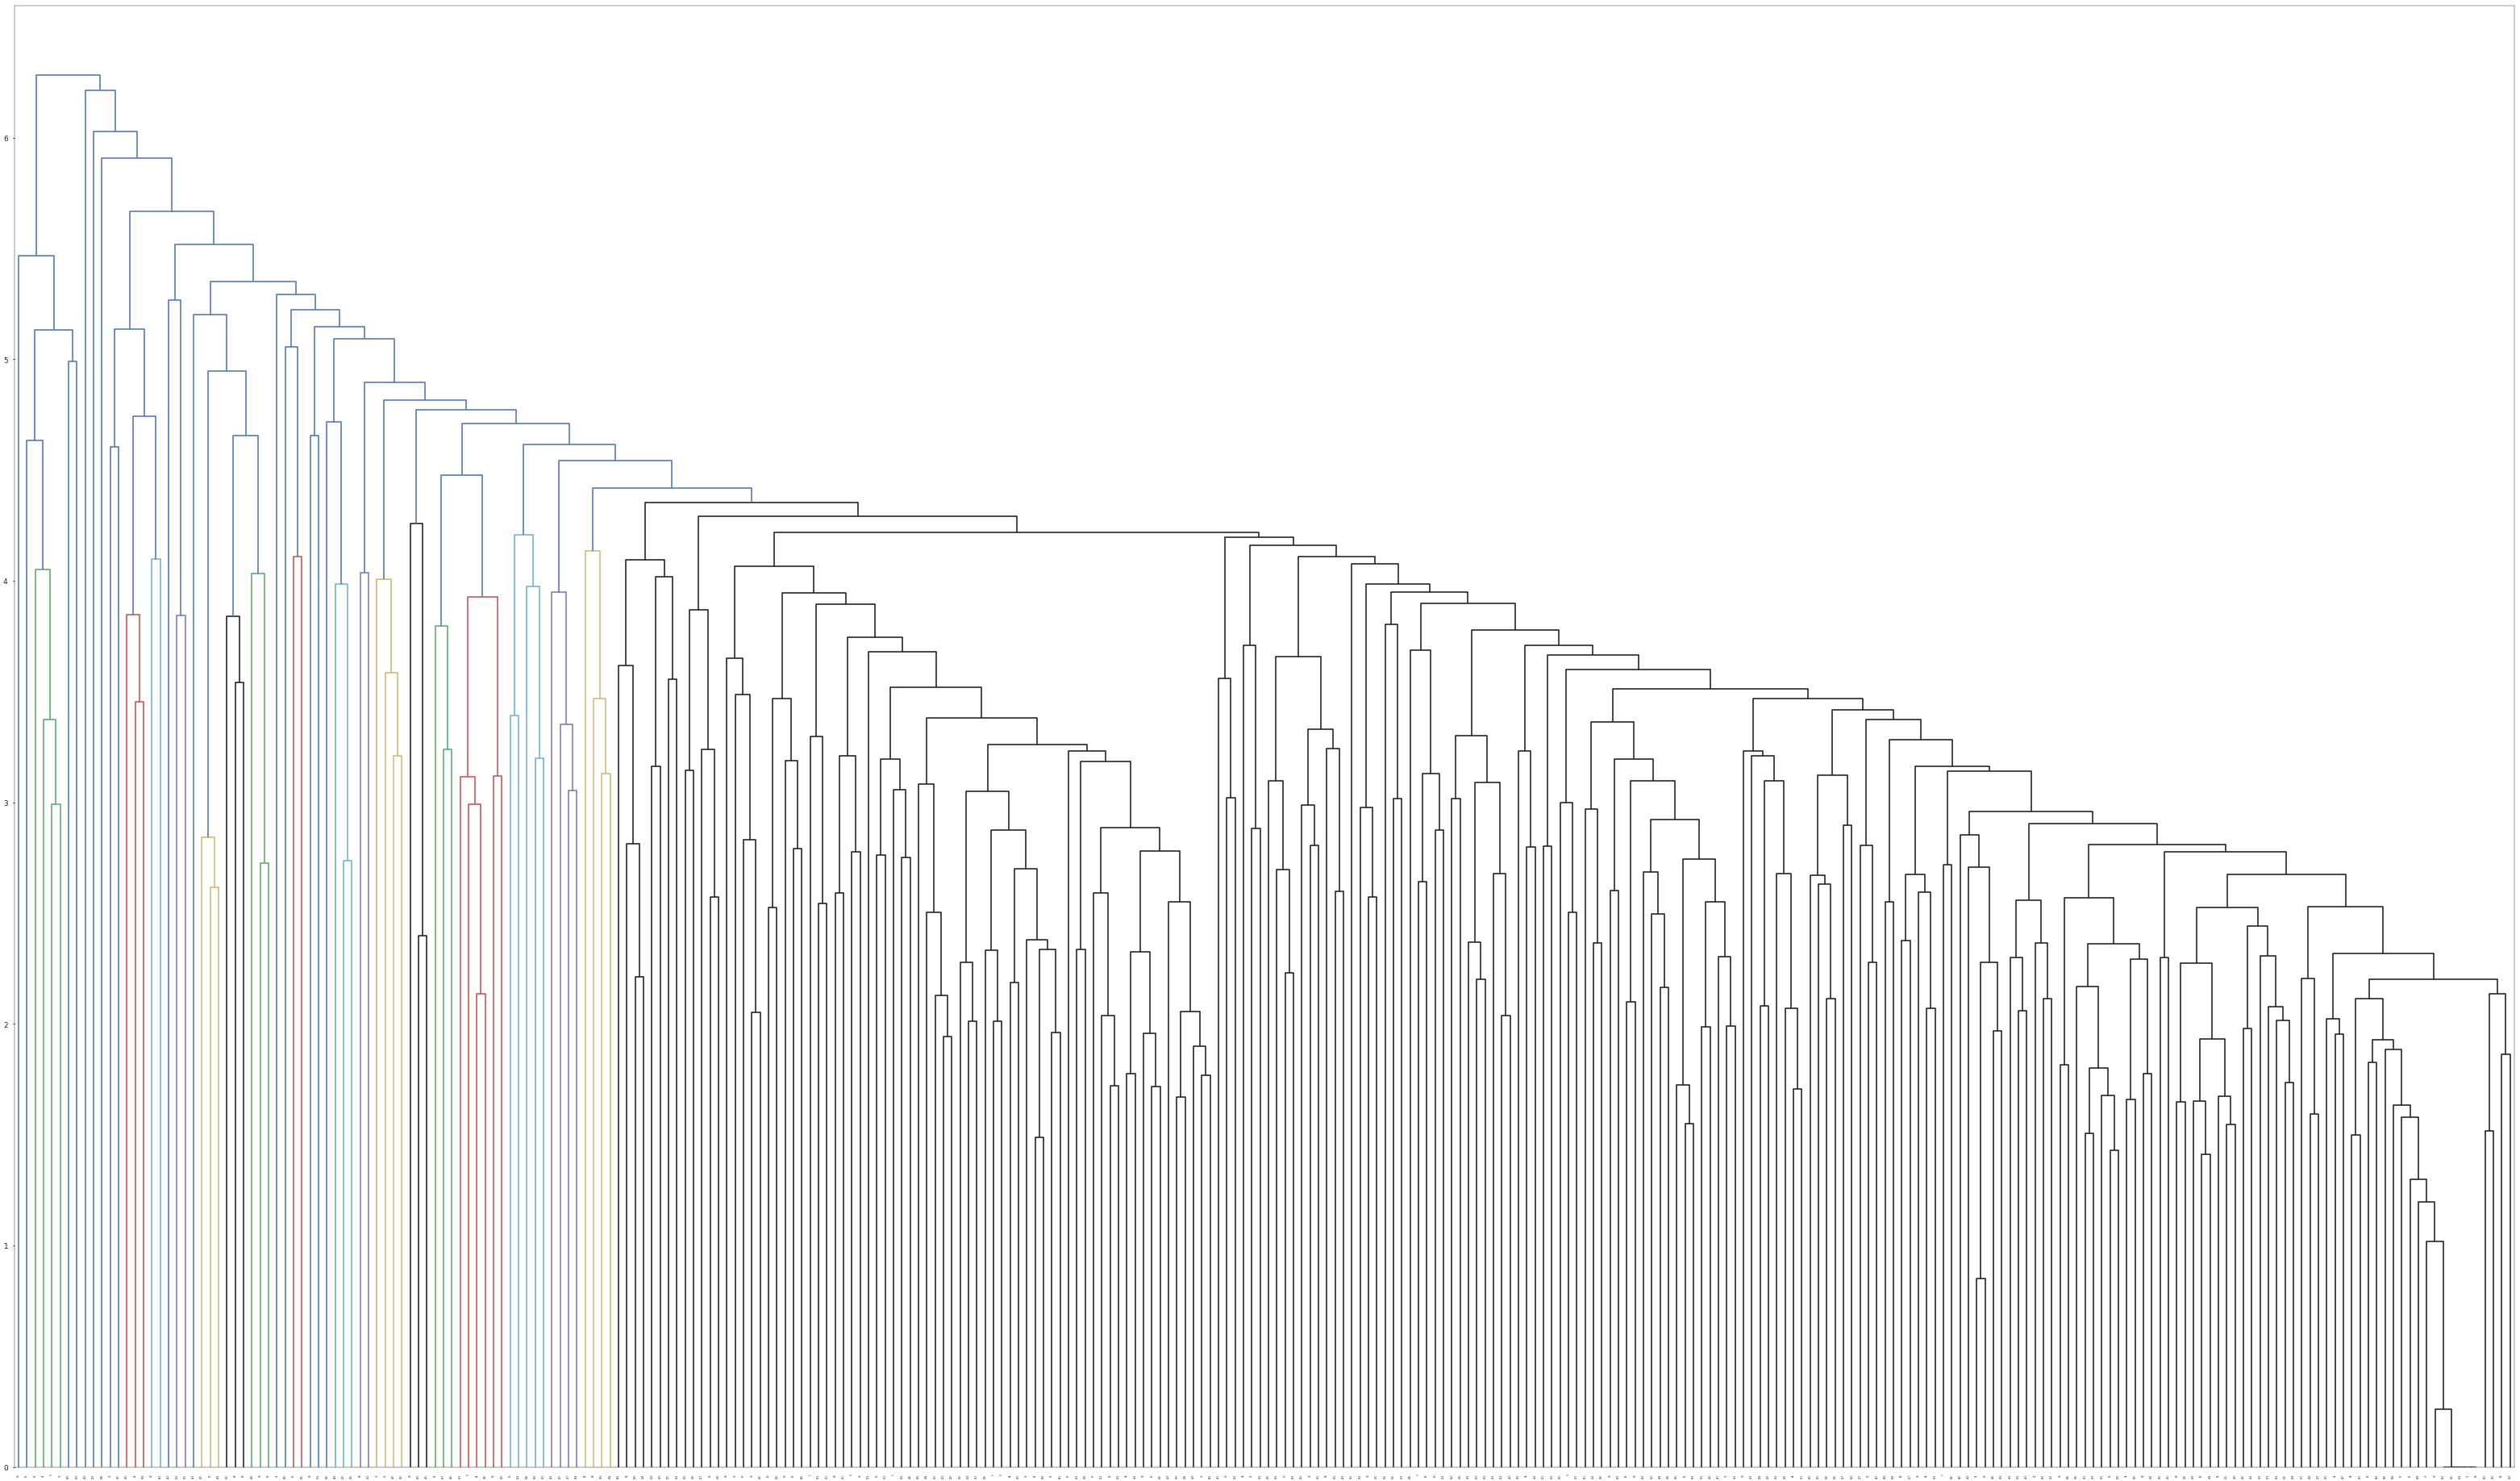

Casetta Kitchen and Counter,222 W Washington Ave, Ste 30,Madison,WI
Manna Cafe & Bakery,611 N Sherman Ave,Madison,WI
The Old Fashioned,23 N Pinckney St,Madison,WI
Johnson Public House,908 E Johnson St,Madison,WI
Brothers Three Bar & Grill,614 N Fair Oaks Ave,Madison,WI
The Great Dane,123 E Doty St,Madison,WI
Merchant Madison,121 S Pinckney St,Madison,WI
Der Rathskeller,800 Langdon St,Madison,WI
Mickey's Tavern,1524 Williamson St,Madison,WI
Sí Café,117 S Pinckney St,Madison,WI
Highland Espresso Bar,45 S Bassett St,Madison,WI
Great Harvest Bread,3258 University Ave,Madison,WI
Village Bar,3801 Mineral Point Rd,Madison,WI
Hail Mary Sports Grill,401 E Washington Ave,Madison,WI
Jordan's Big Ten Pub,1330 Regent St,Madison,WI
Granite City Food & Brewery,72 West Towne Mall,Madison,WI
Ironworks Cafe,149 Waubesa St,Madison,WI
Next Door Brewing Company,2439 Atwood Ave,Madison,WI
Gates & Brovi,3502 Monroe St,Madison,WI
Hit Ratio:  0.638888888889
NDCG:  0.78594872125





Recommendation info summary

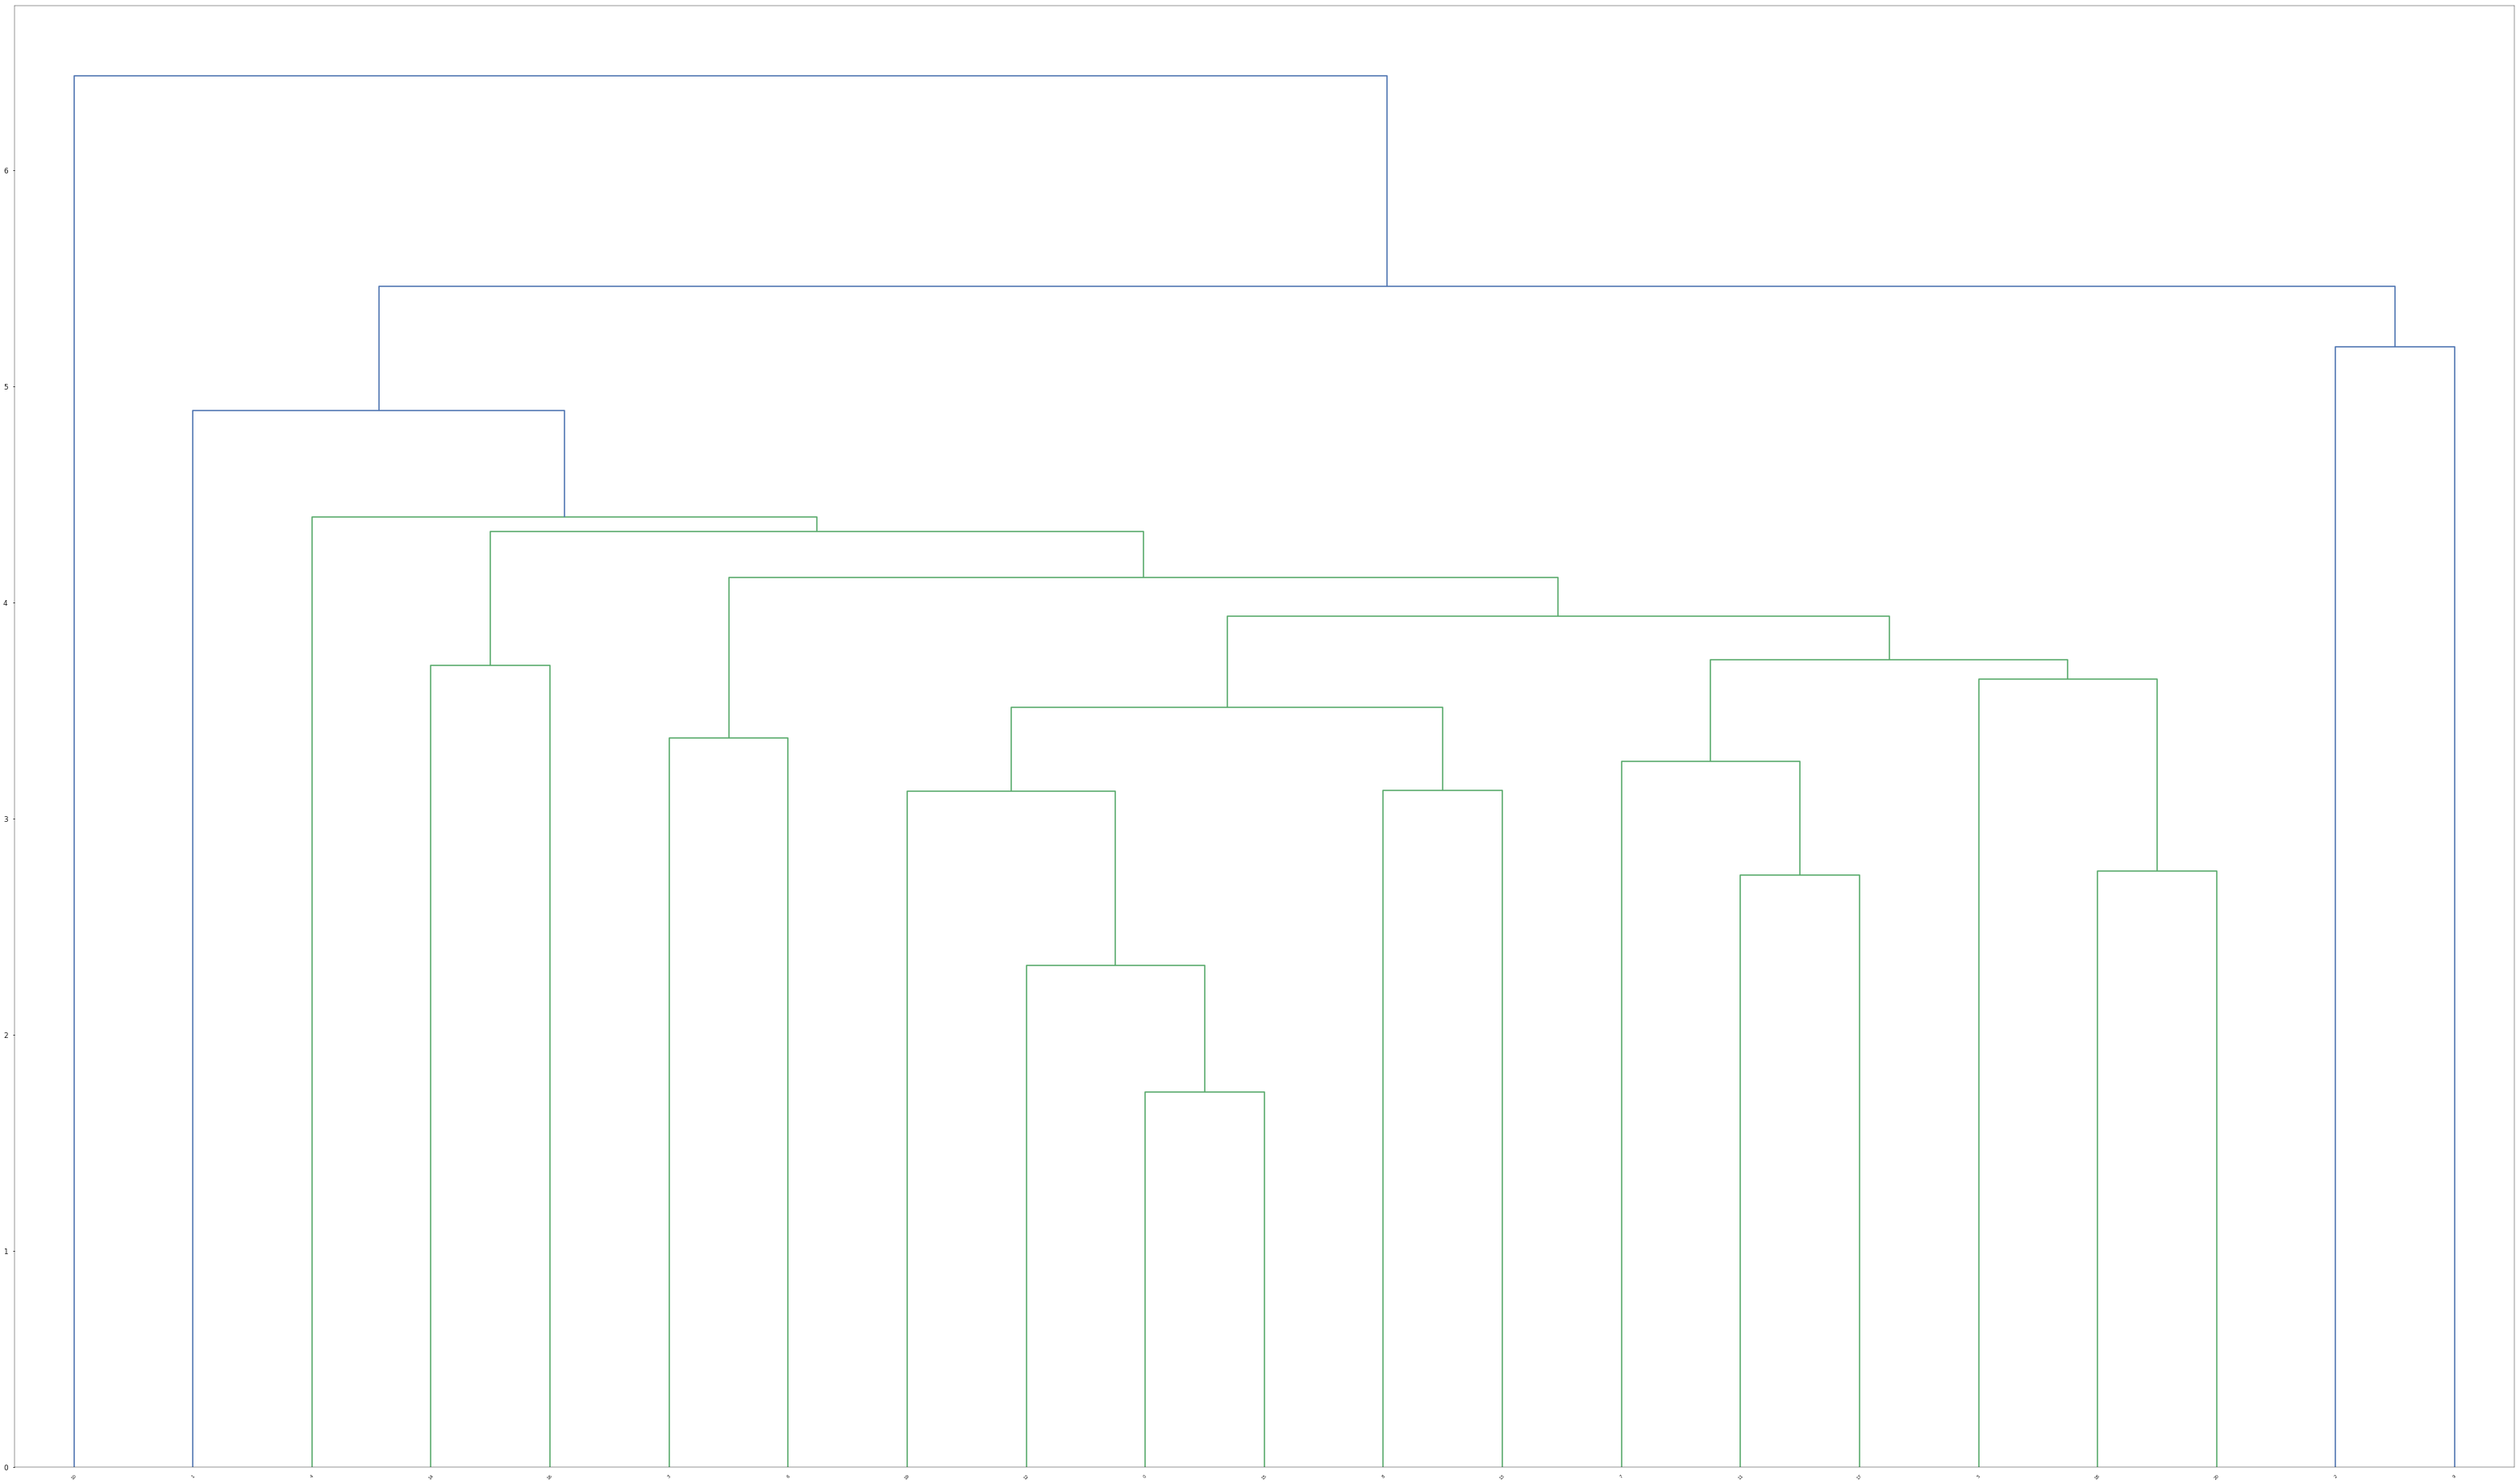

Weinstube Lamm,Mühlstr. 24,Stuttgart,BW
Mögle,Dieterlestr. 32,Stuttgart,BW
Weinstube Vetter,Bopserstr. 18,Stuttgart,BW
Stöckle,Johannesstr. 76,Stuttgart,BW
Wein-Musketier,Julius-Hölder-Str. 29 B,Stuttgart,BW
Amadeus Restaurant & Bar,Charlottenplatz 17,Stuttgart,BW
Stäffele,Buschlestr. 2 A,Stuttgart,BW
Herr Kächele,Calwer Passage,Stuttgart,BW
Heslacher Weinstube,Böcklerstr.18,Stuttgart,BW
Knausbira Stüble,Heumadener Str. 15,Stuttgart,BW
Weinstube Viertelesschlotzer,Forststr. 57,Stuttgart,BW
Punto fisso,Christophstr. 14,Stuttgart,BW
Weinstube Cafe Löwen,Trollingerstr. 4,Stuttgart,BW
El Camino,Marbacher Str. 18,Stuttgart,BW
Délice,Hauptstätter Str. 61,Stuttgart,BW
Weinstube Schellenturm,Weberstr. 72,Stuttgart,BW
Ulmers Besenwirtschaft,Langobardenstr. 30,Stuttgart,BW
Weinstube zum Tröpfle,Zabergäustr. 73,Stuttgart,BW
Weinstube Klösterle,Marktstr. 71,Stuttgart,BW
Hit Ratio:  0.5
NDCG:  0.725925925926





Recommendation info summary for :  Mesa
number of valid user:  264
number of valid tes

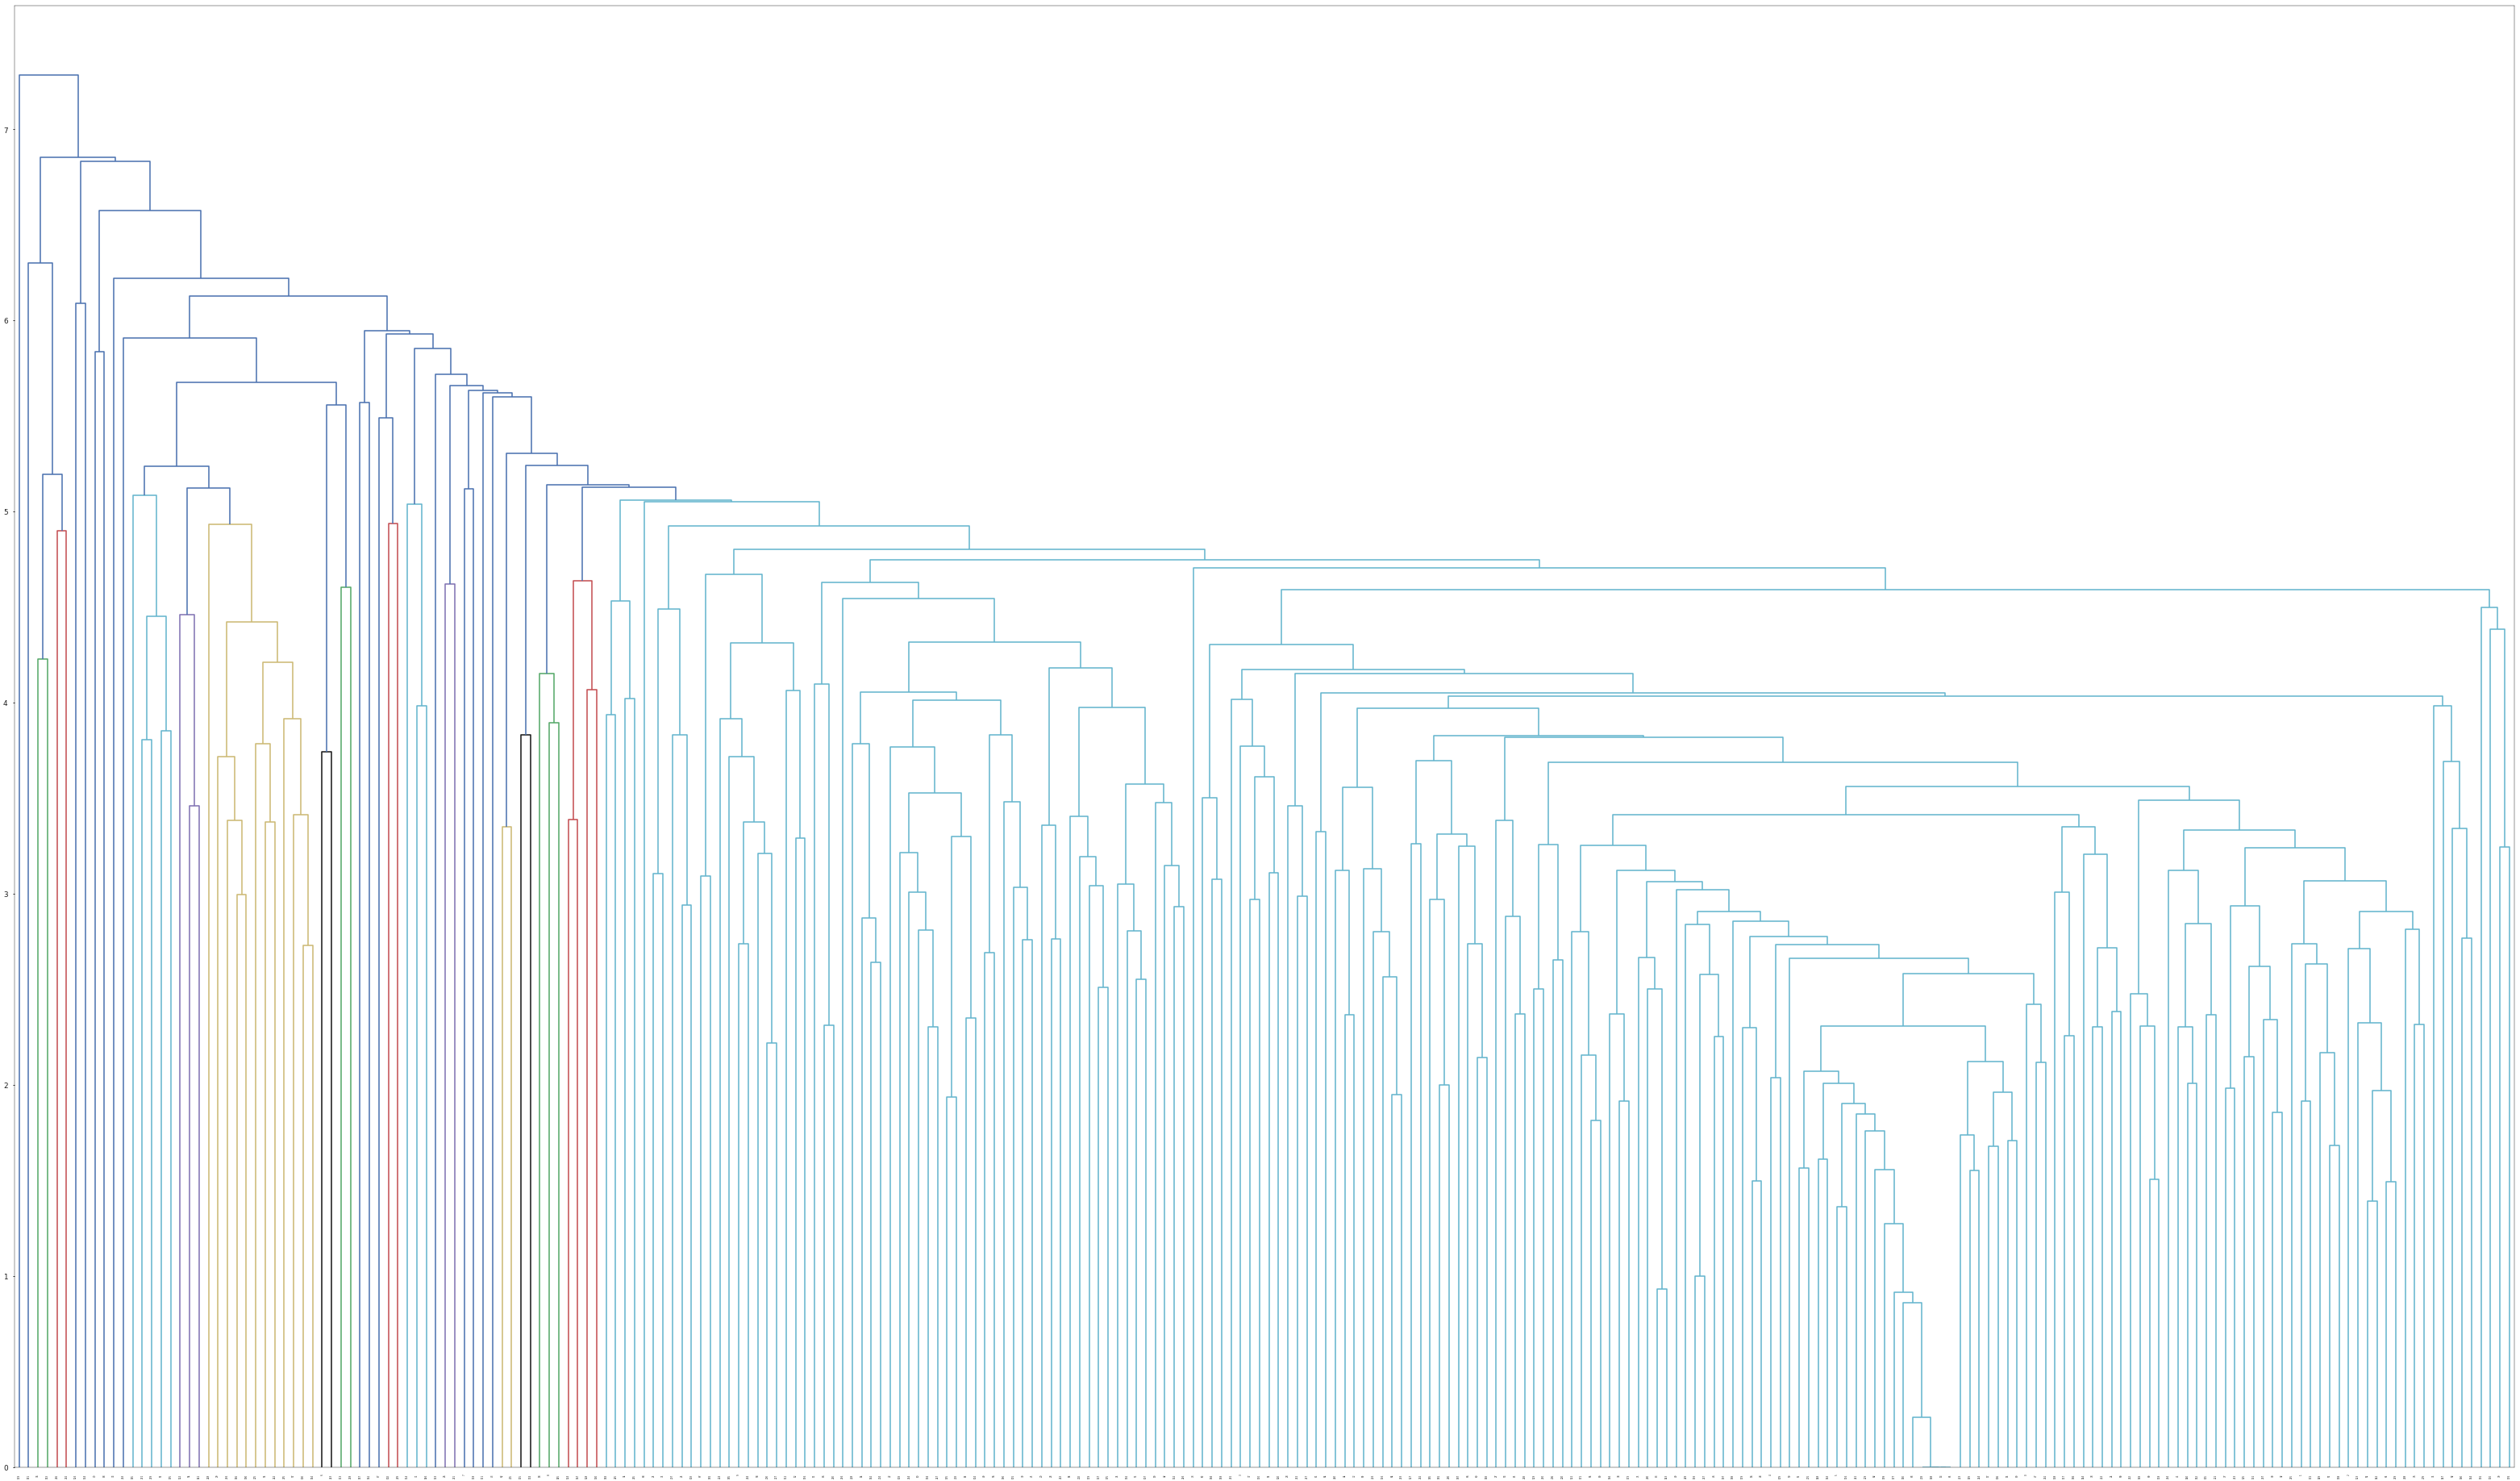

The Oak Room,61 E University Dr,Mesa,AZ
Old Chicago,1656 S Alma School Rd,Mesa,AZ
Miele's Italian and Banquet Hall,2050 W Guadalupe Rd, Ste 9,Mesa,AZ
Flip's Burgers & Brews,805 N Dobson Rd, Ste 101,Mesa,AZ
Native Grill & Wings,318 E. Brown Rd #112,Mesa,AZ
1360 West Grill,1360 W Southern Ave,Mesa,AZ
Eklectic Pie - Mesa,1859 S Stapley Dr, Ste 105-3,Mesa,AZ
Bricks Family Sports Grill,2235 S Power Rd, Ste 127,Mesa,AZ
Urban Heat,1749 W Main St,Mesa,AZ
Boca Taqueria,1249 N Greenfield Rd, Ste 104,Mesa,AZ
Mesa Drummer,1211 N Country Club, Ste 9,Mesa,AZ
The Hub Grill and Bar,1925 S Sossaman Rd,Mesa,AZ
Fat Willy's,2250 S Buttercup Rd,Mesa,AZ
Cafe Agit,1954 S Dobson Rd, Ste 5,Mesa,AZ
Cracker Barrel Old Country Store,1007 N Dobson Rd,Mesa,AZ
Salad and Go,5259 E Brown Rd,Mesa,AZ
Pineapple Grill,4545 E McKellips Rd, Ste C108,Mesa,AZ
Modern Grove,1958 E Brown Rd, Ste 103,Mesa,AZ
Planet Sub Mesa-Grand,1641 S Stapley Dr, Ste 101,Mesa,AZ
Hit Ratio:  0.371428571429
NDCG:  0.506748783272





Recommendati

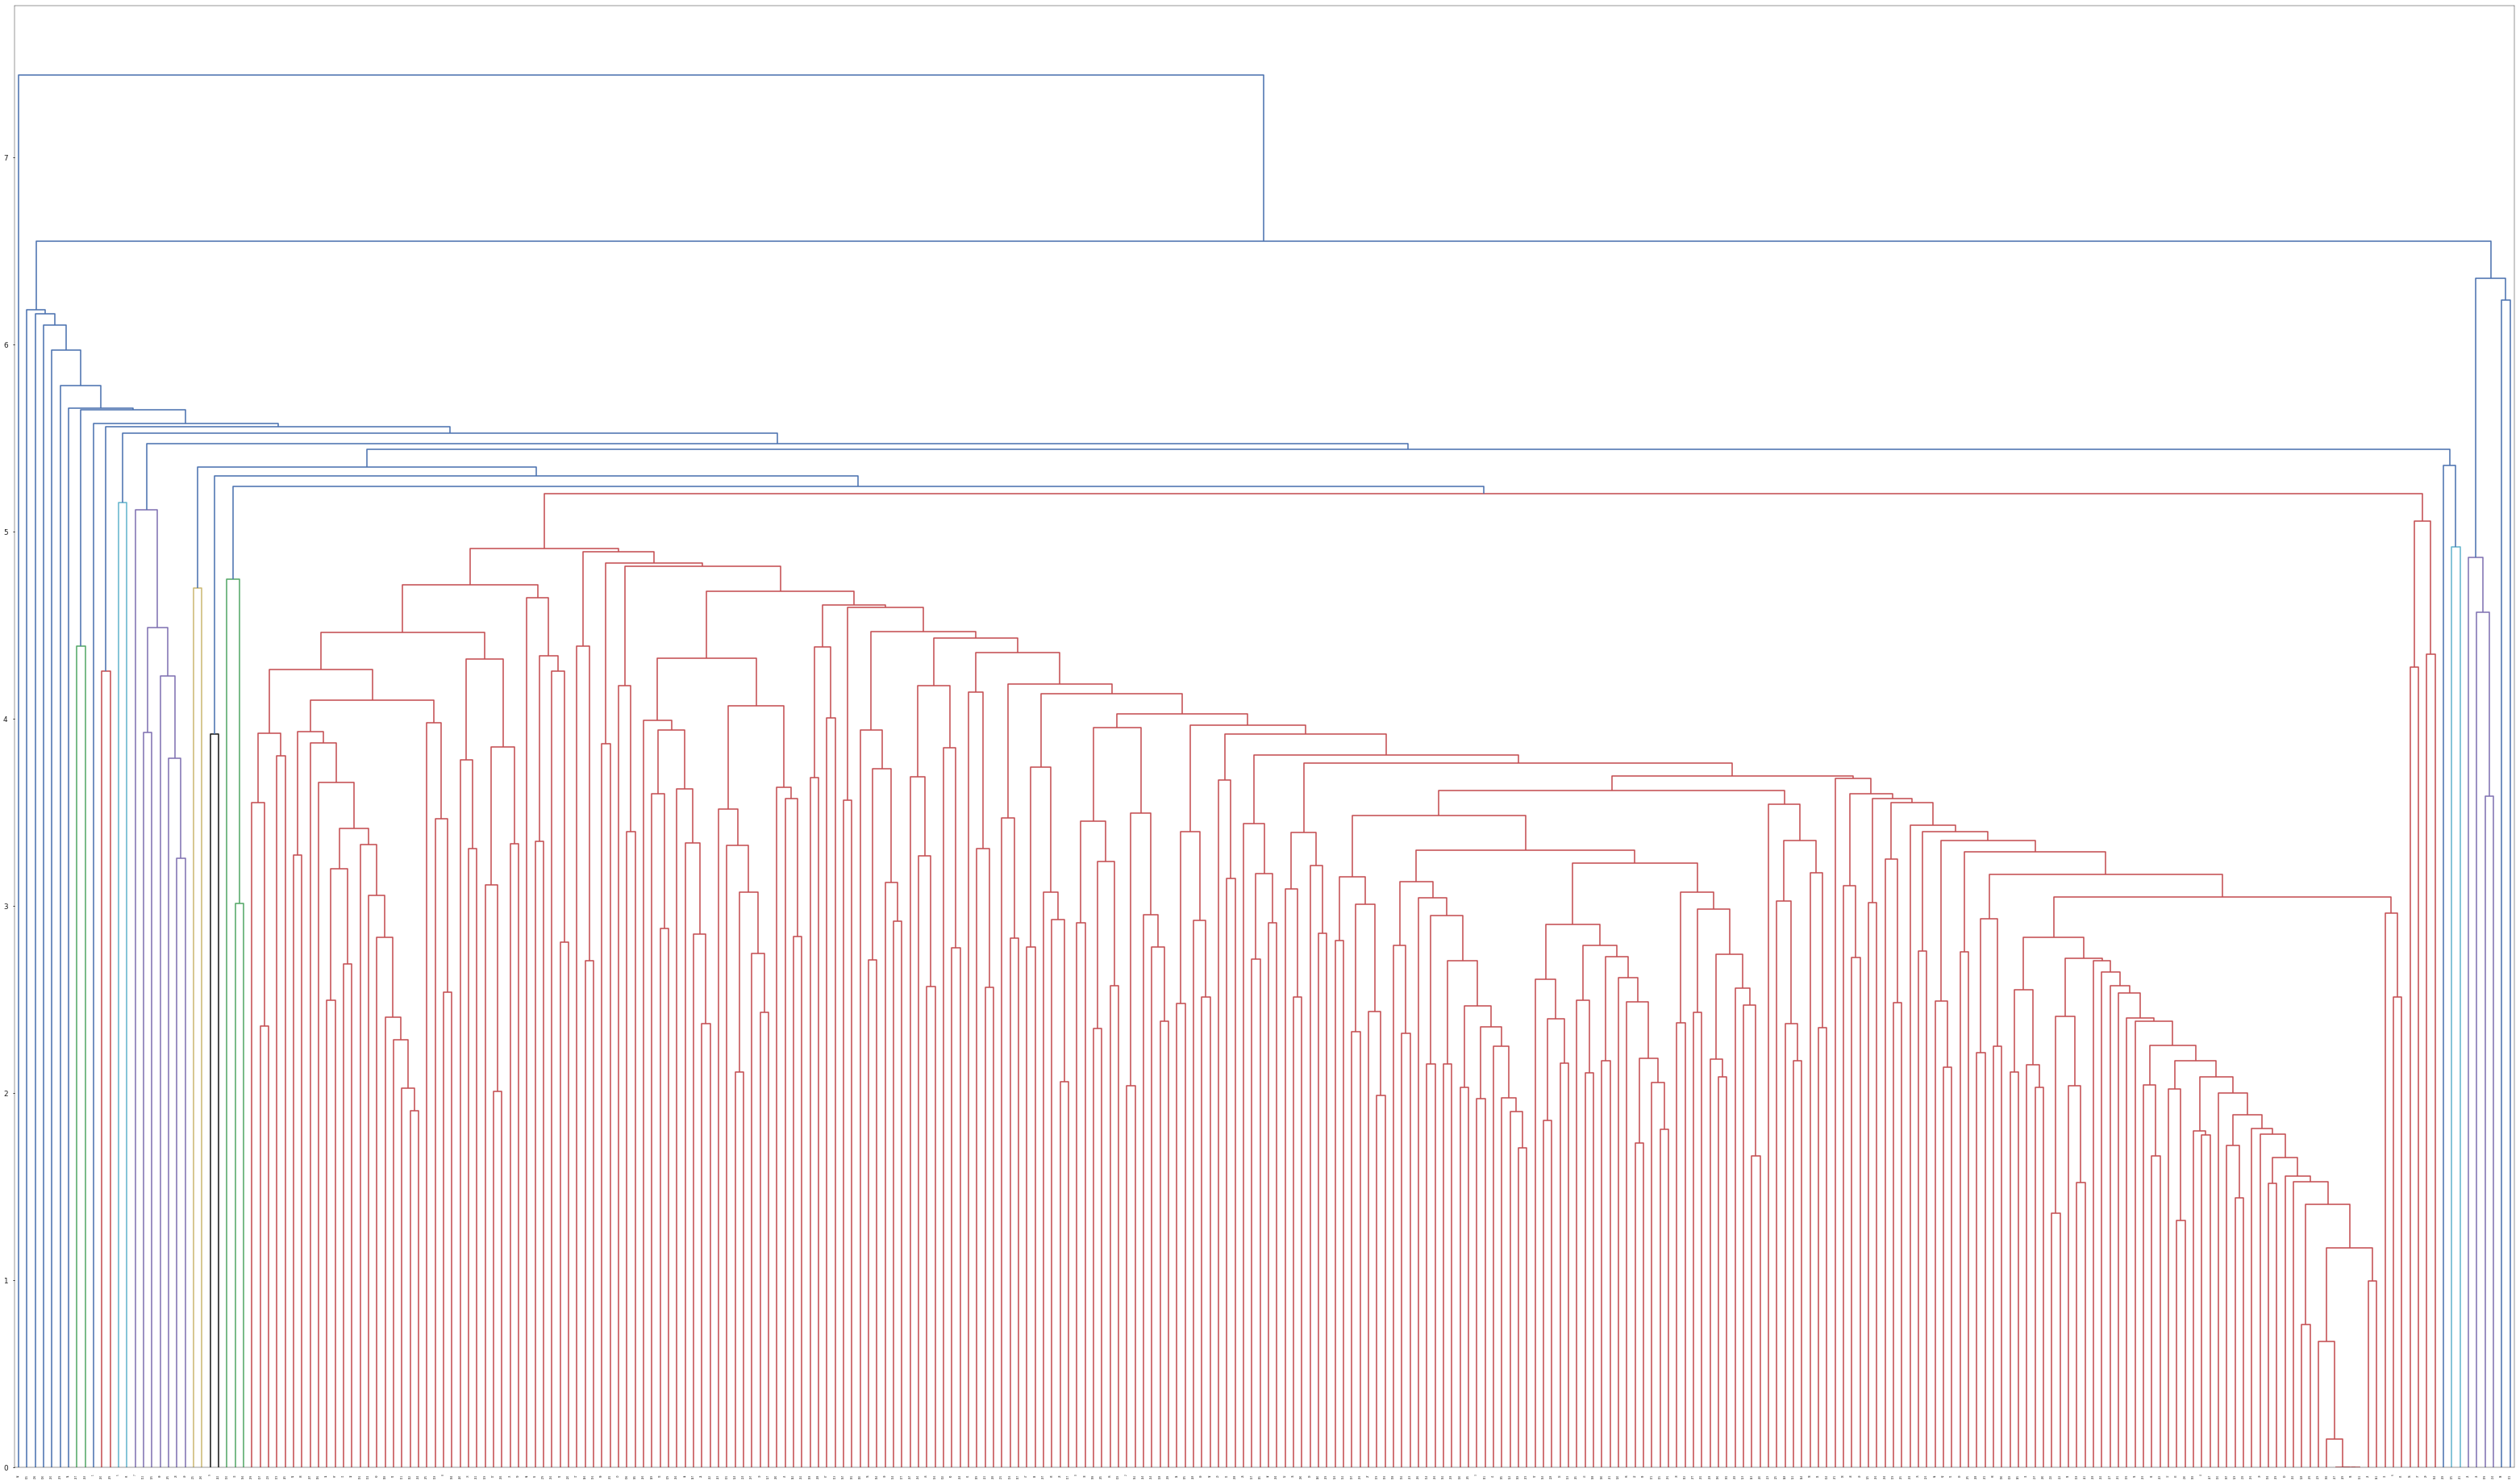

Salut Kitchen Bar,1435 E University Dr, Ste 12,Tempe,AZ
1865 Coffee,40 E University Dr,Tempe,AZ
Pier 54,5394 S Lakeshore Dr,Tempe,AZ
Steve's Espresso,1801 E Baseline Rd, Ste 102,Tempe,AZ
Moroccan Paradise,1212 E Apache Blvd,Tempe,AZ
Noodles & Company,2000 E Rio Salado Pkwy,Tempe,AZ
Sweet Dessert Café,715 W Baseline Rd, Ste 2,Tempe,AZ
Perfect Pear Bistro,9845 S Priest Dr,Tempe,AZ
Devil's Advocate,955 E University Dr,Tempe,AZ
Munch A Lunch,1403 W 10th Pl, Ste B105,Tempe,AZ
Pitchforks & Corks,660 S College Ave, Fl 2,Tempe,AZ
LaGattara Cat Cafe,1301 E University Dr, Ste 136,Tempe,AZ
Supreme Lunch Break,455 S 48th St, Ste 110,Tempe,AZ
The Mission at Minder Binder,715 S Mcclintock Dr,Tempe,AZ
Stray Cat Bar & Grill,2433 E University Dr,Tempe,AZ
Final Round Sports Bar & Grill,5030 S Mill Ave, Ste D20-21,Tempe,AZ
Lucy's Fountainhead Cafe,1501 W Fountainhead Pkwy, Ste 140,Tempe,AZ
Snooze An AM Eatery,615 S College Ave, Ste 103,Tempe,AZ
Vertigo Hookah Lounge & Cafe,1320 E Broadway Rd, Ste 102,Tem

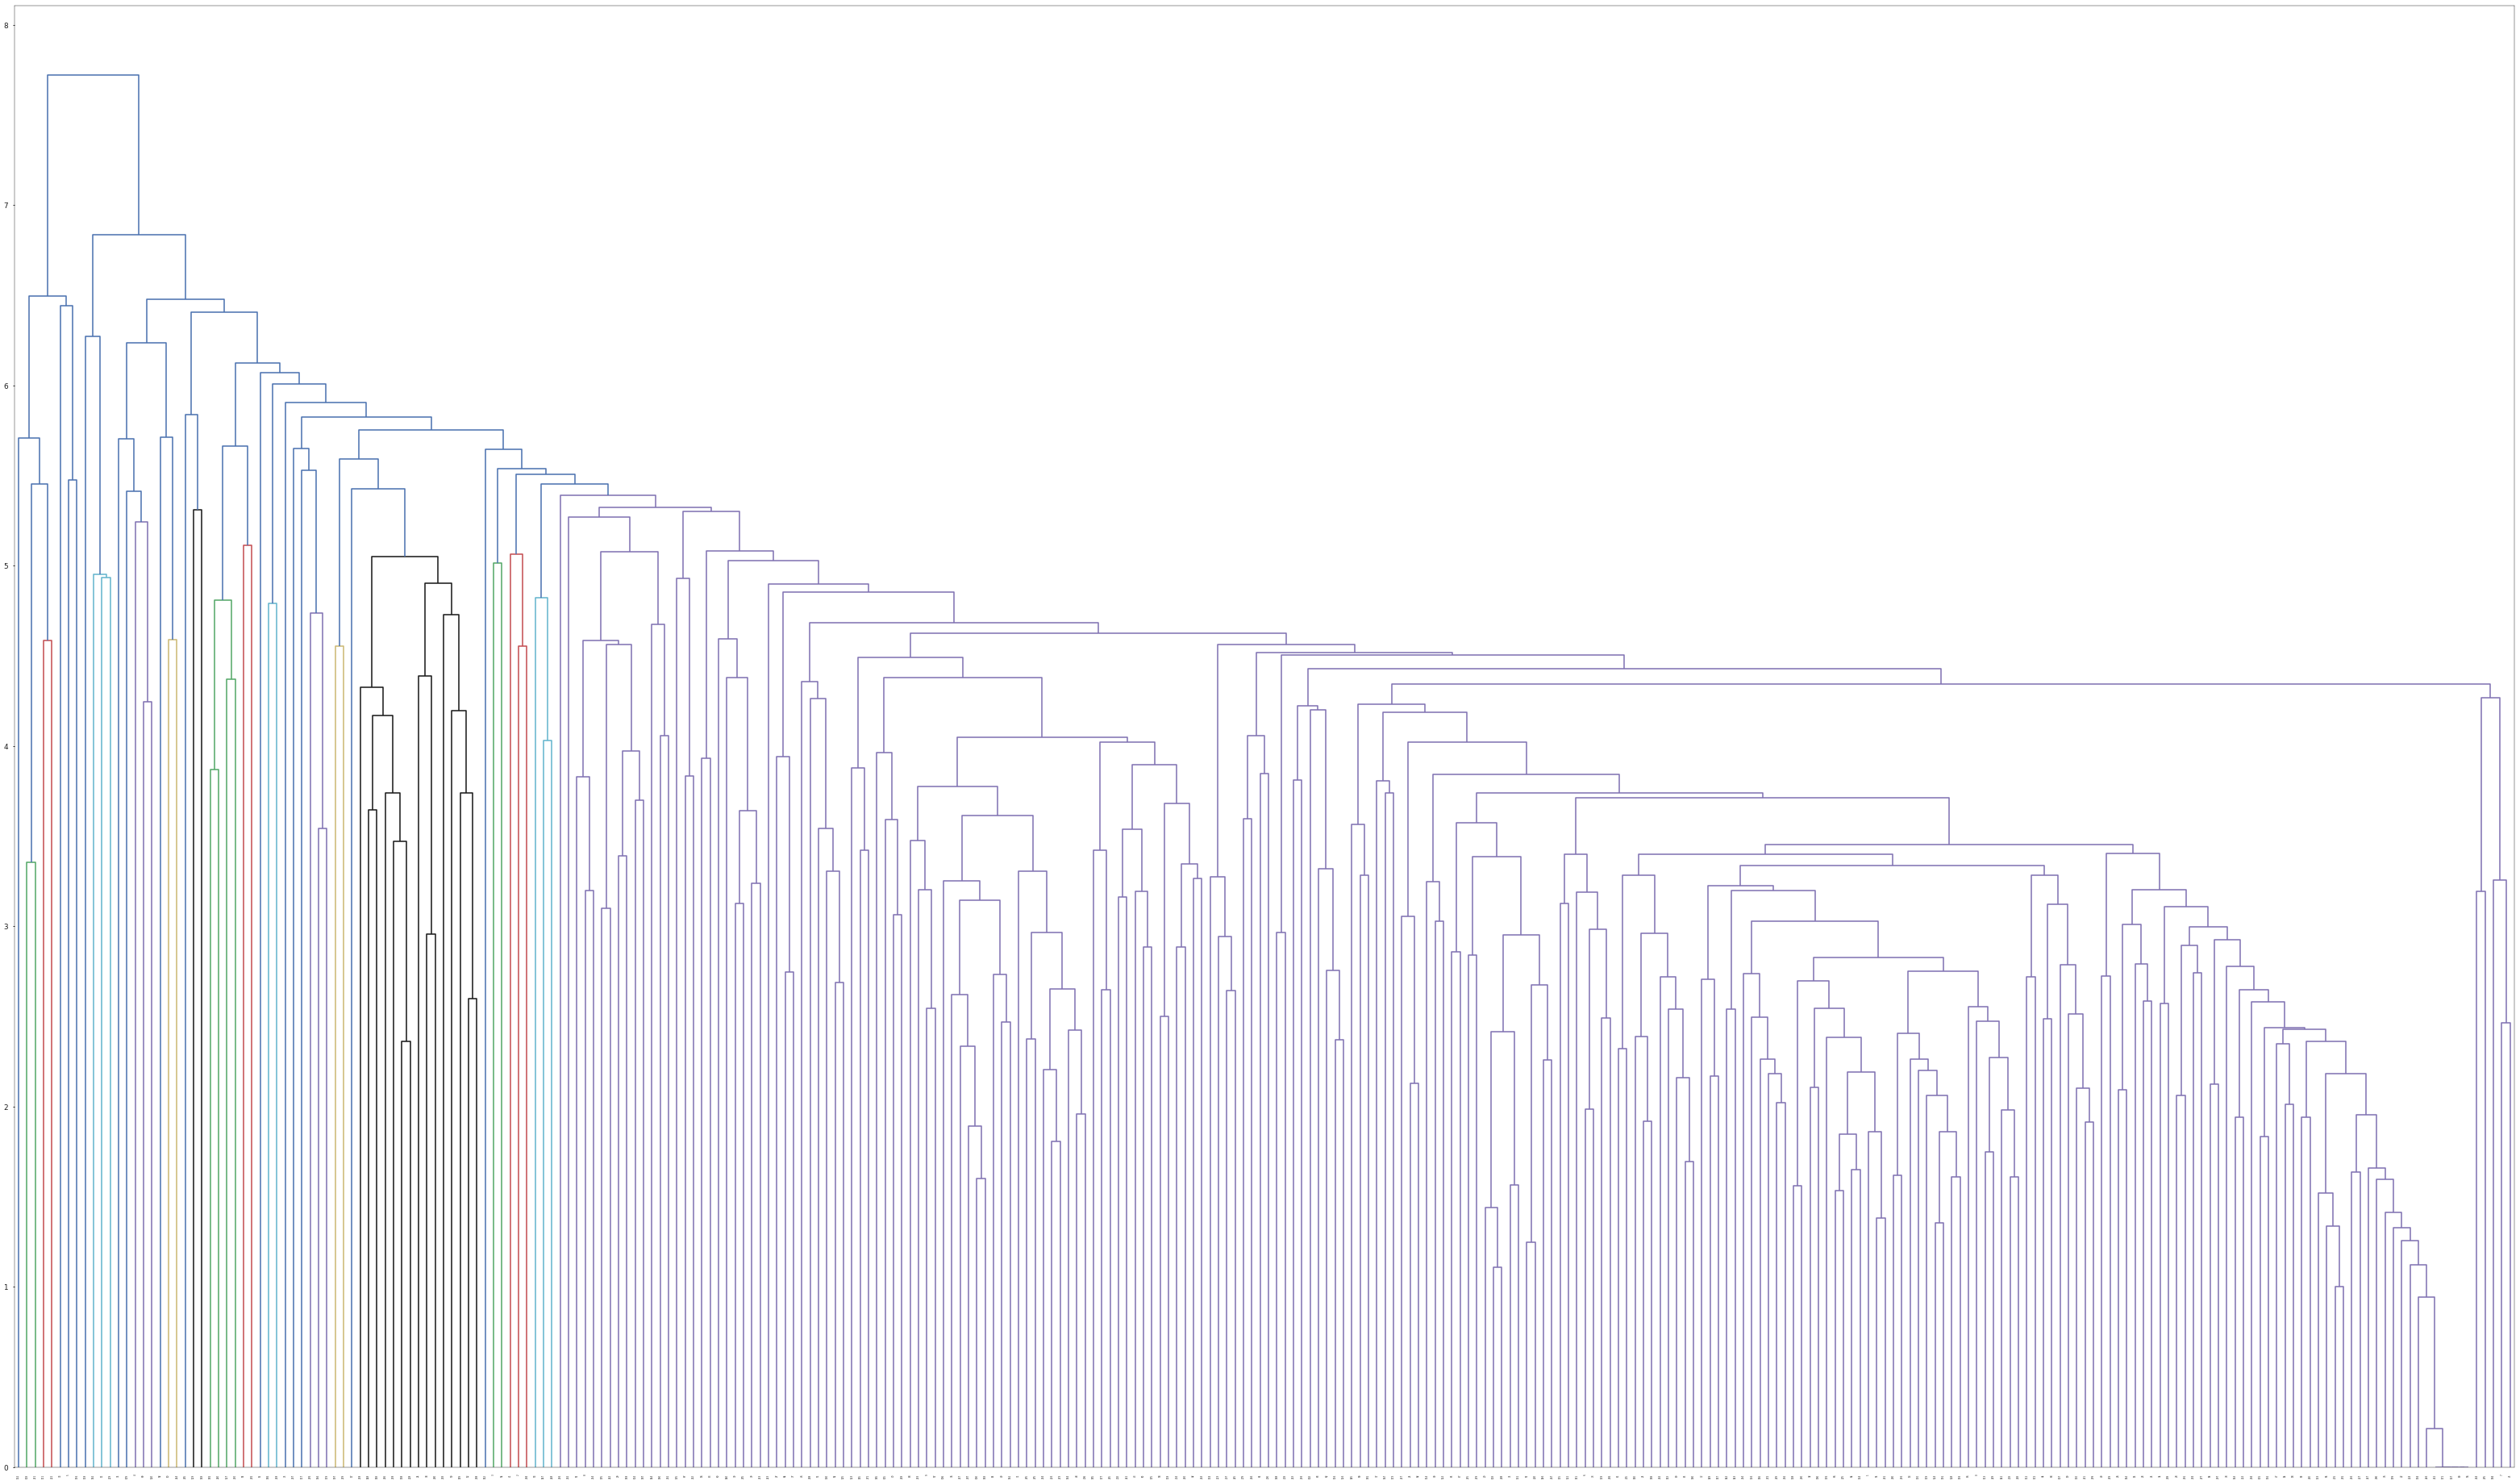

Fix8 Fitness Cafe & Grill,650 E Horizon Dr,Henderson,NV
Miller's Ale House - Henderson,594 Stephanie St,Henderson,NV
Standard & Pour,11261 S Eastern Ave, Ste 200,Henderson,NV
Born And Raised,10050 S Eastern Ave,Henderson,NV
Woods Family Sandwiches,931 American Pacific Dr, Ste 106,Henderson,NV
Served,1770 W Horizon Ridge, Ste 100,Henderson,NV
HoneyBaked Ham,1533 W Sunset Rd,Henderson,NV
Egg Works,10839 S Eastern Ave,Henderson,NV
Dylans Grill and Pub,4401 E Sunset Rd,Henderson,NV
Giuseppes Bar & Grille Henderson,2630 W Horizon Ridge Pkwy,Henderson,NV
The Tangerine Cafe,10895 S Eastern Ave, Ste 100,Henderson,NV
Layers Bakery Cafe,665 S Green Valley Pkwy, Ste 100,Henderson,NV
Corner Bakery Cafe,494 N Stephanie St,Henderson,NV
Champagne Life,2831 St Rose Pkwy, Ste 308,Henderson,NV
East Coast Eats,50 N Valle Verde Dr, Ste 110,Henderson,NV
Shake Shack,2225 Village Walk Dr,Henderson,NV
Costa Del Sol At Sunset Station,1301 W Sunset Road,Henderson,NV
Putters Bar & Grill,1231 American Pacific Dr,

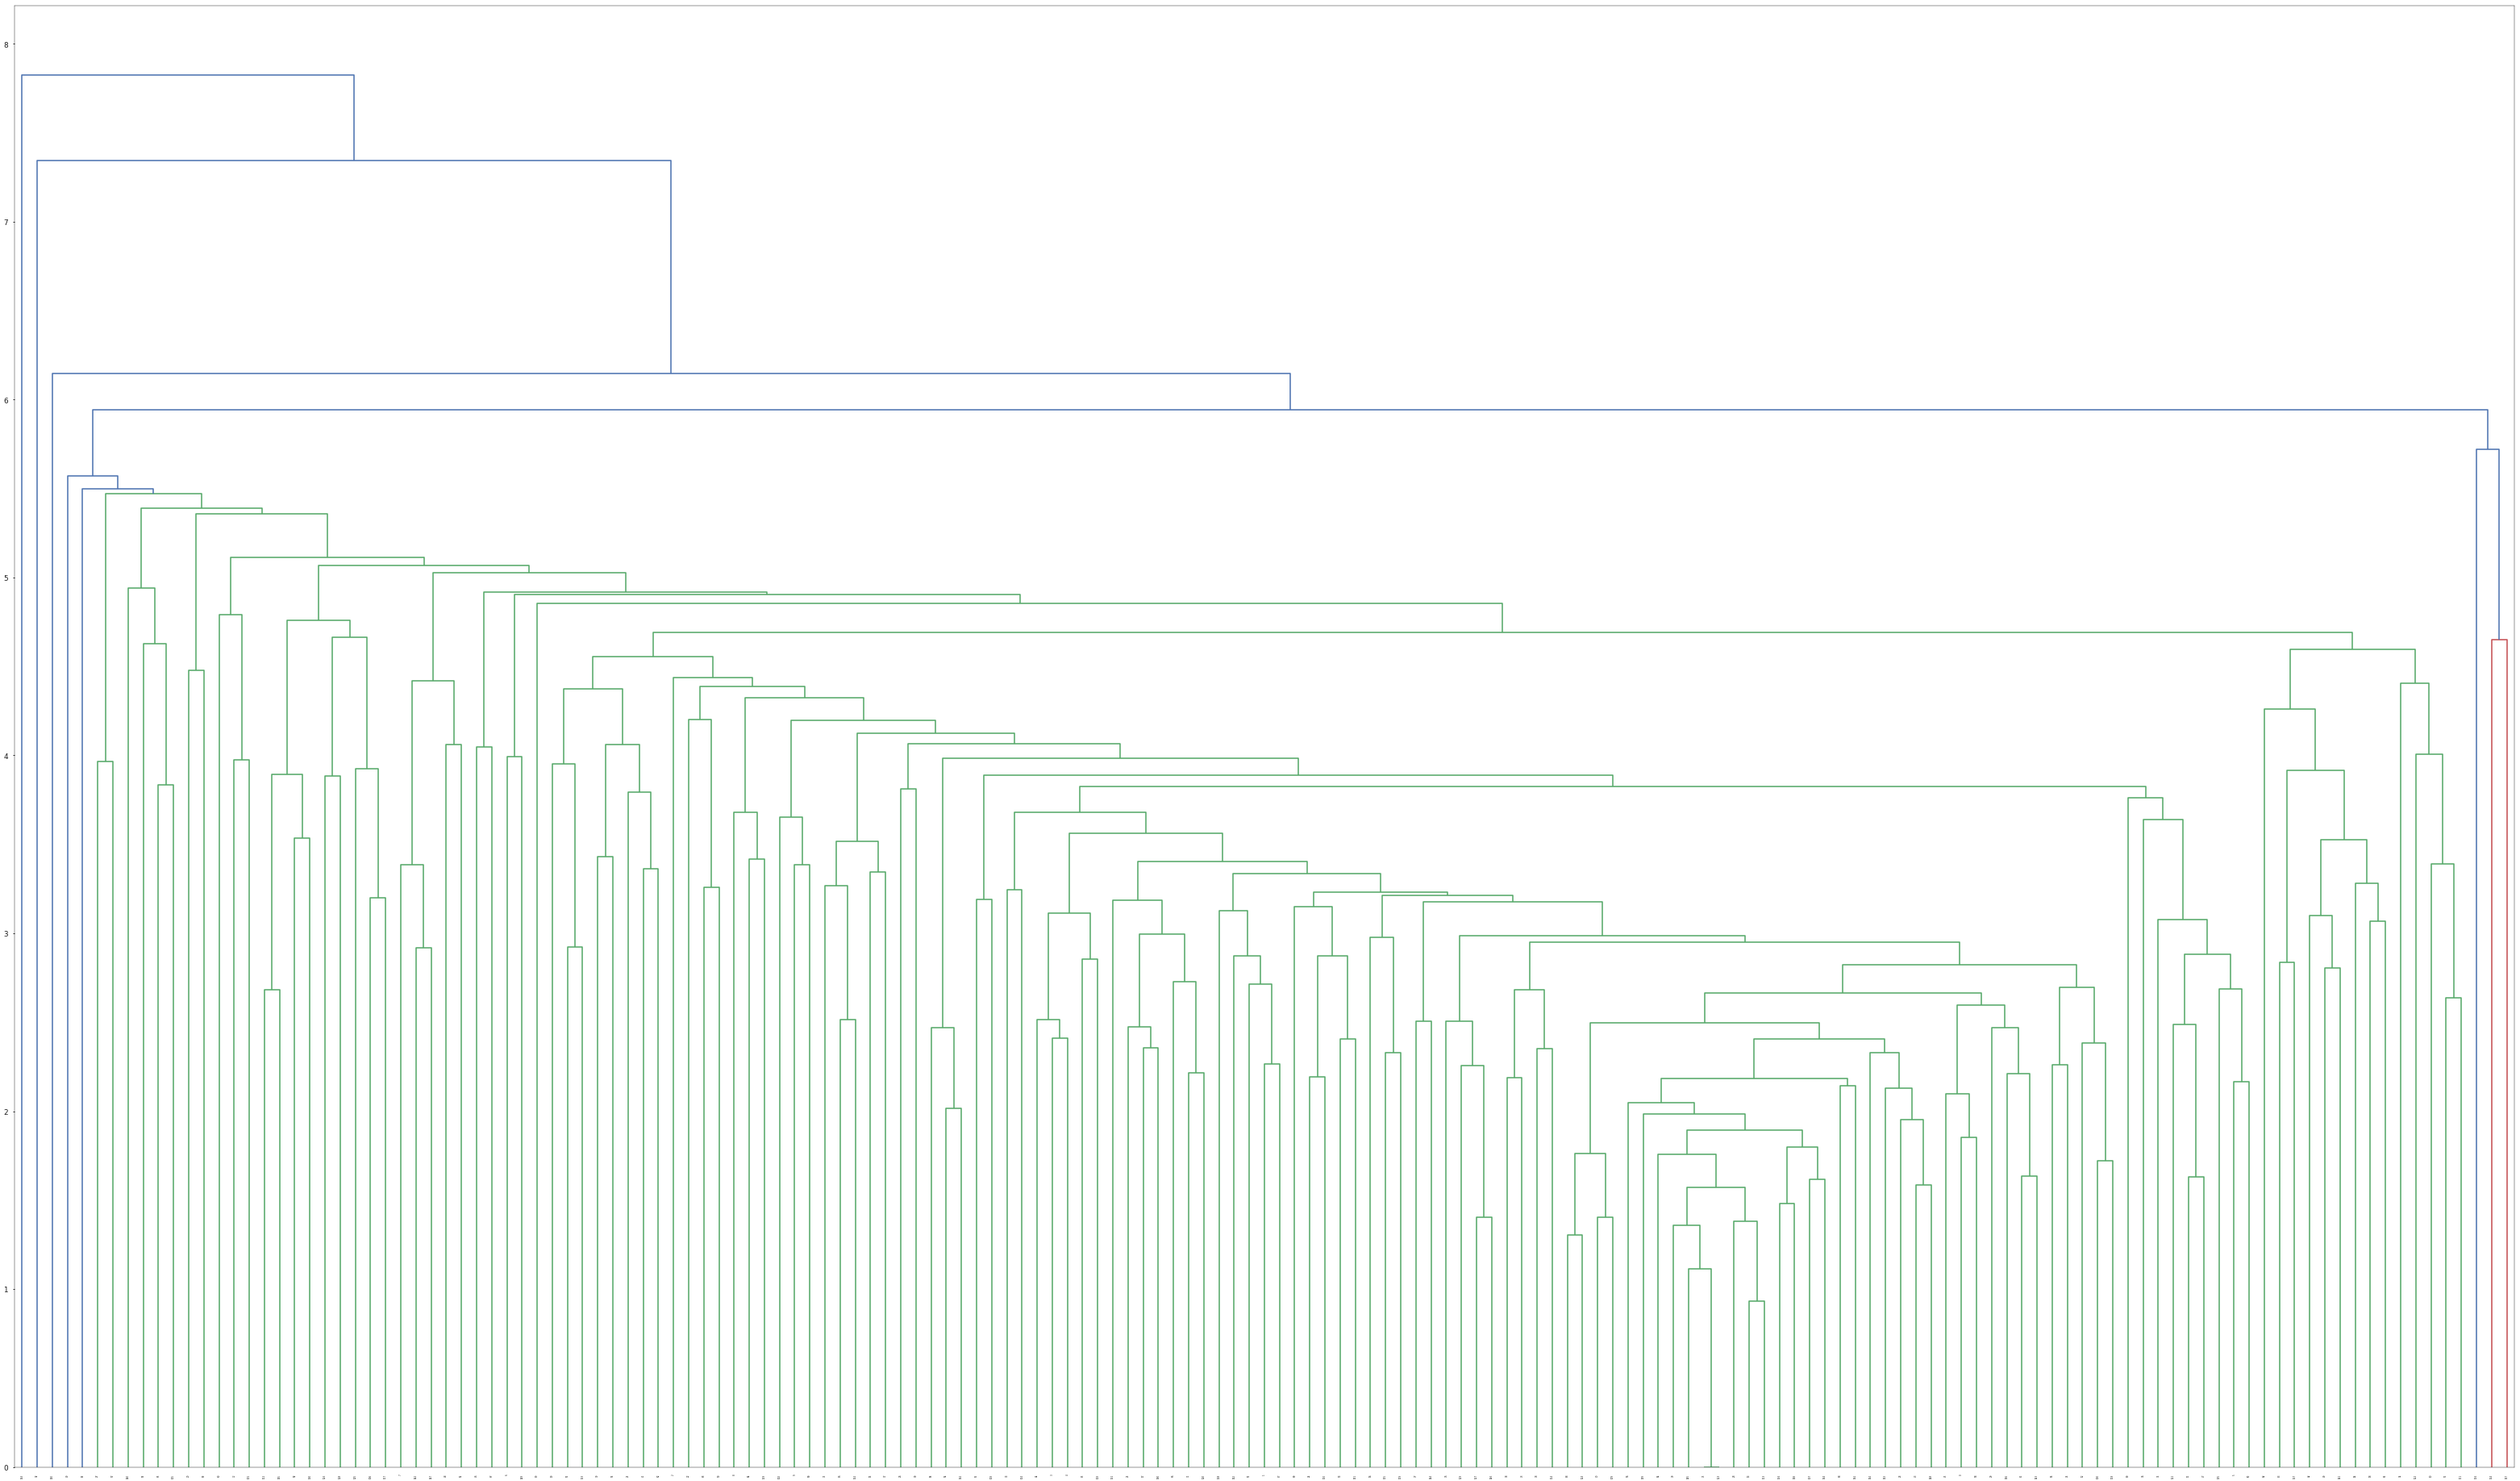

Cities Sports Bar & Grill,5835 Dixie Road,Mississauga,ON
Roosters Edge,812 Britannia Road W, Unit 104,Mississauga,ON
Desi Bar & Grill,925 Rathburn Road E,Mississauga,ON
The Maharaja,4646 Heritage Hills Boulevard, Unit 3,Mississauga,ON
St. Louis Bar & Grill,6485 Mississauga Rd,Mississauga,ON
Oliver's Ale House,6155 Tomken Road,Mississauga,ON
Turtle Jack's,108 Courtney Park Drive E,Mississauga,ON
Rib Eye Jack's Ale House,6531 Mississauga Road,Mississauga,ON
St. Louis Bar & Grill,29 Aventura Court,Mississauga,ON
Goodfellas Pizza,209 Queen Street S,Mississauga,ON
Eddie's Wok N Roll,6400 Millcreek Drive,Mississauga,ON
Ya Hala,1969 Lakeshore Road W,Mississauga,ON
Union Social Eatery,6986 Financial Drive, Unit 6,Mississauga,ON
Corner By Spoon and Fork,1225 Dundas Street E, Suite 14B,Mississauga,ON
The Mission Eatery,5915 Airport Road, Suite100,Mississauga,ON
The Clarkson Pump & Patio,1744 Lakeshore Road W,Mississauga,ON
Thyme Ristorante,347 Lakeshore Road E,Mississauga,ON
Tim Horton,910 Lakes

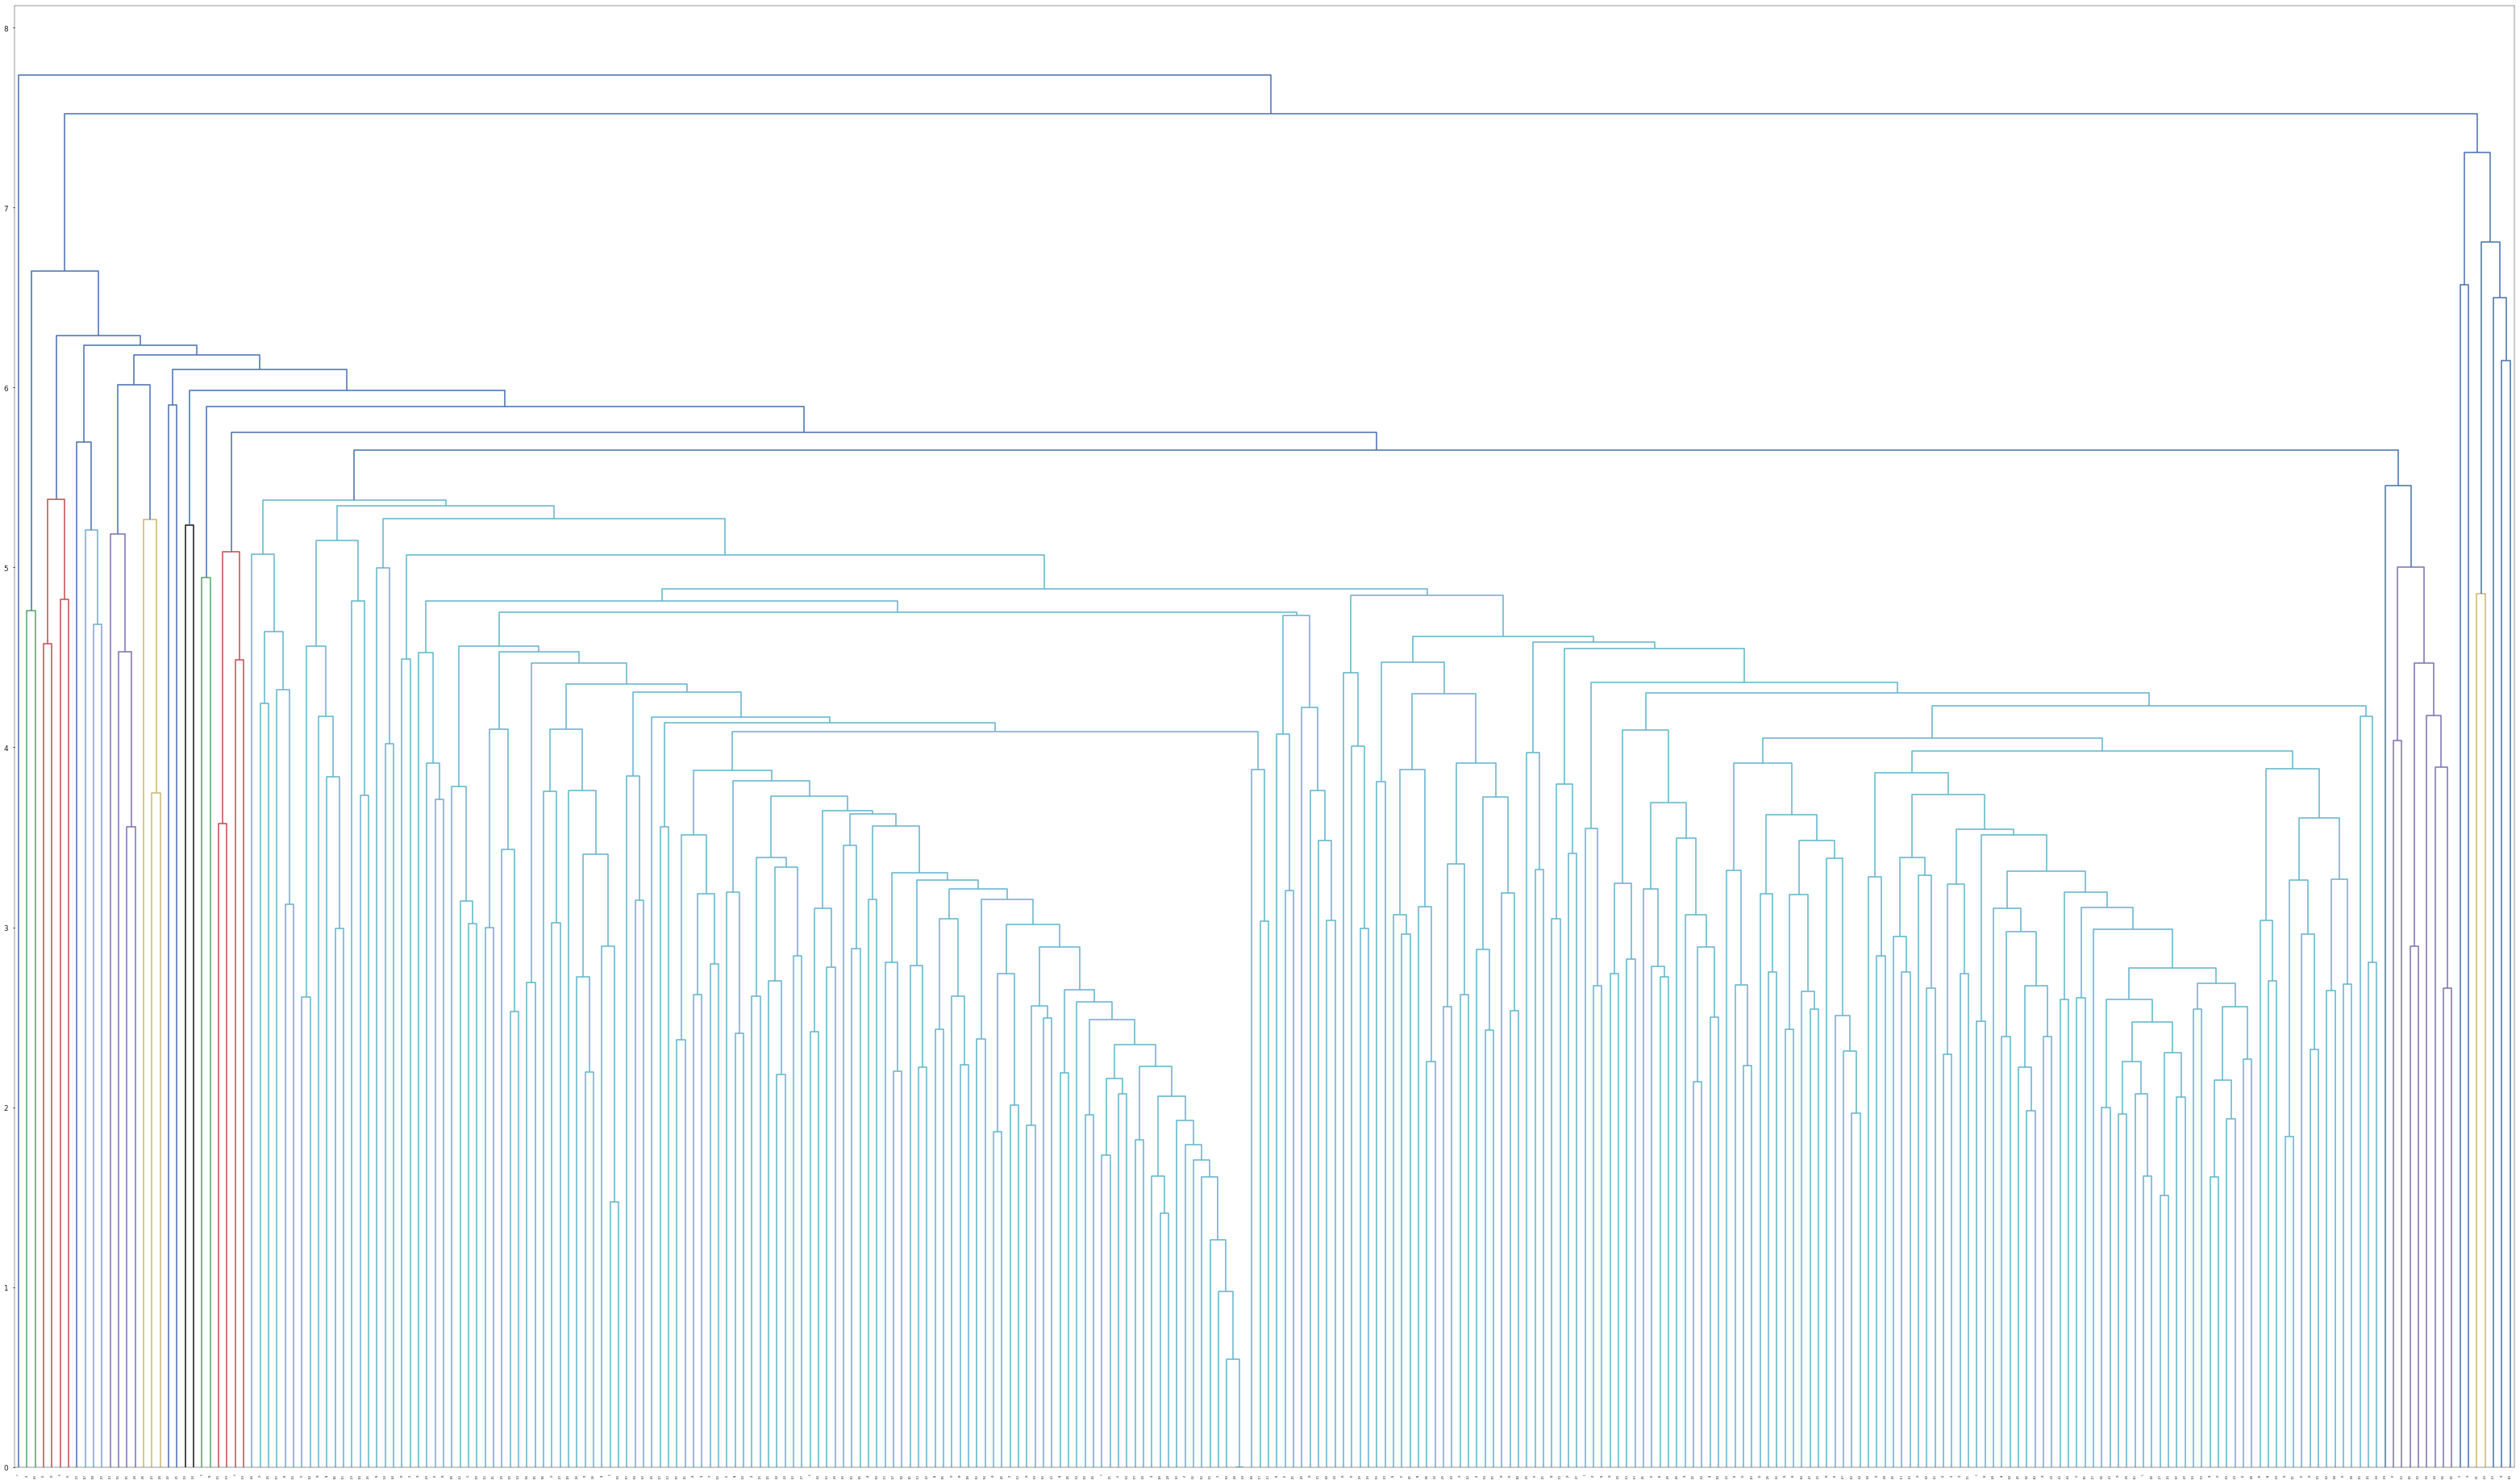

Local Play Yard Bar & Grill,3002 N Arizona Ave, Ste 1,Chandler,AZ
American Way Market,1509 N Arizona Ave,Chandler,AZ
GRAZ Kitchen Fresh,1005 S Arizona Ave, Ste 6,Chandler,AZ
Cold Beers & Cheeseburgers,1980 W Germann Rd,Chandler,AZ
Yolis Café,241 S Oregon St,Chandler,AZ
AZ Food Crafters,961 W Ray Rd, Ste 1,Chandler,AZ
Cities Bar & Grille,1077 S Kyrene Rd,Chandler,AZ
Twisted Cactus Brewing Company,4080 W Ray Rd, Ste 26,Chandler,AZ
Sawtooth Bar & Grill,4929 W Ray Rd, Ste 3,Chandler,AZ
Rocket Burger & Subs,2100 W Chandler Blvd, Ste 38,Chandler,AZ
Rick's Pub and Grub,4910 W Ray Rd,Chandler,AZ
Bella Gusto Urban Pizzeria,1964 N Alma School Rd, Ste 1,Chandler,AZ
VB Lounge,81 W Boston St,Chandler,AZ
Biscuits Cafe,2090 N Dobson Rd, Ste 4,Chandler,AZ
Smokin Fins,900 N 54th St, Ste 1,Chandler,AZ
Sauce Pizza & Wine,2551 W Queen Creek Rd, Ste 4,Chandler,AZ
Pei Wei,7131 W Ray Rd, Bldg 1, Ste 3,Chandler,AZ
Original ChopShop,35 W Boston St,Chandler,AZ
Wildflower Bread Company,3111 W Chandler Blvd,Chand

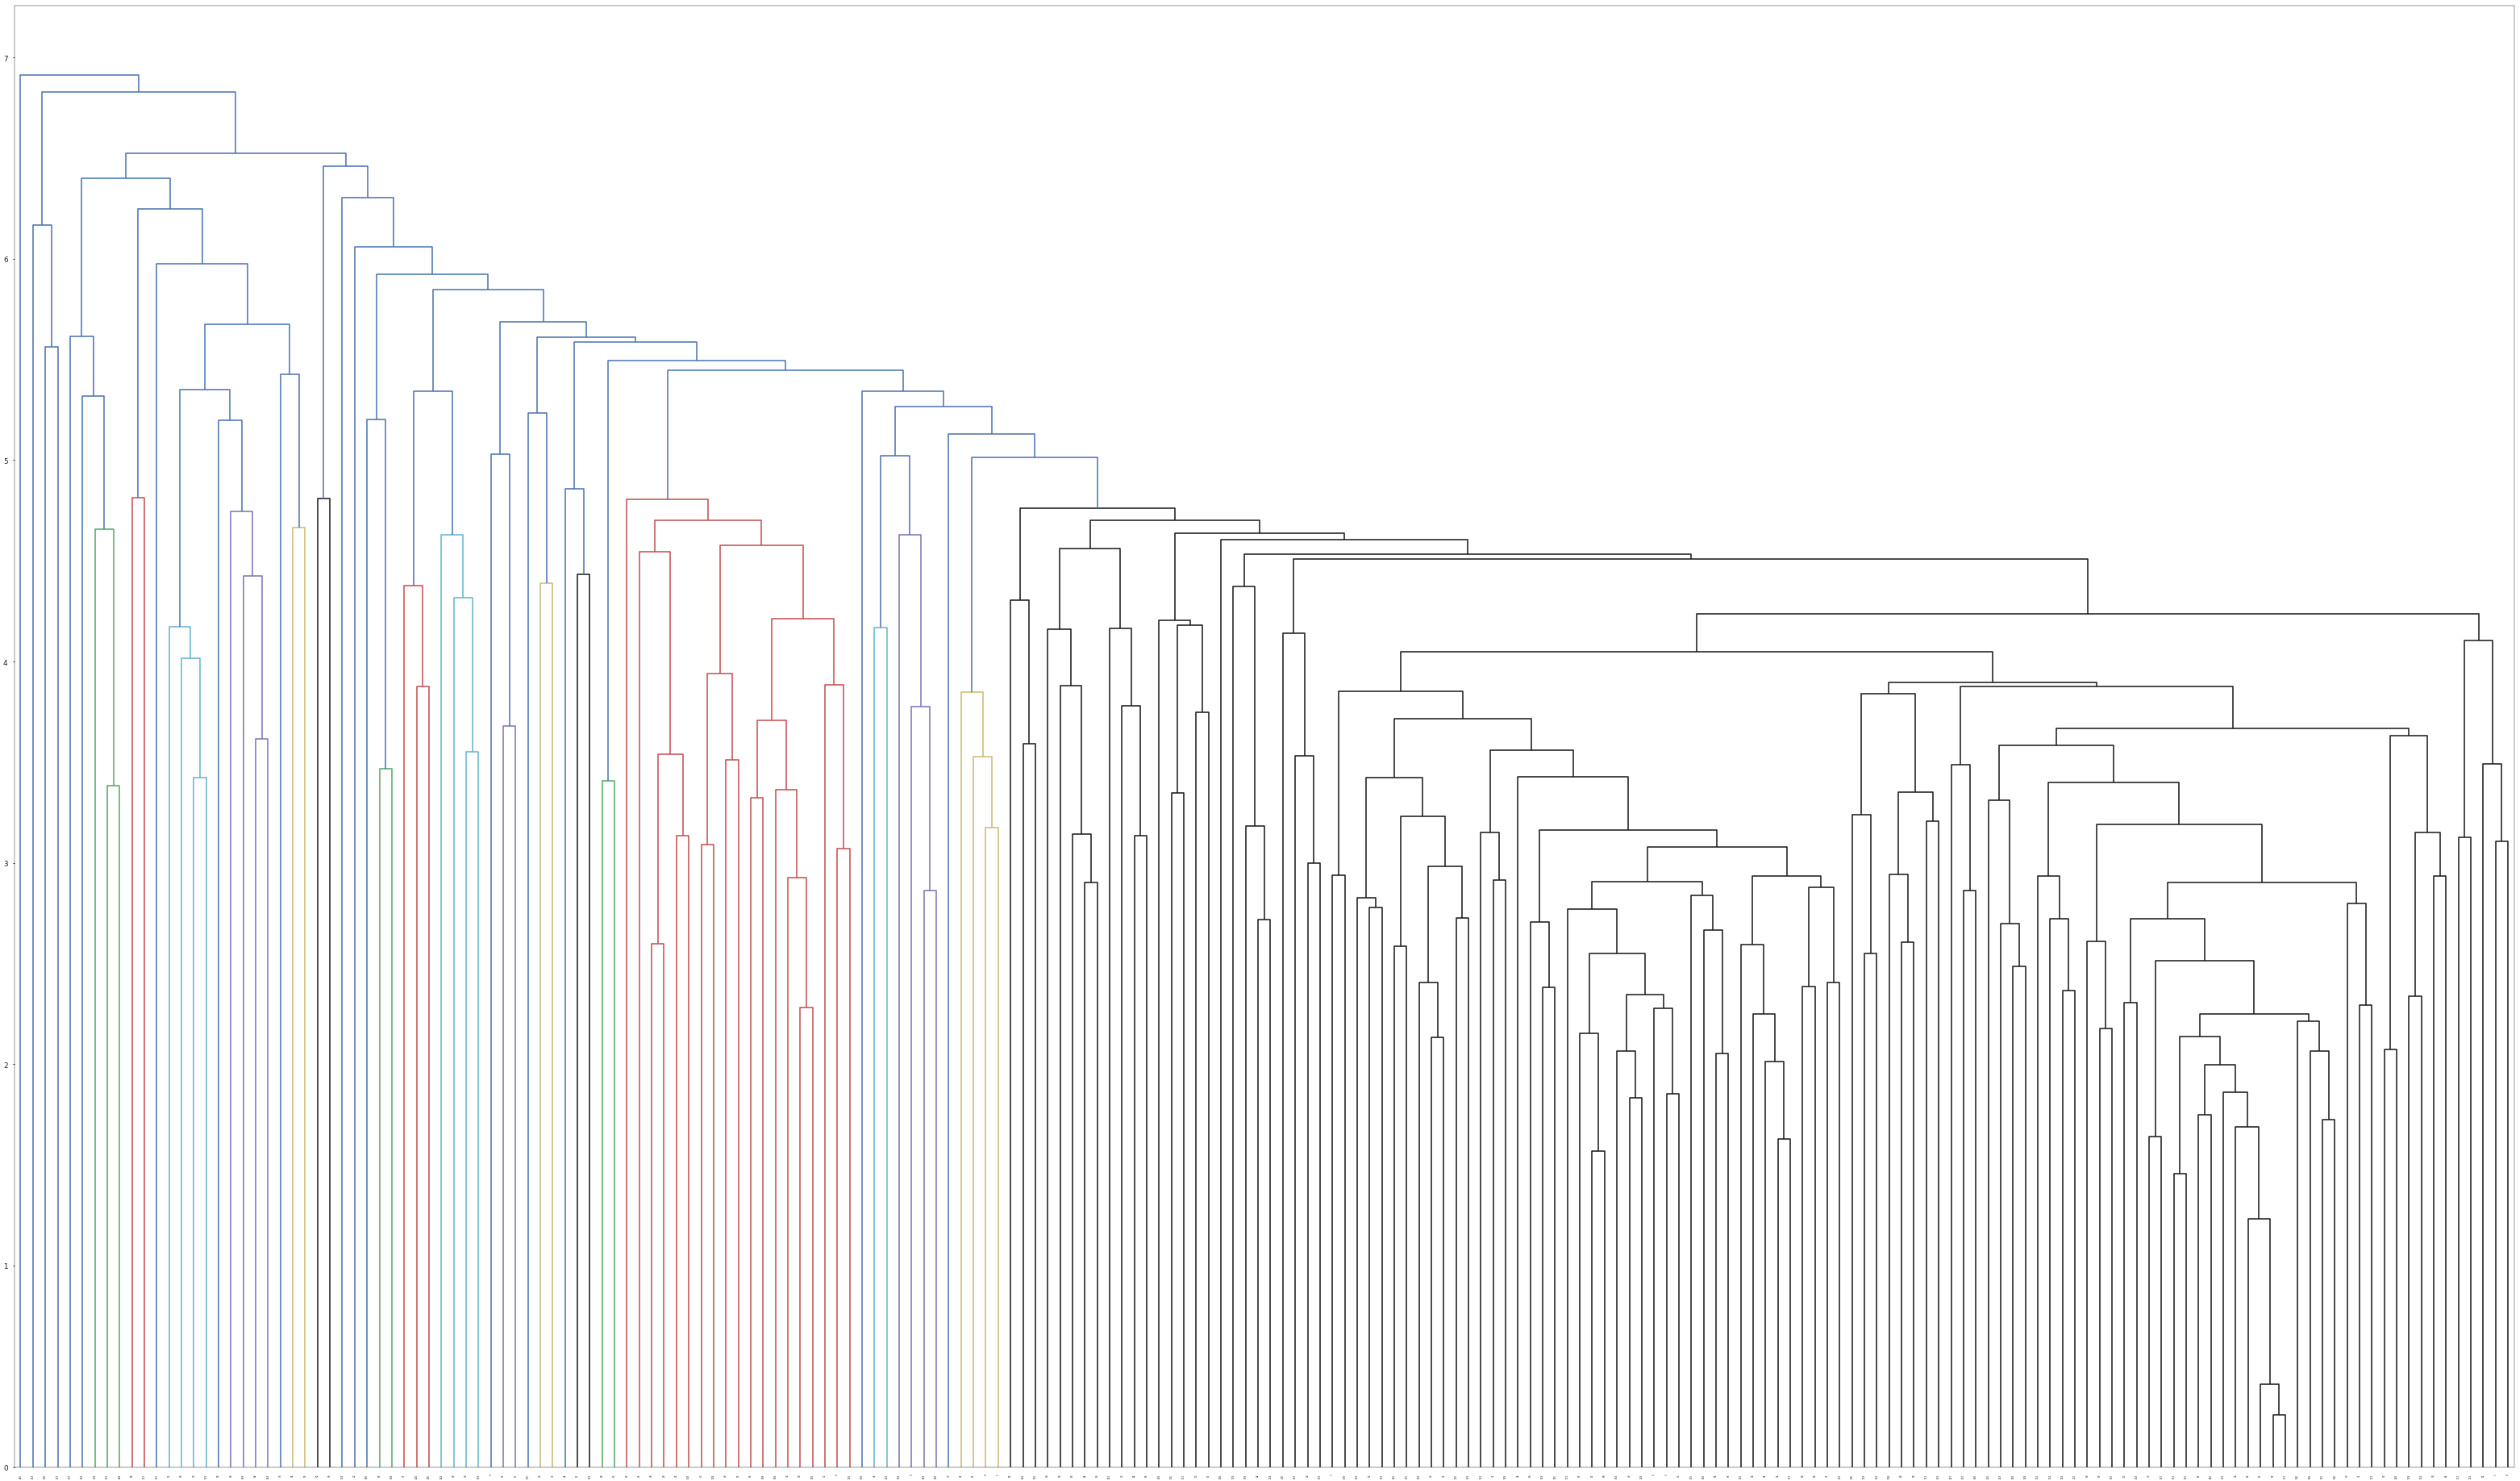

1455 American Grill,1455 W Elliot Rd, Ste 101,Gilbert,AZ
The Whining Pig - Gilbert,2512 S Val Vista Dr,Gilbert,AZ
Native Grill & Wings,4972 S Power Rd,Gilbert,AZ
Zappone's Italian Bistro,1652 N Higley Rd, Ste 103,Gilbert,AZ
Pizza A Metro,832 S Greenfield Rd,Gilbert,AZ
The Groves Bar & Grill,323 S Gilbert Rd, Ste 111,Gilbert,AZ
Buffalo Wild Wings,970 S Gilbert Rd,Gilbert,AZ
Wild Ginger,861 N Higley Rd, Ste 111,Gilbert,AZ
Salad and Go,743 N Gilbert Rd,Gilbert,AZ
Postino East,302 N Gilbert Rd,Gilbert,AZ
Cold Beers & Cheeseburgers,4604 S Higley Rd, Ste 103,Gilbert,AZ
Copper Still Moonshine Grill,2531 S Gilbert Rd, Ste 101,Gilbert,AZ
MWC Bistro,1422 W Warner Rd, Ste A-100,Gilbert,AZ
Apple Dumpling Cafe,3076 E Chandler Heights Rd, Ste 101,Gilbert,AZ
Frost Gelato,2150 E Williams Field Rd, Ste 120,Gilbert,AZ
Jimmy's of Chicago,3107 S Gilbert Rd, Ste 107,Gilbert,AZ
Blue 32 Sports Grill,6348 S Higley Rd,Gilbert,AZ
Blue 32 Sports Grill,1524 E Williams Field Rd,Gilbert,AZ
Fire and Brimstone,3000 E

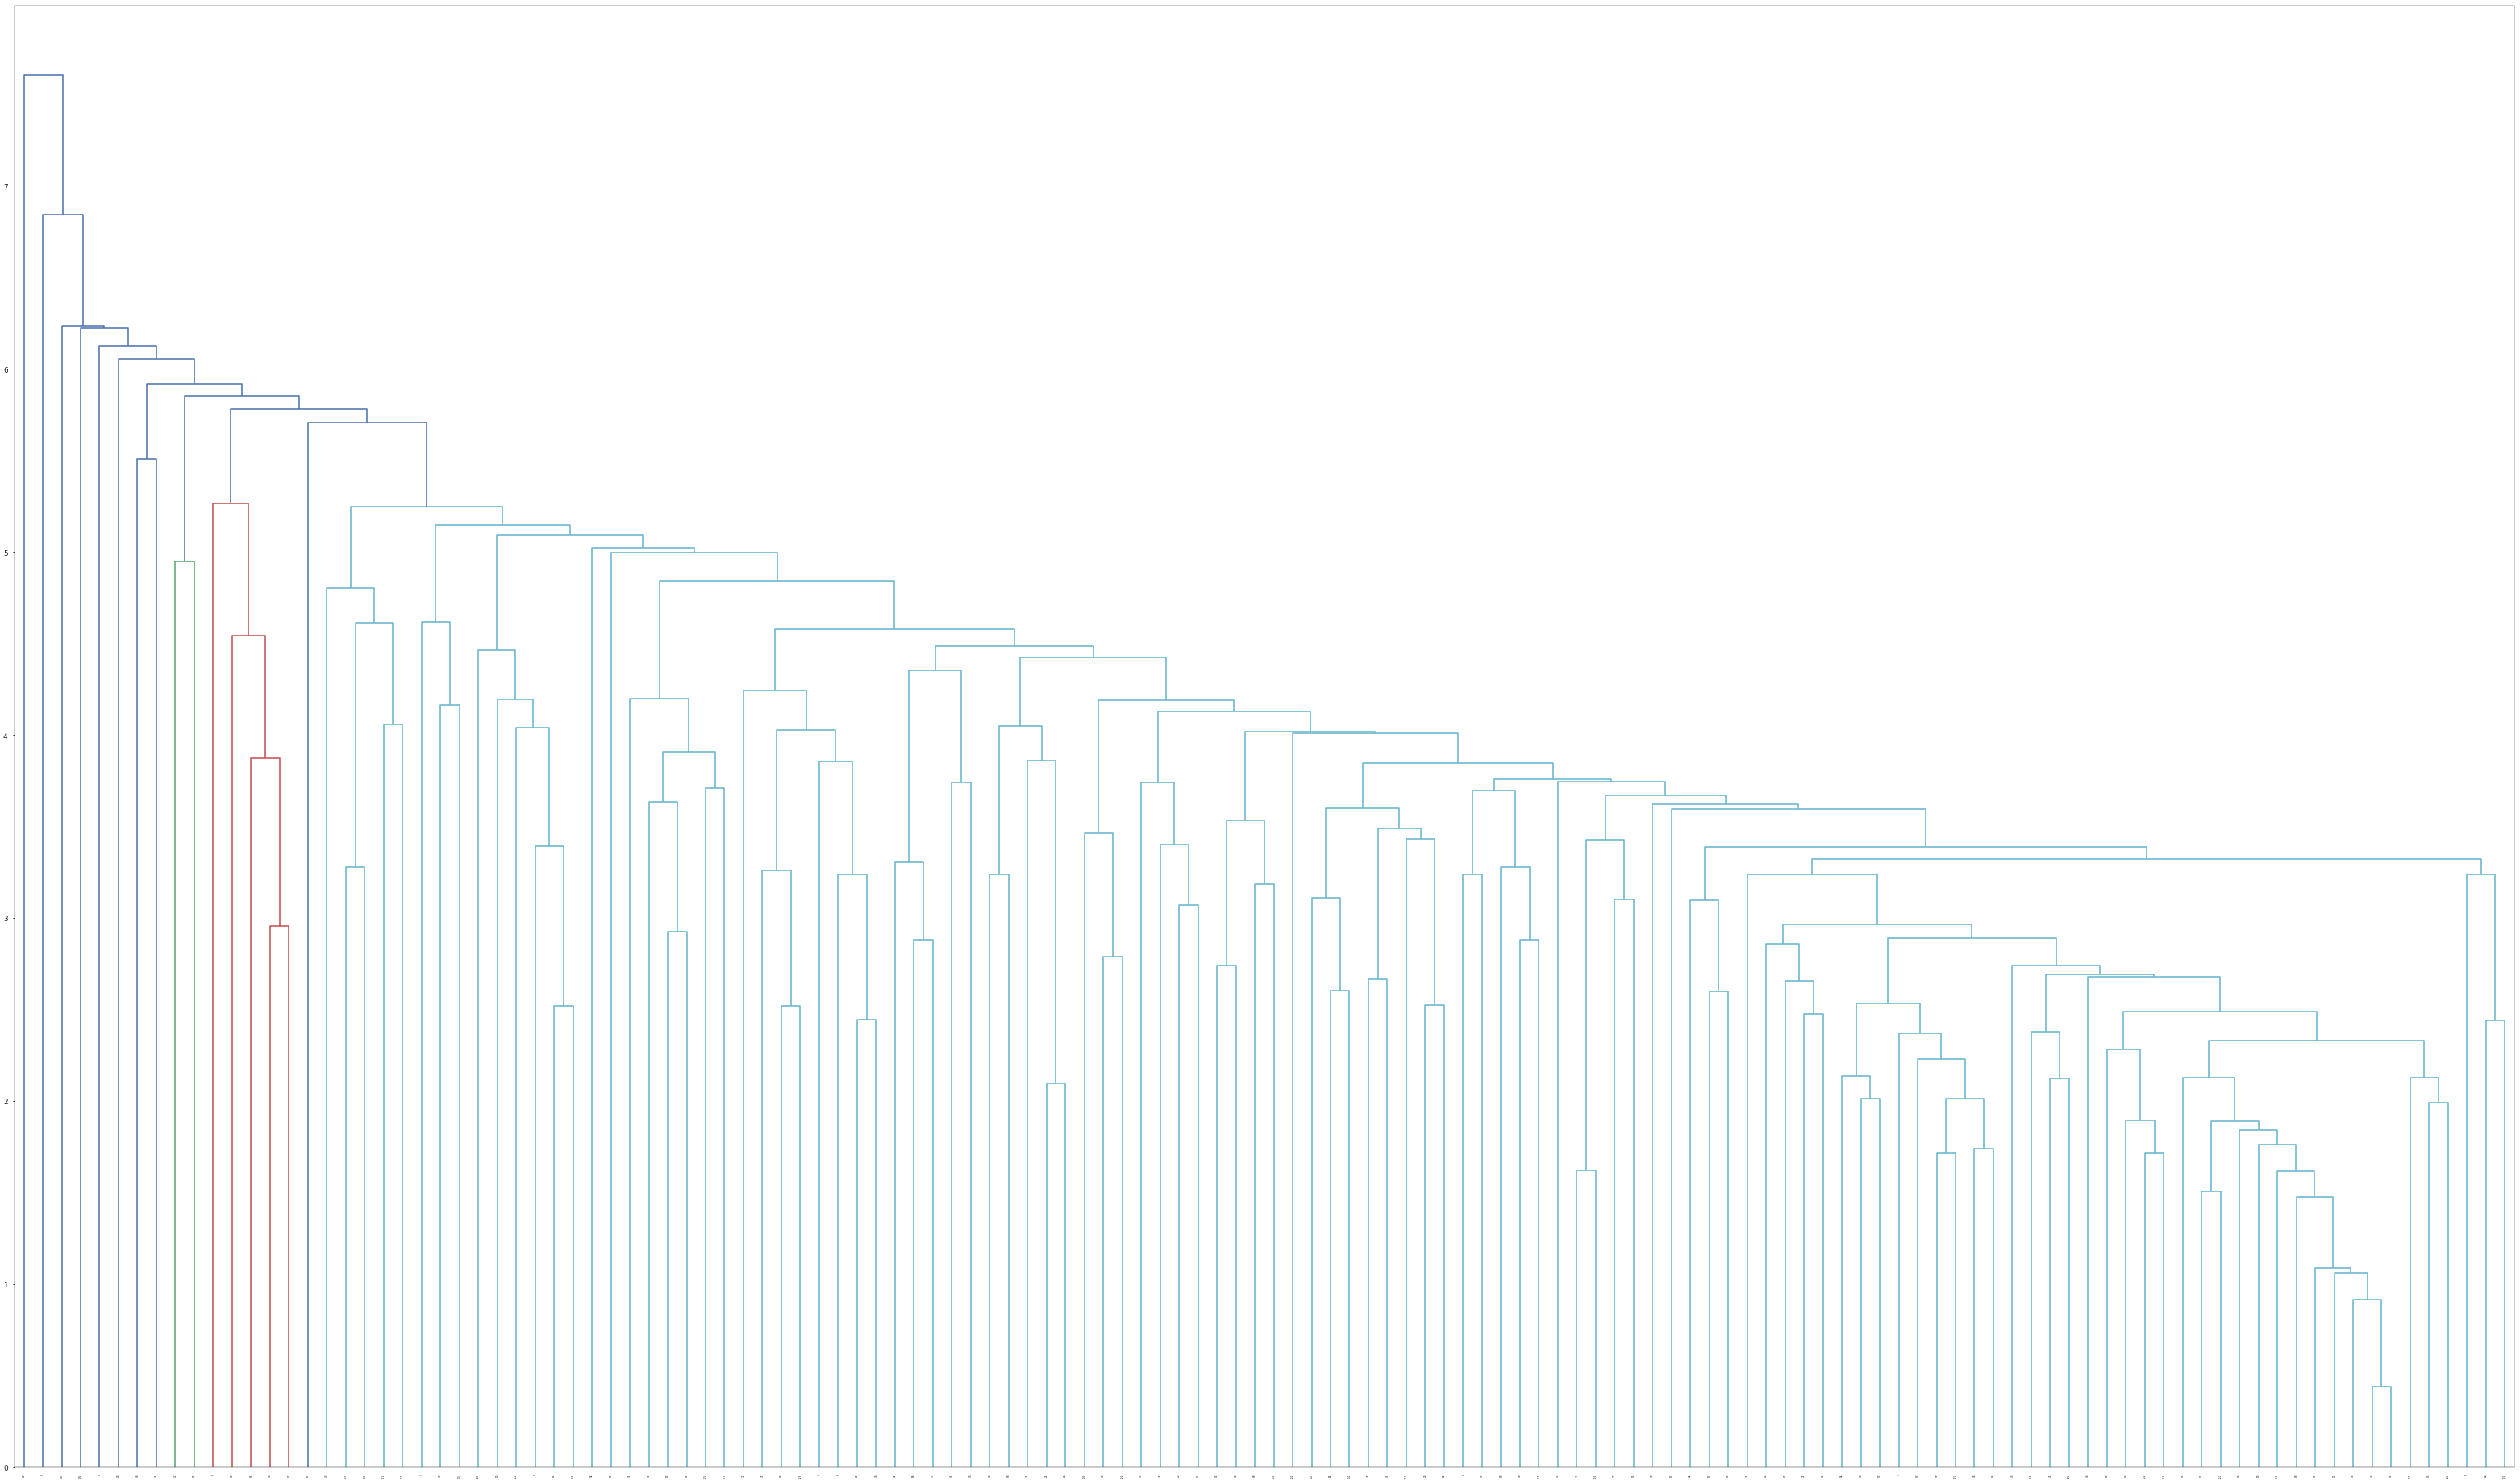

Gaslight Cafe,5747 W Glendale Ave,Glendale,AZ
Panini Bread & Grill,3510 W Bell Rd,Glendale,AZ
Tavern+Bowl,9380 W Westgate Blvd,Glendale,AZ
Crave,9380 W Westgate Blvd, Ste D-103,Glendale,AZ
Braistas Coffee Bar,6409 W Glendale Ave,Glendale,AZ
Wildflower Bread Company,17530 N 75th Ave,Glendale,AZ
La Santisima,5932 W Glendale Ave,Glendale,AZ
Kimmyz on Greenway Rock & Roll Bar & Grill,5930 W Greenway Rd,Glendale,AZ
Flora House Cafe,6922 N 95th Ave, Ste 200,Glendale,AZ
Olde Towne Glendale Wine and Beer Bar,5745 W Glendale Ave,Glendale,AZ
Lucky's Pizza,6630 W Cactus Rd, Ste B108,Glendale,AZ
Venice Pizza,4645 W Maryland Ave,Glendale,AZ
Doglicious Hot Dogs,5060 W Bell Rd, Ste A,Glendale,AZ
A Taste of Buffalo,17045 N 59th Ave, Ste 103,Glendale,AZ
Oggi's,6681 W Beardsley Rd,Glendale,AZ
Cheers Tavern,5915 W Bell Rd,Glendale,AZ
Yard House,9401 West Westgate Blvd,Glendale,AZ
IronWorks Restaurant,17233 N 45th Ave,Glendale,AZ
Dillon's KC BBQ,20585 N 59th Ave,Glendale,AZ
Hit Ratio:  0.59375
NDCG:  0.79

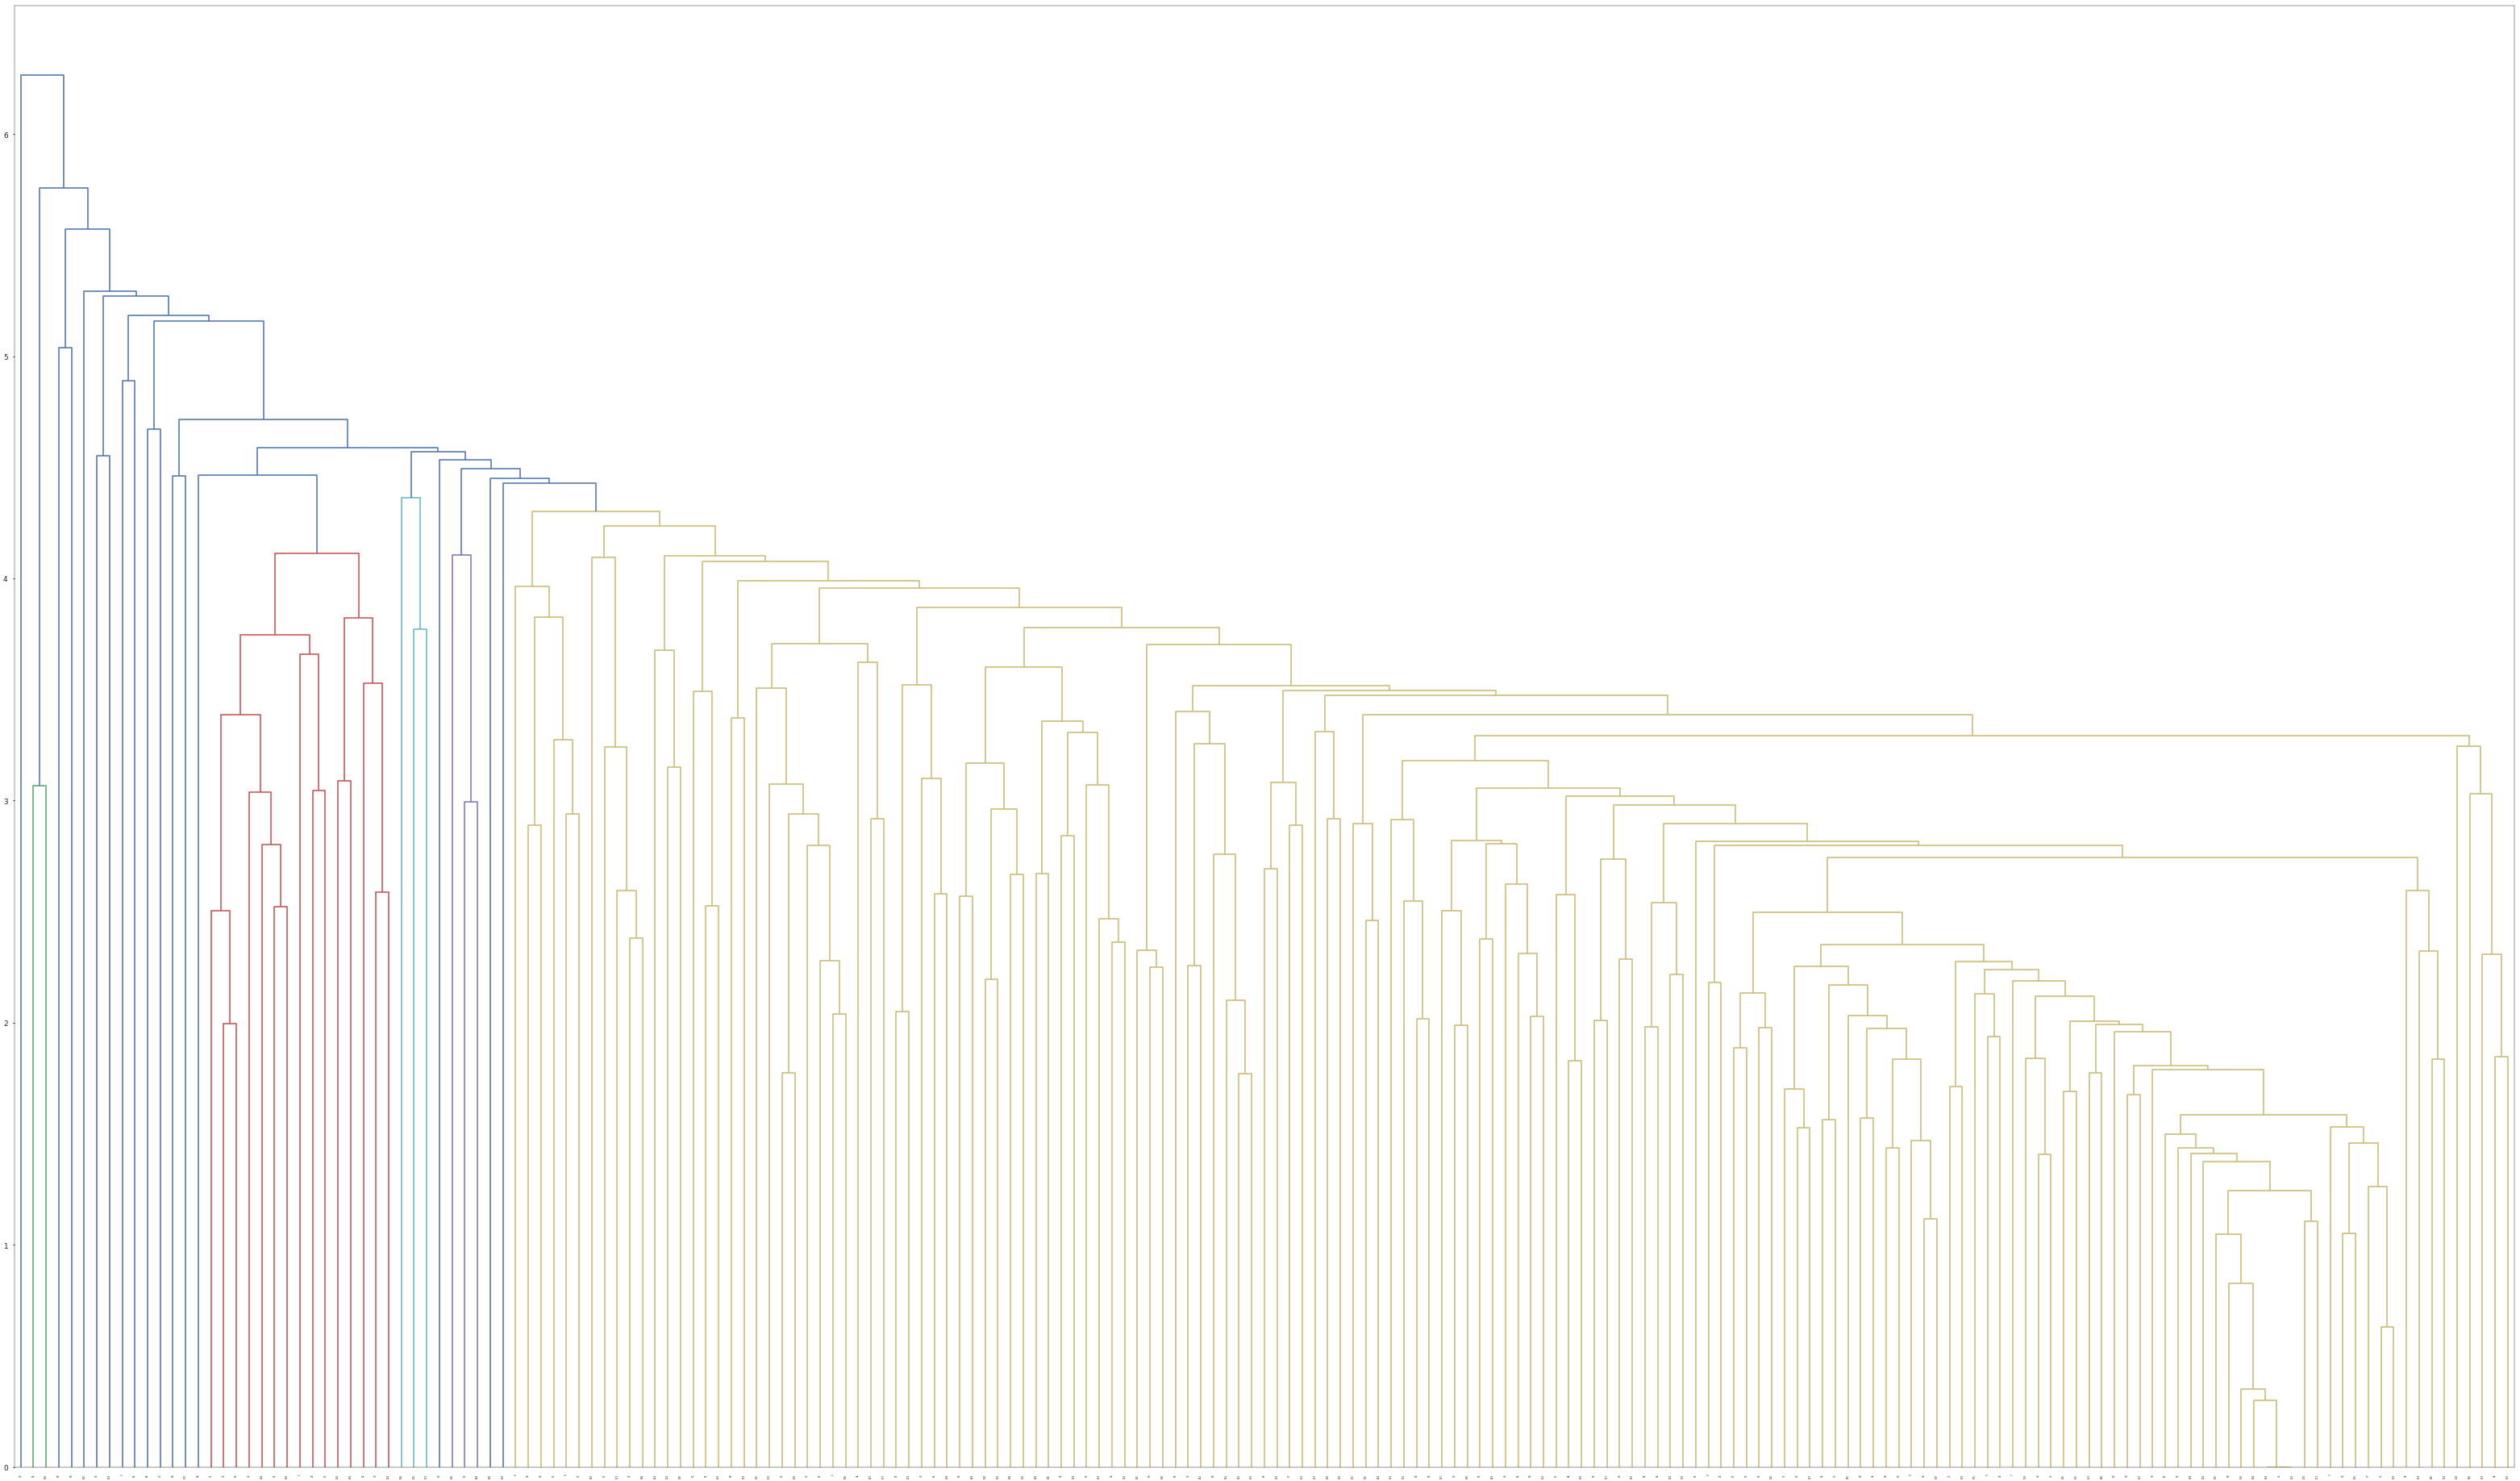

Raw-More Cafe,8110 Birchmount Road, Suite 10,Markham,ON
Ten Ten Dim Sum,3636 Steeles Avenue E, Unit 130,Markham,ON
Golf Wing Virtual Golf & Restaurant,7500 Woodbine Avenue, Unit G,Markham,ON
Matcha Tea & Dessert,505 Highway 7 E, Unit 15, Commerce Gate,Markham,ON
Paintlounge,118 Main Street N,Markham,ON
Kiko Cafe,3000 Highway 7,Markham,ON
Aka Teppan,3235 Highway 7 E,Markham,ON
EDO,8500 Warden Avenue,Markham,ON
Dessert Kitchen,3623 Highway 7 E, Unit 106, Liberty Square,Markham,ON
Taste Cafe,59-63 S Town Centre Boulevard,Markham,ON
Sweet Esc,30 Gibson Drive, Unit 120,Markham,ON
Tasty House,3255 Highway 7 E,Markham,ON
Toast Delight,8339 Kennedy Road, Unit 2659,Markham,ON
Alchemy Coffee,4361 Highway 7 E, Unit 1,Markham,ON
Tim Hortons,4467 Major Mackenzie Drive E,Markham,ON
Graceful Vegetarian Restaurant,Market Village, 7131 Kennedy Road, Suite 8,Markham,ON
Chef Chan,227 Main Street N,Markham,ON
Eini & Co,3229 Hwy 7 E,Markham,ON
Booster's On Main,175 Main Street Unionville,Markham,ON
Hit Rat

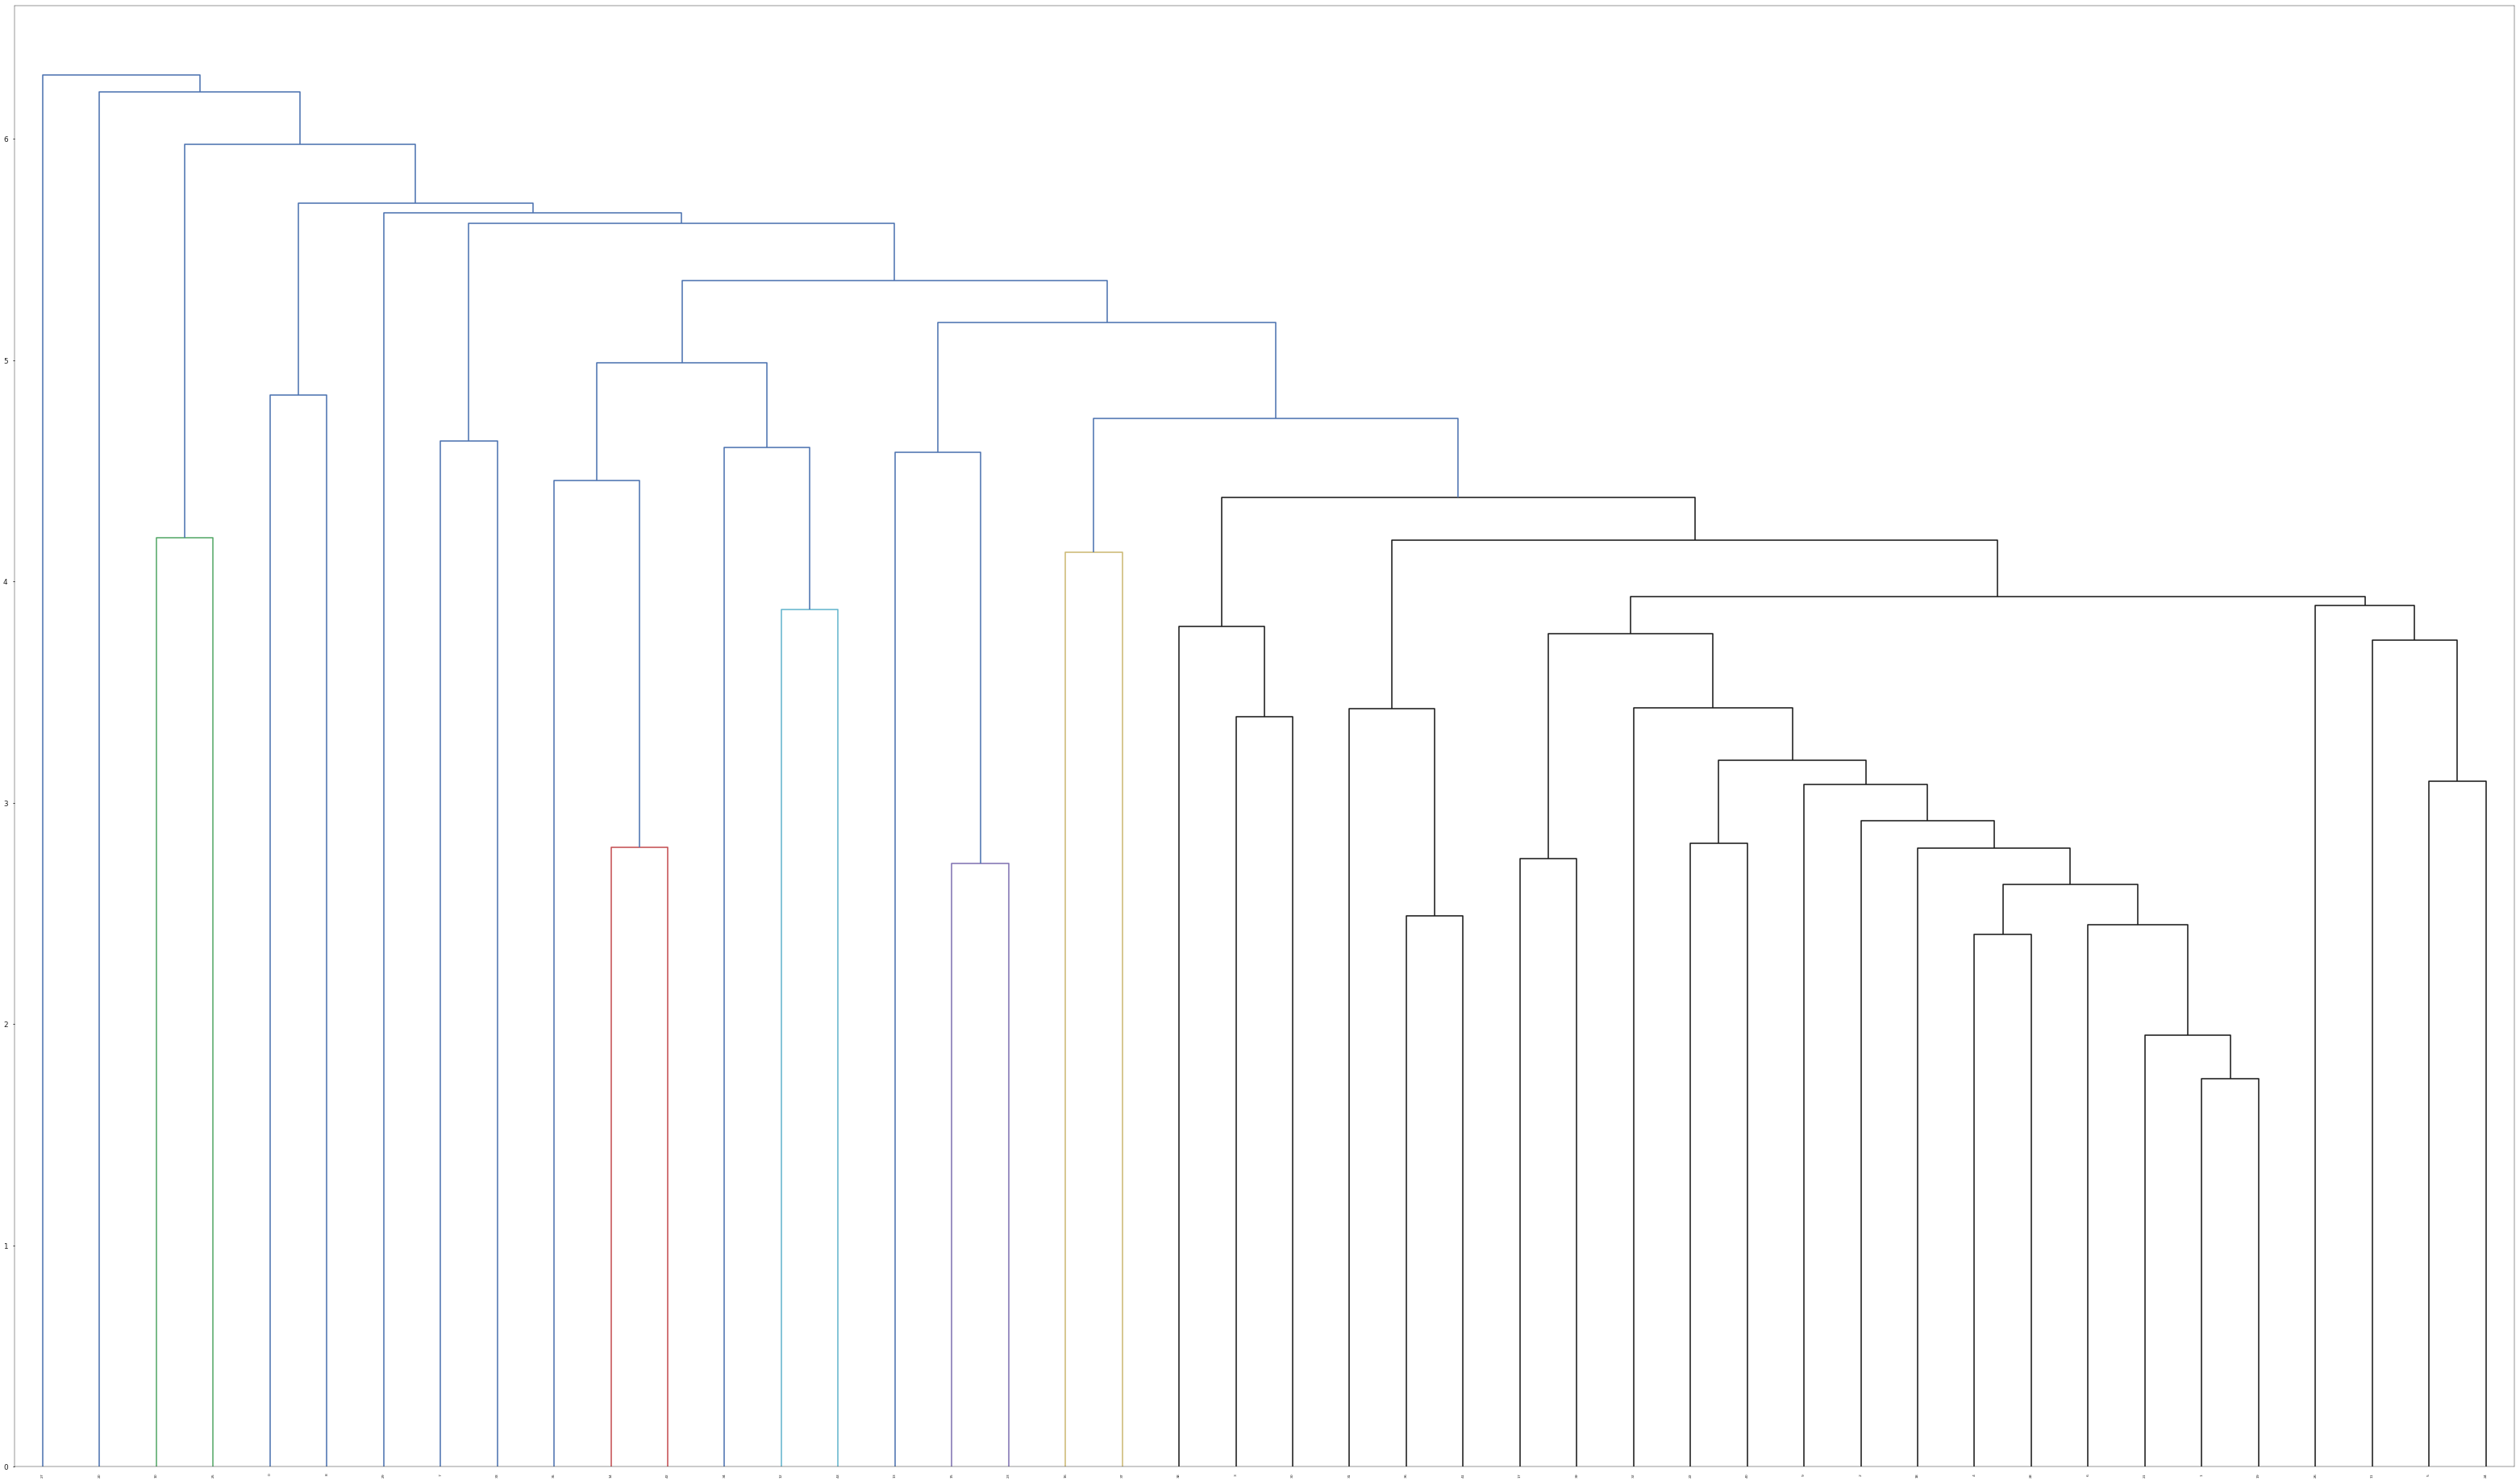

Dash Grill,7557 W Greenway Rd, Ste 104,Peoria,AZ
Pizza Near Me,8525 W Grand Ave,Peoria,AZ
Firebirds Wood Fired Grill,16067 N Arrowhead Fountains Ctr Dr,Peoria,AZ
Headquarters Grill Bar Sushi,16041 N Arrowhead Fountains Center Dr,Peoria,AZ
Brunos Pizza,6750 W Olive Ave,Peoria,AZ
Chick-fil-A,16657 N 83rd Ave,Peoria,AZ
Winery 101,9299 W Olive Ave, Ste 101,Peoria,AZ
Jamburritos Cajun Grille - Express,8200 W Peoria Ave,Peoria,AZ
Albatross Bar & Grill,8411 N 107th Ave,Peoria,AZ
Rubio's,24920 N Lake Pleasant Pkwy, Ste 101,Peoria,AZ
Barrel Grill & Modern Saloon,15703 N 83rd Ave, Ste 110,Peoria,AZ
The Heights Sports Grill,20783 N 83rd Ave, Ste 112,Peoria,AZ
Coop's Bar & Grill,8455 W Peoria Ave,Peoria,AZ
Modern Round,8320 W Mariners Way,Peoria,AZ
TRU Burger Company,9828 W Northern Ave,Peoria,AZ
Nino's Pizzeria & Wings,9008 N 99th Ave, Ste 1,Peoria,AZ
Twisted Italian,9940 W Happy Valley Pkwy, Ste 1080,Peoria,AZ
Fabio On Fire,8275 W Lake Pleasant Pkwy, Ste 101,Peoria,AZ
Slick's Garage,8350 W Parad

In [12]:
hr_list = []
ndcg_list = []
for state in list_city[:20]:
    result = recommend_based_on_state(state)
    hr_list.append(result[0])
    ndcg_list.append(result[1])

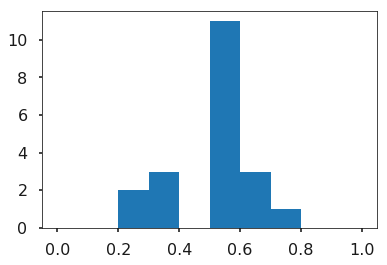

In [13]:
plt.hist(hr_list, bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

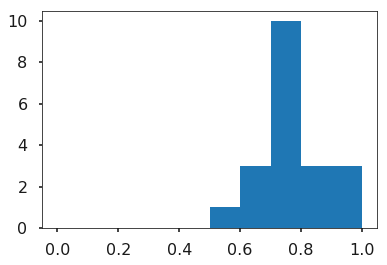

In [14]:
plt.hist(ndcg_list, bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

In [15]:
print("Average Hit Ratio is :")


statistics.mean(hr_list)

Average Hit Ratio is :


0.5159342466846556

In [16]:
print("Average NDCG is :")


statistics.mean(ndcg_list)

Average NDCG is :


0.77074546715597303